![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Logo_Google_Analytics.svg/1280px-Logo_Google_Analytics.svg.png "Google Analytics")

__Objetivo:__
* Balanço geral dos dados da [Google Merchandise store](https://www.googlemerchandisestore.com/) armazenados em BigQuery.
* Segmentação dos consumidores através da análise RFM com a finalidade de melhorar as vendas.

In [1]:
from IPython.core.display import HTML
HTML(open('analytics_content.html', 'r').read())

<a id='libraries'></a>
<h2 style="color:DarkBlue" >Preparação do ambiente</h2> 

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from google.cloud import bigquery
from datetime import datetime
from time import time
import pandas as pd
import numpy as np
import warnings
import gc

from matplotlib import pyplot as plt
import plotly.graph_objects as go
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [4]:
warnings.filterwarnings("ignore")
matplotlib.style.use('bmh')
thrs_min, thrs_max = 0.37, 0.5

<a id='load'></a>
<h2 style="color:DarkBlue" >Carregação dos dados</h2> 

In [5]:
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


A função abaixo permite saber a quantidade de dados que nossas queries retornam sem que isso gaste nossa cota.

In [6]:
def show_amount_of_data_scanned(query):
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Dados processados: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))

Para conhecer melhor os dados, vamos exibir as primeiras linhas da tabela ga_sessions_20160801.

In [7]:
dataset_ref = client.dataset("google_analytics_sample", project="bigquery-public-data")

table_ref = dataset_ref.table("ga_sessions_20160801")

table = client.get_table(table_ref)

client.list_rows(table, max_results=5).to_dataframe()

visitorId  visitNumber     visitId  visitStartTime      date  \
0        NaN            1  1470117657      1470117657  20160801   
1        NaN          151  1470083489      1470083489  20160801   
2        NaN            1  1470052694      1470052694  20160801   
3        NaN            1  1470061879      1470061879  20160801   
4        NaN            1  1470090830      1470090830  20160801   

                                              totals  \
0  {'visits': 1, 'hits': 3, 'pageviews': 3, 'time...   
1  {'visits': 1, 'hits': 3, 'pageviews': 3, 'time...   
2  {'visits': 1, 'hits': 4, 'pageviews': 3, 'time...   
3  {'visits': 1, 'hits': 4, 'pageviews': 4, 'time...   
4  {'visits': 1, 'hits': 4, 'pageviews': 2, 'time...   

                                       trafficSource  \
0  {'referralPath': '/yt/about/', 'campaign': '(n...   
1  {'referralPath': '/yt/about/', 'campaign': '(n...   
2  {'referralPath': '/yt/about/', 'campaign': '(n...   
3  {'referralPath': '/yt/about/', 'campaign': '(n...   
4  {'referralPath': '/yt/about/', 'campaign': '(n...   

                                              device  \
0  {'browser': 'Internet Explorer', 'browserVersi...   
1  {'browser': 'Chrome', 'browserVersion': 'not a...   
2  {'browser': 'Chrome', 'browserVersion': 'not a...   
3  {'browser': 'Firefox', 'browserVersion': 'not ...   
4  {'browser': 'Internet Explorer', 'browserVersi...   

                                          geoNetwork  \
0  {'continent': 'Americas', 'subContinent': 'Nor...   
1  {'continent': 'Americas', 'subContinent': 'Nor...   
2  {'continent': 'Asia', 'subContinent': 'Southea...   
3  {'continent': 'Americas', 'subContinent': 'Nor...   
4  {'continent': 'Americas', 'subContinent': 'Nor...   

                           customDimensions  \
0  [{'index': 4, 'value': 'North America'}]   
1  [{'index': 4, 'value': 'North America'}]   
2                                        []   
3  [{'index': 4, 'value': 'North America'}]   
4  [{'index': 4, 'value': 'North America'}]   

                                                hits        fullVisitorId  \
0  [{'hitNumber': 1, 'time': 0, 'hour': 23, 'minu...  7194065619159478122   
1  [{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...  8159312408158297118   
2  [{'hitNumber': 1, 'time': 0, 'hour': 4, 'minut...  9236304747882138291   
3  [{'hitNumber': 1, 'time': 0, 'hour': 7, 'minut...  1792676004815023069   
4  [{'hitNumber': 1, 'time': 0, 'hour': 15, 'minu...  7305625498291809599   

  userId channelGrouping  socialEngagementType  
0   None          Social  Not Socially Engaged  
1   None          Social  Not Socially Engaged  
2   None          Social  Not Socially Engaged  
3   None          Social  Not Socially Engaged  
4   None          Social  Not Socially Engaged

A descrição de cada campo encontra-se em https://support.google.com/analytics/answer/3437719?hl=pt-BR

<a id='eda'></a>
<h2 style="color:DarkBlue" >Análise dos dados</h2> 


### 1. Quais as visitas e as receitas geradas por cada país?

In [8]:
query1 = '''
         SELECT geoNetwork.country AS country,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
         GROUP BY country
         '''

show_amount_of_data_scanned(query1)

Dados processados: 0.018 GB


In [9]:
df_country = client.query(query1).result().to_dataframe()

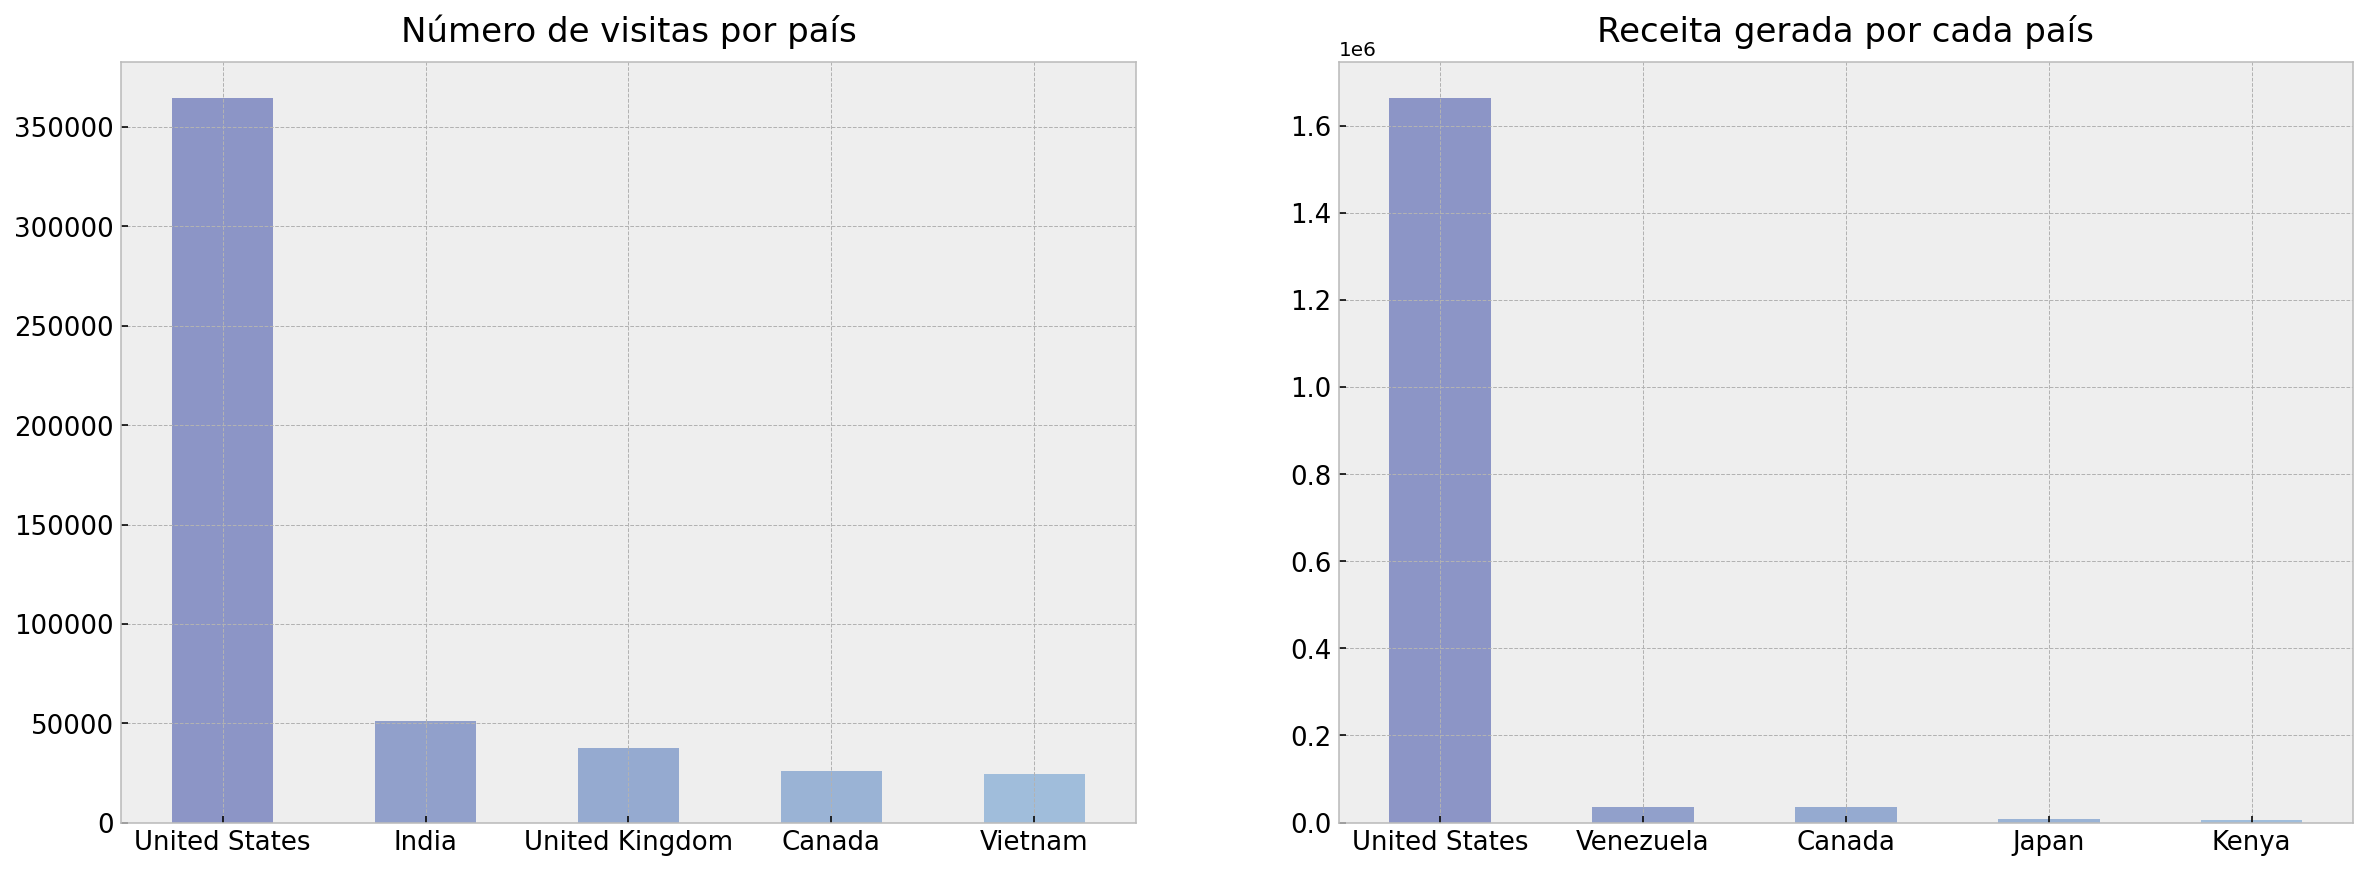

In [10]:
n = 5
cols, rows = 1, 2
df = df_country
title = ['{} país'.format(name) for name in ('Número de visitas por', 'Receita gerada por cada')]
fig, ax = plt.subplots(cols, rows, figsize=(20, 7))

for i in range(rows):
    df.sort_values(by=[df.columns[i + 1]], ascending=False).head(n).plot(kind='bar', fontsize=13, ax=ax[i], x=df.columns[0], y=df.columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0])[::-1])).set_title(title[i], fontdict=dict(fontsize=17), pad=10)
    ax[i].get_legend().remove()
    plt.setp(ax[i].get_xticklabels(), rotation=0)
        
plt.show()

__Sumário__
* Os Estados Unidos possuem o maior número de visitantes e são responsáveis por 93,5% de toda a receita gerada.

Baseado nesses dados, vamos seguir nossas análises com o foco nos Estados Unidos.

In [11]:
del query1, df_country, n, cols, rows, df, title, fig, ax
gc.collect()

6609

### 2. Quais as visitas e as receitas geradas por cada provedor de internet?

In [12]:
query1 = '''
         SELECT geoNetwork.networkDomain AS domain,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY domain
         '''

show_amount_of_data_scanned(query1)

Dados processados: 0.03 GB


In [13]:
df_domain = client.query(query1).result().to_dataframe()

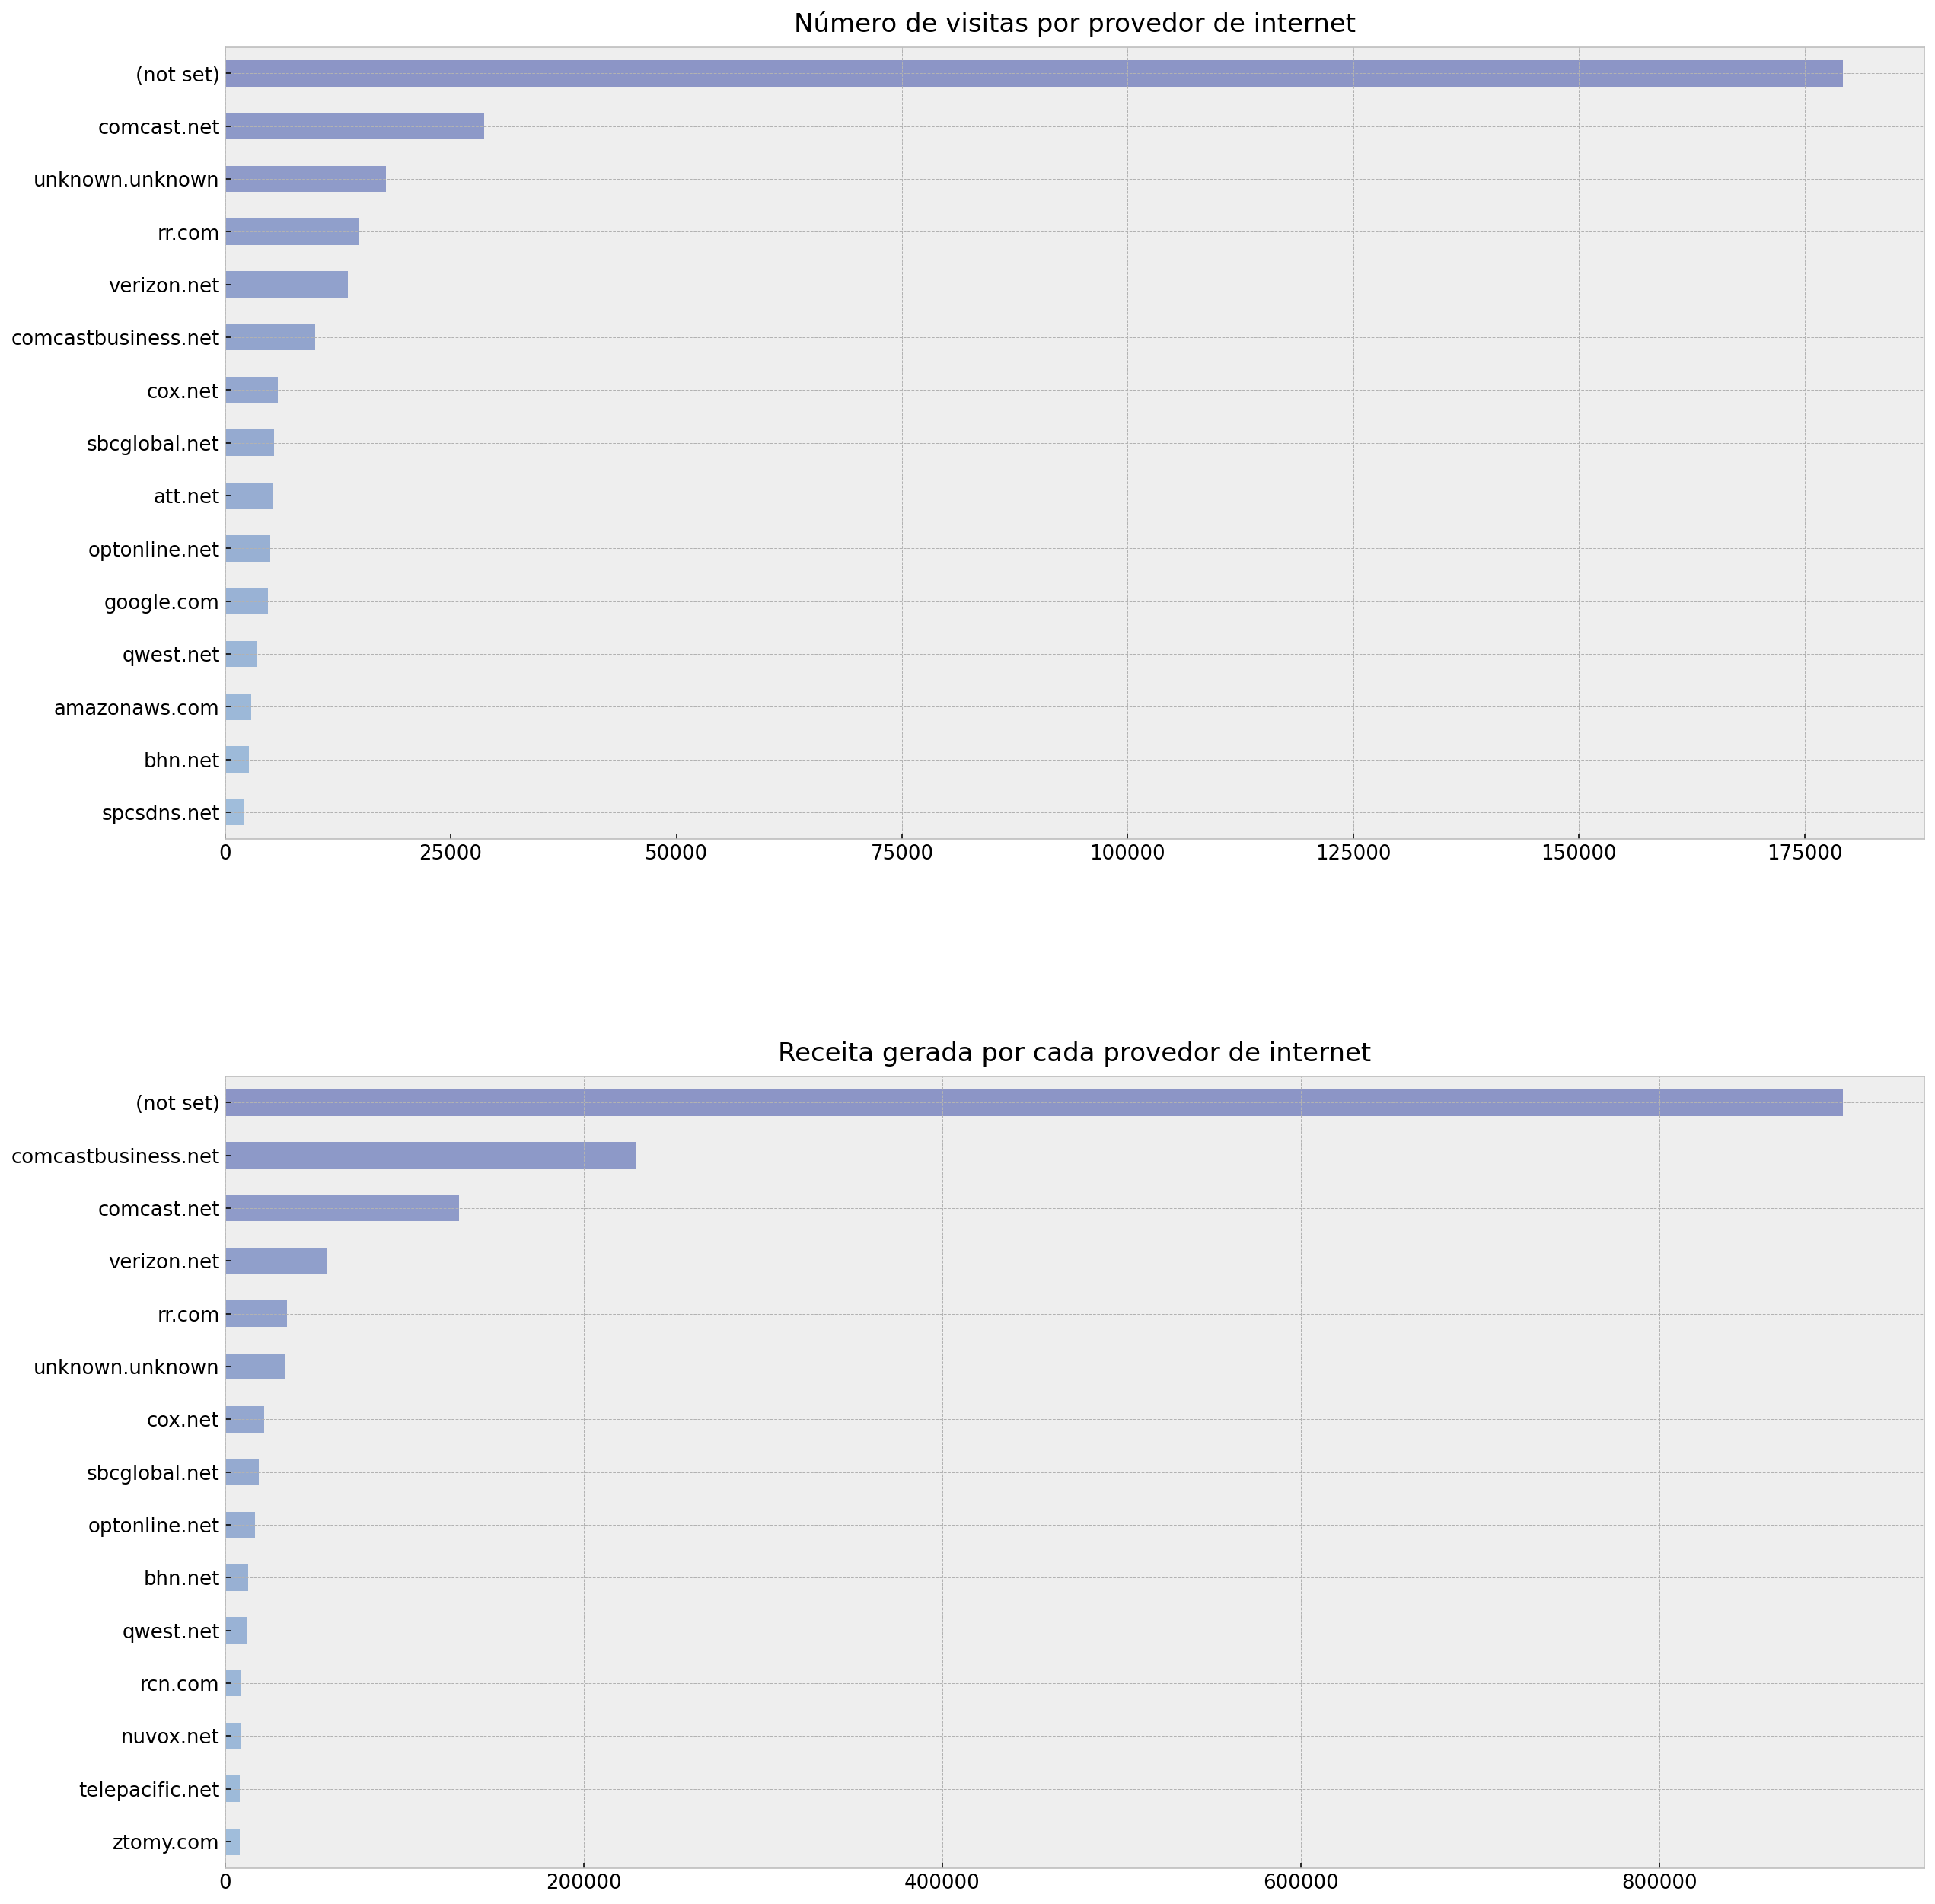

In [14]:
n = 15
cols, rows = 2, 1
df = df_domain
title = ['{} provedor de internet'.format(name) for name in ('Número de visitas por', 'Receita gerada por cada')]
fig, ax = plt.subplots(cols, rows, figsize=(20, 22))

for i in range(cols):
    df.sort_values(by=[df.columns[i + 1]], ascending=True).tail(n).plot(kind='barh', fontsize=13, ax=ax[i], x=df.columns[0], y=df.columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0]))).set_title(title[i], fontdict=dict(fontsize=17), pad=10)
    ax[i].get_legend().remove()

plt.subplots_adjust(hspace=0.3)
plt.show()

__Sumário__
* O provedor de internet da maior parte dos visitantes é desconhecido.
* Esse tráfego é responsável por 54,2% de toda a receita gerada.

In [15]:
del query1, df_domain, n, cols, rows, df, title, fig, ax
gc.collect()

8847

### 3. Quais as visitas e as receitas geradas por cada dispositivo, sistema operacional e navegador?

In [16]:
query1 = """
         SELECT device.deviceCategory AS category,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY device.deviceCategory
         """

query2 = """
         SELECT device.operatingSystem AS os,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY device.operatingSystem
         """

query3 = """
         SELECT device.browser AS browser,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY device.browser
         """

show_amount_of_data_scanned(query1)
show_amount_of_data_scanned(query2)
show_amount_of_data_scanned(query3)

Dados processados: 0.026 GB
Dados processados: 0.026 GB
Dados processados: 0.026 GB


In [17]:
df_device = client.query(query1).result().to_dataframe()
df_os = client.query(query2).result().to_dataframe()
df_browser = client.query(query3).result().to_dataframe()

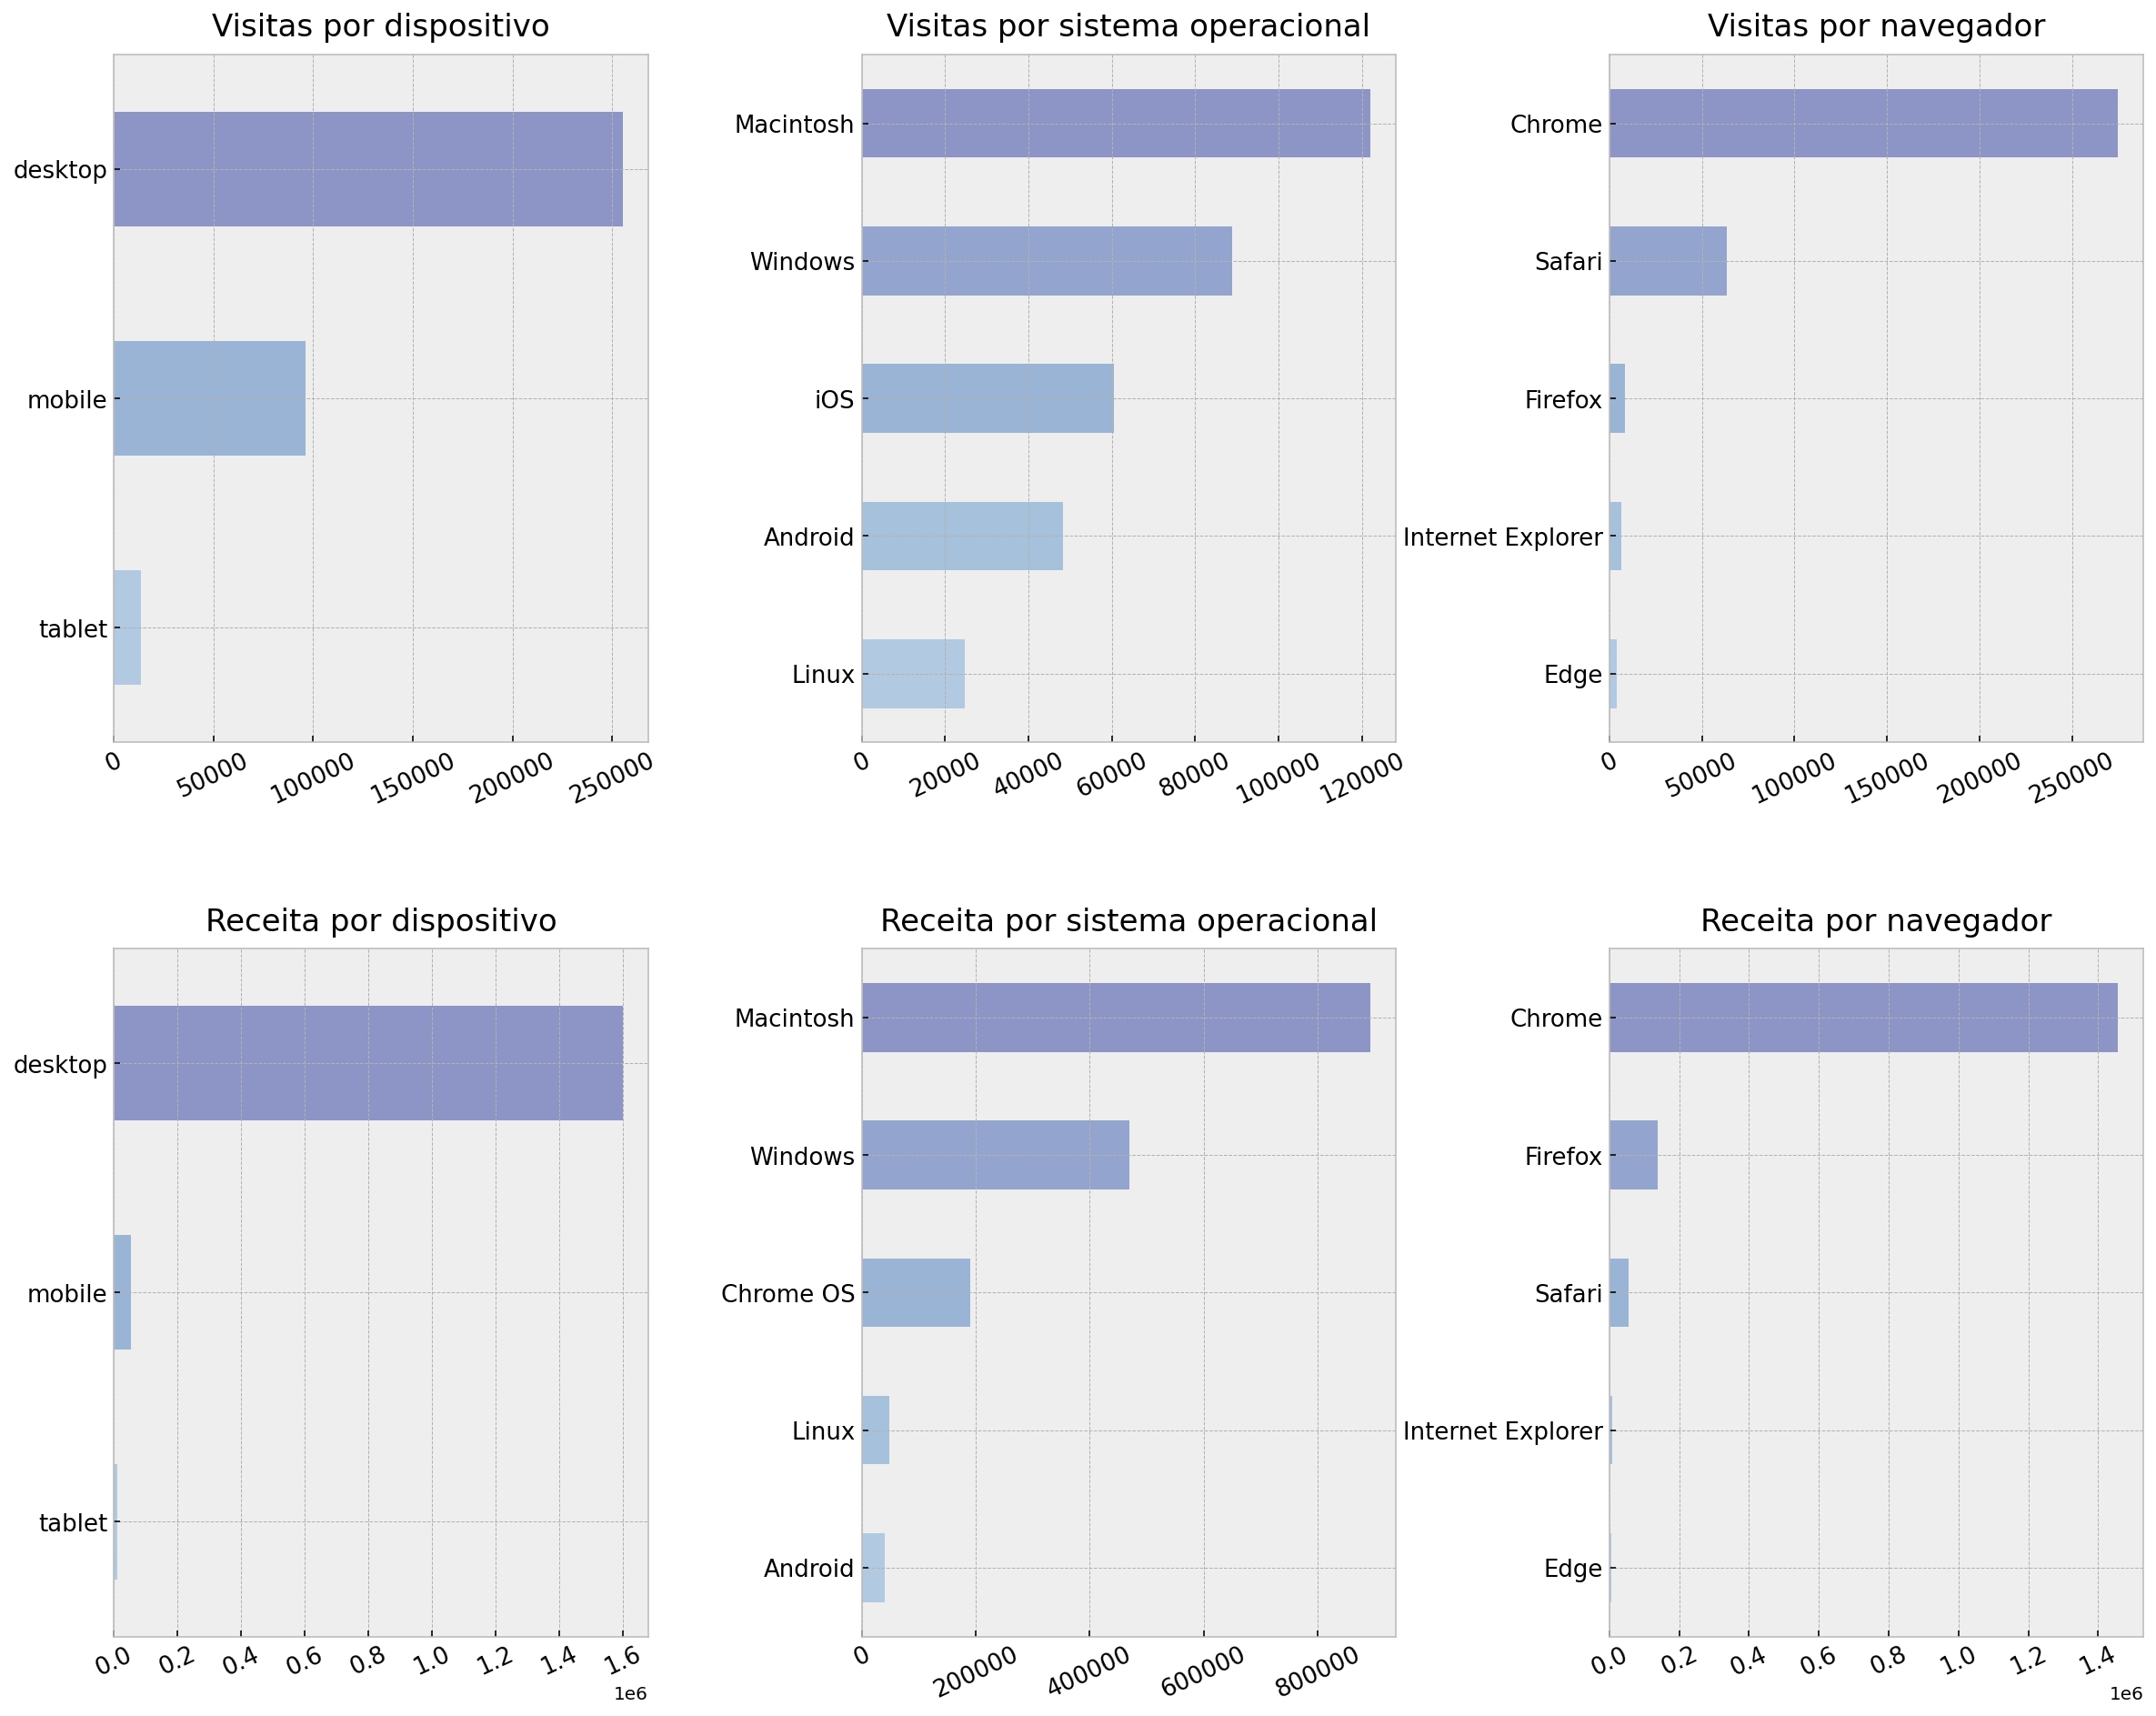

In [18]:
n = 5
cols, rows = 2, 3
df = (df_device, df_os, df_browser)
title = ['{} por {}'.format(name1, name2) for name1 in ('Visitas', 'Receita') for name2 in ('dispositivo', 'sistema operacional', 'navegador')]
fig, ax = plt.subplots(cols, rows, figsize=(20, 16))

for i in range(cols):
    for j in range(rows):
        df[j].sort_values(by=[df[j].columns[i + 1]], ascending=True).tail(n).plot(kind='barh', fontsize=13, ax=ax[i][j], x=df[j].columns[0], y=df[j].columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(0.3, 0.5, n if df[j].shape[0] > n else df[j].shape[0]))).set_title(title[j + rows * i], fontdict=dict(fontsize=17), pad=10)
        ax[i][j].get_legend().remove()
        plt.setp(ax[i][j].get_xticklabels(), rotation=25)

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

__Sumário__
* Os dispositivos mais usados pelos visitantes são os computadores com sistemas operacionais Windows ou Macintosh.
* Chrome é o navegador que mais as pesssoas utilizam, sendo responsável por 87,5% de toda a receita gerada.
* A receita baixa gerada pelos dispositivos móveis pode ter como causa a falta de um aplicativo que forneça uma interface otimizada para esses aparelhos.

In [19]:
del query1, query2, query3, df_device, df_os, df_browser, n, cols, rows, df, title, fig, ax
gc.collect()

18476

### 4. Quais as visitas e as receitas geradas por cada canal?

In [20]:
query1 = """
         SELECT channelGrouping AS channel,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY channel
         """

show_amount_of_data_scanned(query1)

Dados processados: 0.029 GB


In [21]:
df_channel = client.query(query1).result().to_dataframe()

Antes de mostrar os gráficos, vamos dar uma breve explicação sobre o significado de cada canal.

|Canal           |Descrição                                                                                                         |
|:---------------|:-----------------------------------------------------------------------------------------------------------------|
|Organic Search  |São os usuários que chegam em seu site através do link não pago resultante de uma pesquisa em um motor de busca.  |
|Paid Search     |As pessoas que encontraram seu site devido aos anúncios dos motores de busca.                                     |
|Direct          |Os visitantes que digitaram o endereço de seu site diretamente no navegador.                                      |
|Referral        |Os usuários que vieram ao seu site através de algum outro que o citou.                                            |
|Social          |As pessoas que chegam em seu site devido aos anúncios exibidos em redes sociais.                                  |
|Display         |Os visitantes que encontram seu site graças aos anúncios exibidos em outros sites.                                |

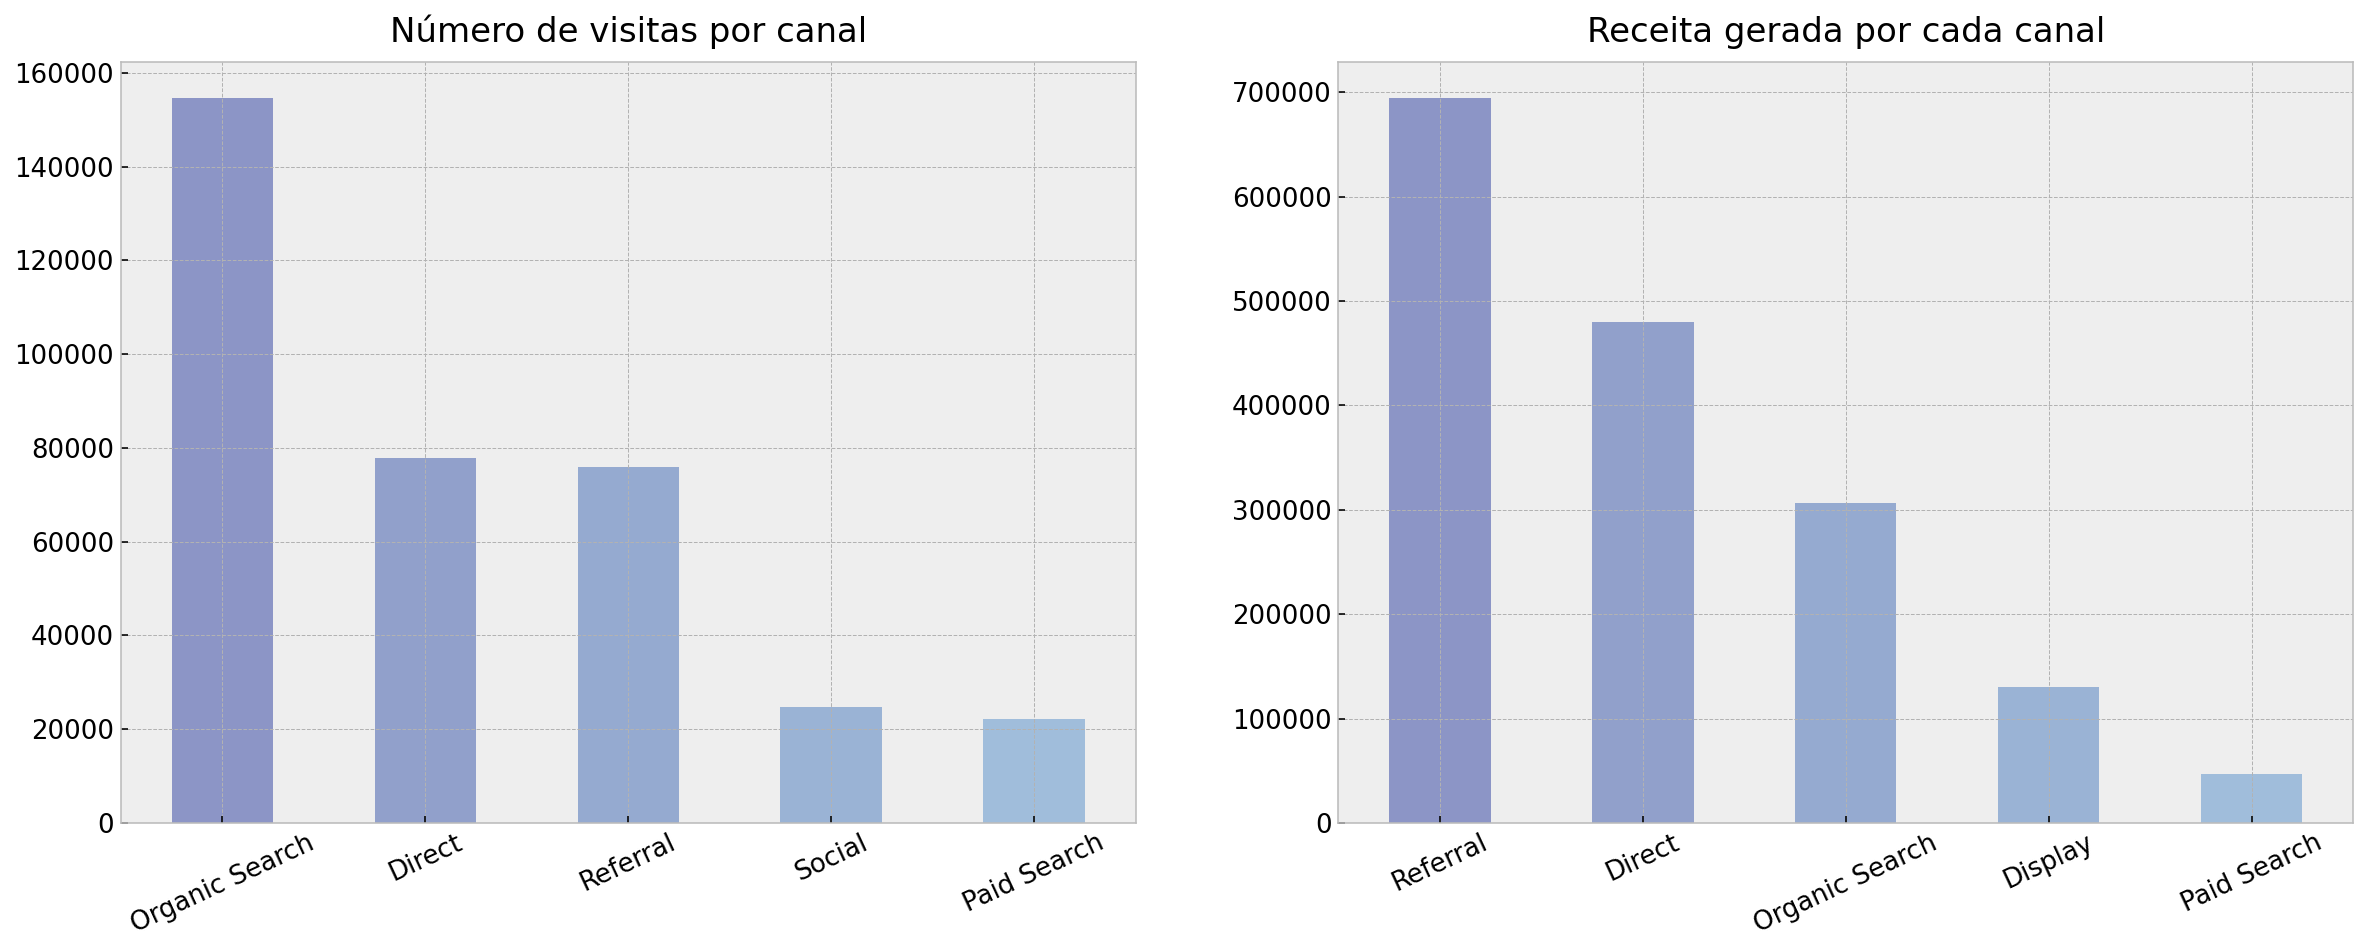

In [22]:
n = 5
cols, rows = 1, 2
df = df_channel
title = ['{} canal'.format(name) for name in ('Número de visitas por', 'Receita gerada por cada')]
fig, ax = plt.subplots(cols, rows, figsize=(20, 7))

for i in range(rows):
    df.sort_values(by=[df.columns[i + 1]], ascending=False).head(n).plot(kind='bar', fontsize=13, ax=ax[i], x=df.columns[0], y=df.columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0])[::-1])).set_title(title[i], fontdict=dict(fontsize=17), pad=10)
    ax[i].get_legend().remove()
    plt.setp(ax[i].get_xticklabels(), rotation=25)
        
plt.show()

__Sumário__
* A maior parte dos visitantes chegam através da pesquisa orgânica, embora a maior receita seja gerada pelo tráfego por referência.
* O tráfego por referência e o direto são responsáveis por 70,5% de toda a receita gerada.

In [23]:
del query1, df_channel, n, cols, rows, df, title, fig, ax
gc.collect()

6802

### 5. Quais as visitas e as receitas geradas por cada fonte de tráfego?

In [24]:
query1 = """
         SELECT trafficSource.source AS source,
                COUNT(trafficSource.source) as visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY source
         """

show_amount_of_data_scanned(query1)

Dados processados: 0.02 GB


In [25]:
df_traffic_source = client.query(query1).result().to_dataframe()

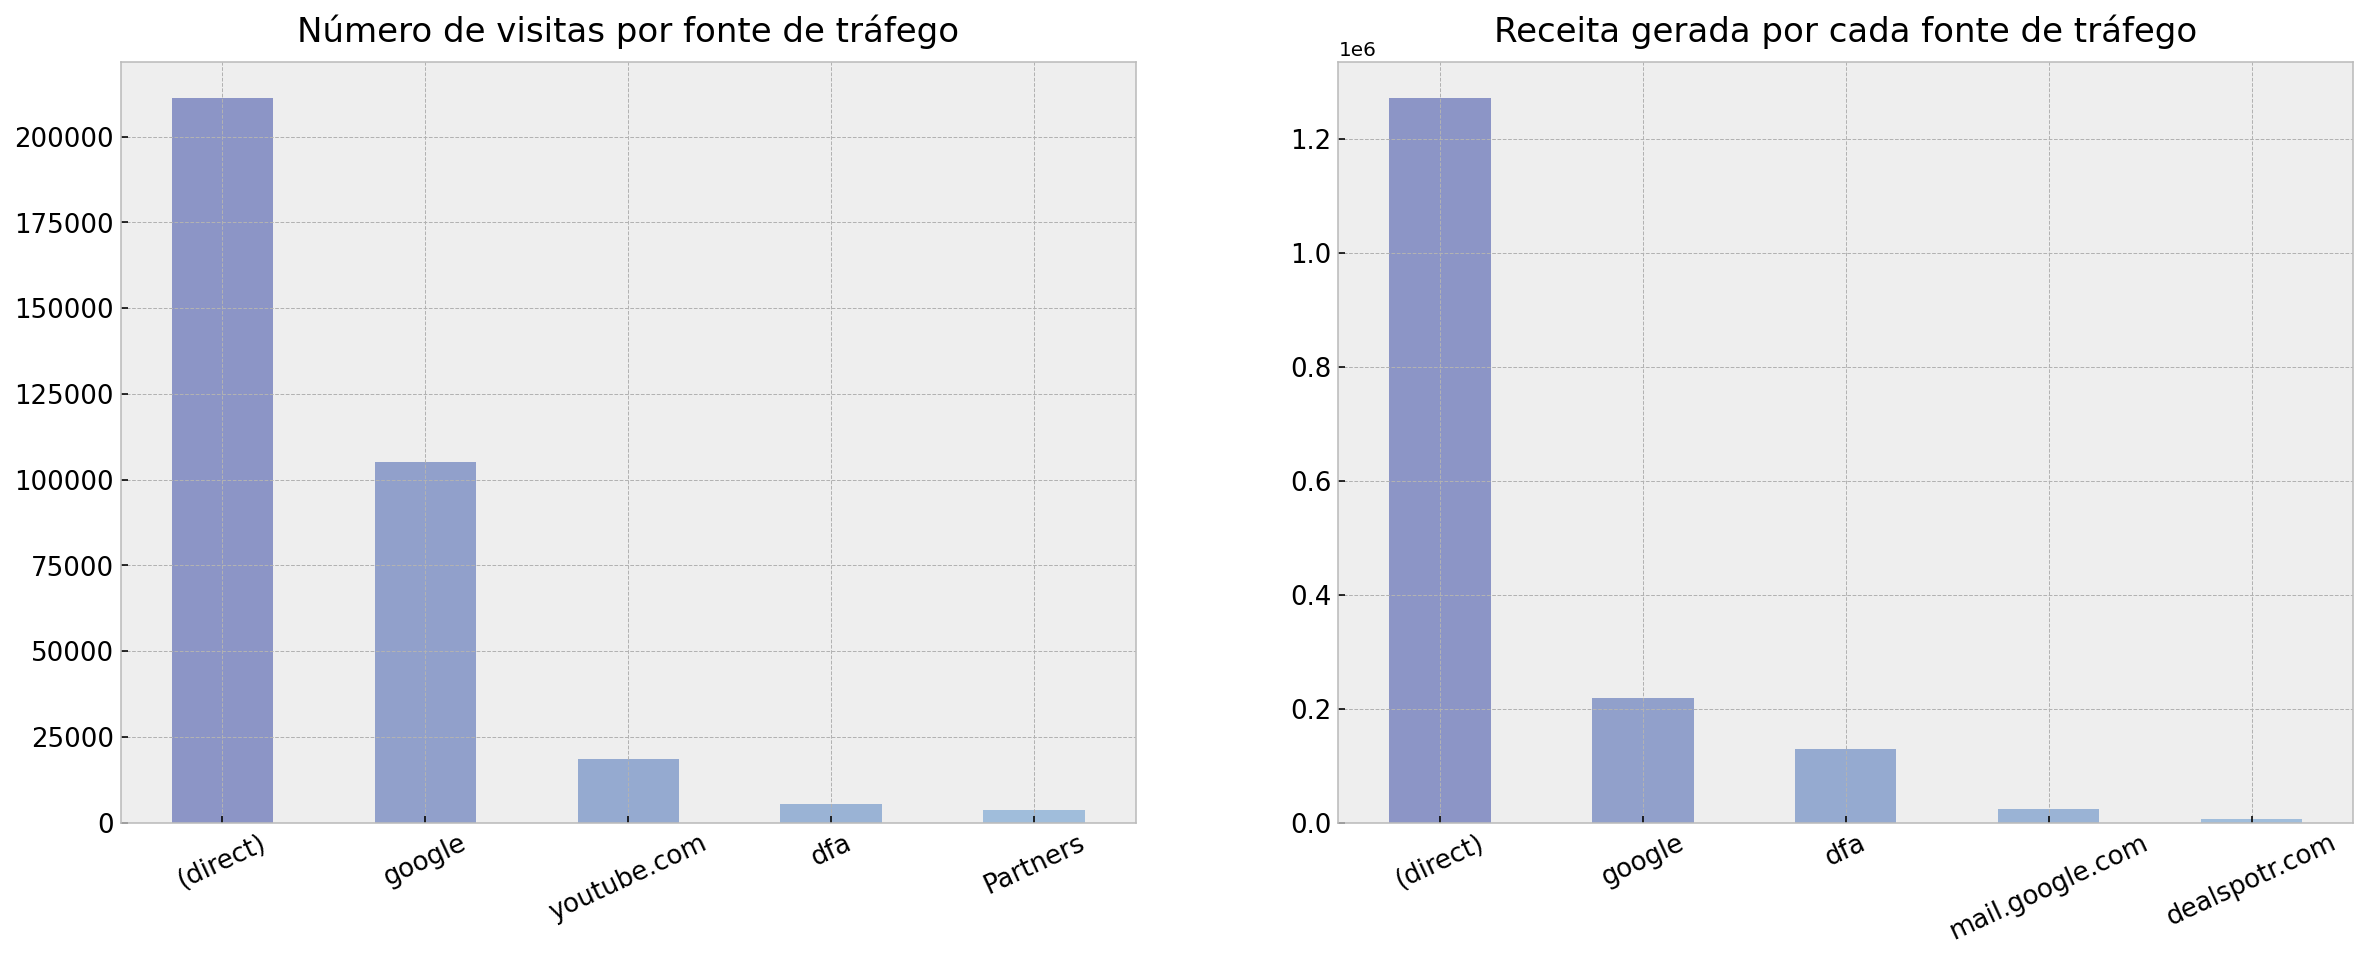

In [26]:
n = 5
cols, rows = 1, 2
df = df_traffic_source
title = ['Número de visitas por fonte de tráfego', 'Receita gerada por cada fonte de tráfego']
fig, ax = plt.subplots(cols, rows, figsize=(20, 7))

for i in range(rows):
    df.sort_values(by=[df.columns[i + 1]], ascending=False).head(n).plot(kind='bar', fontsize=13, ax=ax[i], x=df.columns[0], y=df.columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0])[::-1])).set_title(title[i], fontdict=dict(fontsize=17), pad=10)
    ax[i].get_legend().remove()
    plt.setp(ax[i].get_xticklabels(), rotation=25)

plt.show()

__Sumário__
* O meio direto é responsável pela maior parte das visitas e por 76,4% de toda a receita gerada.

Obs: Tínhamos visto que o tráfego por referência gerava a maior parte da receita. É estranho que os dados apontem que a fonte direta seja a origem de todos esses lucros. Vamos averiguar essa situação descobrindo a qual canal cada fonte de tráfego pertence.

In [27]:
del query1, df_traffic_source, n, cols, rows, df, title, fig, ax
gc.collect()

6526

In [28]:
query1 = """
         SELECT channelGrouping AS channel,
                trafficSource.source AS source,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY channel, source
         """

show_amount_of_data_scanned(query1)

Dados processados: 0.038 GB


In [29]:
df_traffic_channel_source = client.query(query1).result().to_dataframe()

In [30]:
df_traffic_crosstab = pd.crosstab(df_traffic_channel_source['source'], df_traffic_channel_source['channel'])

In [31]:
fig = go.Figure(data=[go.Table(
                columnwidth= [45] + [25 for i in range(df_traffic_crosstab.columns.shape[0])],
                header=dict(values=list(['Fonte'] + df_traffic_crosstab.columns.tolist()),
                line_color='darkslategray',
                fill_color='gray',
                font=dict(color='white', size=12),
                align='left'),
                cells=dict(values=[df_traffic_crosstab.index] +
                                  [df_traffic_crosstab.iloc[:,i] for i in range(df_traffic_crosstab.columns.shape[0])],
                line_color='darkslategray',
                fill_color=['white'] +
                           [df_traffic_crosstab.iloc[:,i].map({0: 'white', 1: 'rgb(0, 200, 200)'}) for i in range(df_traffic_crosstab.columns.shape[0])],
                font=dict(color='darkslategray', size=11),
                align='left'))])

fig.update_layout(title_text='Canal de cada fonte de tráfego')
fig.show()

O problema é que a fonte direta está sendo associada a quase todos os canais. Os outros tipos de fontes de tráfegos estão sendo corretamente vinculados aos seus canais de origem.

In [32]:
del query1, df_traffic_channel_source, df_traffic_crosstab, fig
gc.collect()

320

### 6. Qual a taxa de rejeição gerada por cada fonte de tráfego?

O que é taxa de rejeição?

É uma métrica que permite saber a porcentagem de pessoas que vieram ao seu site e sairam sem realizar nenhuma ação.


In [33]:
query1 = """
         WITH bounce_counts AS 
         (SELECT trafficSource.source AS source,
                 COUNT(trafficSource.source) AS visits,
                 IFNULL(SUM(totals.transactions), 0) as num_transactions,
                 IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue,
                 IFNULL(SUM(totals.bounces), 0) AS num_bounces
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY source)

         SELECT source,
                visits,
                num_transactions,
                revenue,
                num_bounces,
                ROUND((100 * (num_bounces / visits)), 2) AS bounce_rate
         FROM bounce_counts
         ORDER BY revenue DESC
         """

show_amount_of_data_scanned(query1)

Dados processados: 0.024 GB


In [34]:
df_traffic_bounce = client.query(query1).result().to_dataframe()

In [35]:
df_aux = df_traffic_bounce.sort_values(by='revenue', ascending=False).rename(columns={'source': 'fonte', 'visits': 'visitas', 'num_transactions': 'num_transações', 'revenue': 'receita', 'num_bounces': 'num_rejeições', 'bounce_rate': 'taxa_de_rejeição'})

In [36]:
fig = go.Figure(data=[go.Table(
                columnwidth= [45] + [25 for i in range(df_aux.shape[1] - 1)],
                header=dict(values=list(df_aux.columns.tolist()),
                line_color='darkslategray',
                fill_color='gray',
                font=dict(color='white', size=12),
                align='left'),
                cells=dict(values=[df_aux.iloc[:,i] for i in range(df_aux.columns.shape[0])],
                line_color='darkslategray',
                fill_color='white',
                font=dict(color='darkslategray', size=11),
                align='left'))])

fig.update_layout(title_text='Taxa de rejeição das fontes de tráfego que geram as maiores receitas')
fig.show()

__Sumário__
* A taxa de rejeição é alta para usuários vindos do Youtube.

In [37]:
del query1, df_aux, df_traffic_bounce, fig
gc.collect()

309

### 7. Quais os anúncios mais vistos e o quanto de receita ele geram?

In [38]:
query1 = '''
         SELECT trafficSource.adContent AS source,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY source
         '''

show_amount_of_data_scanned(query1)

Dados processados: 0.018 GB


In [39]:
df_ads = client.query(query1).result().to_dataframe()

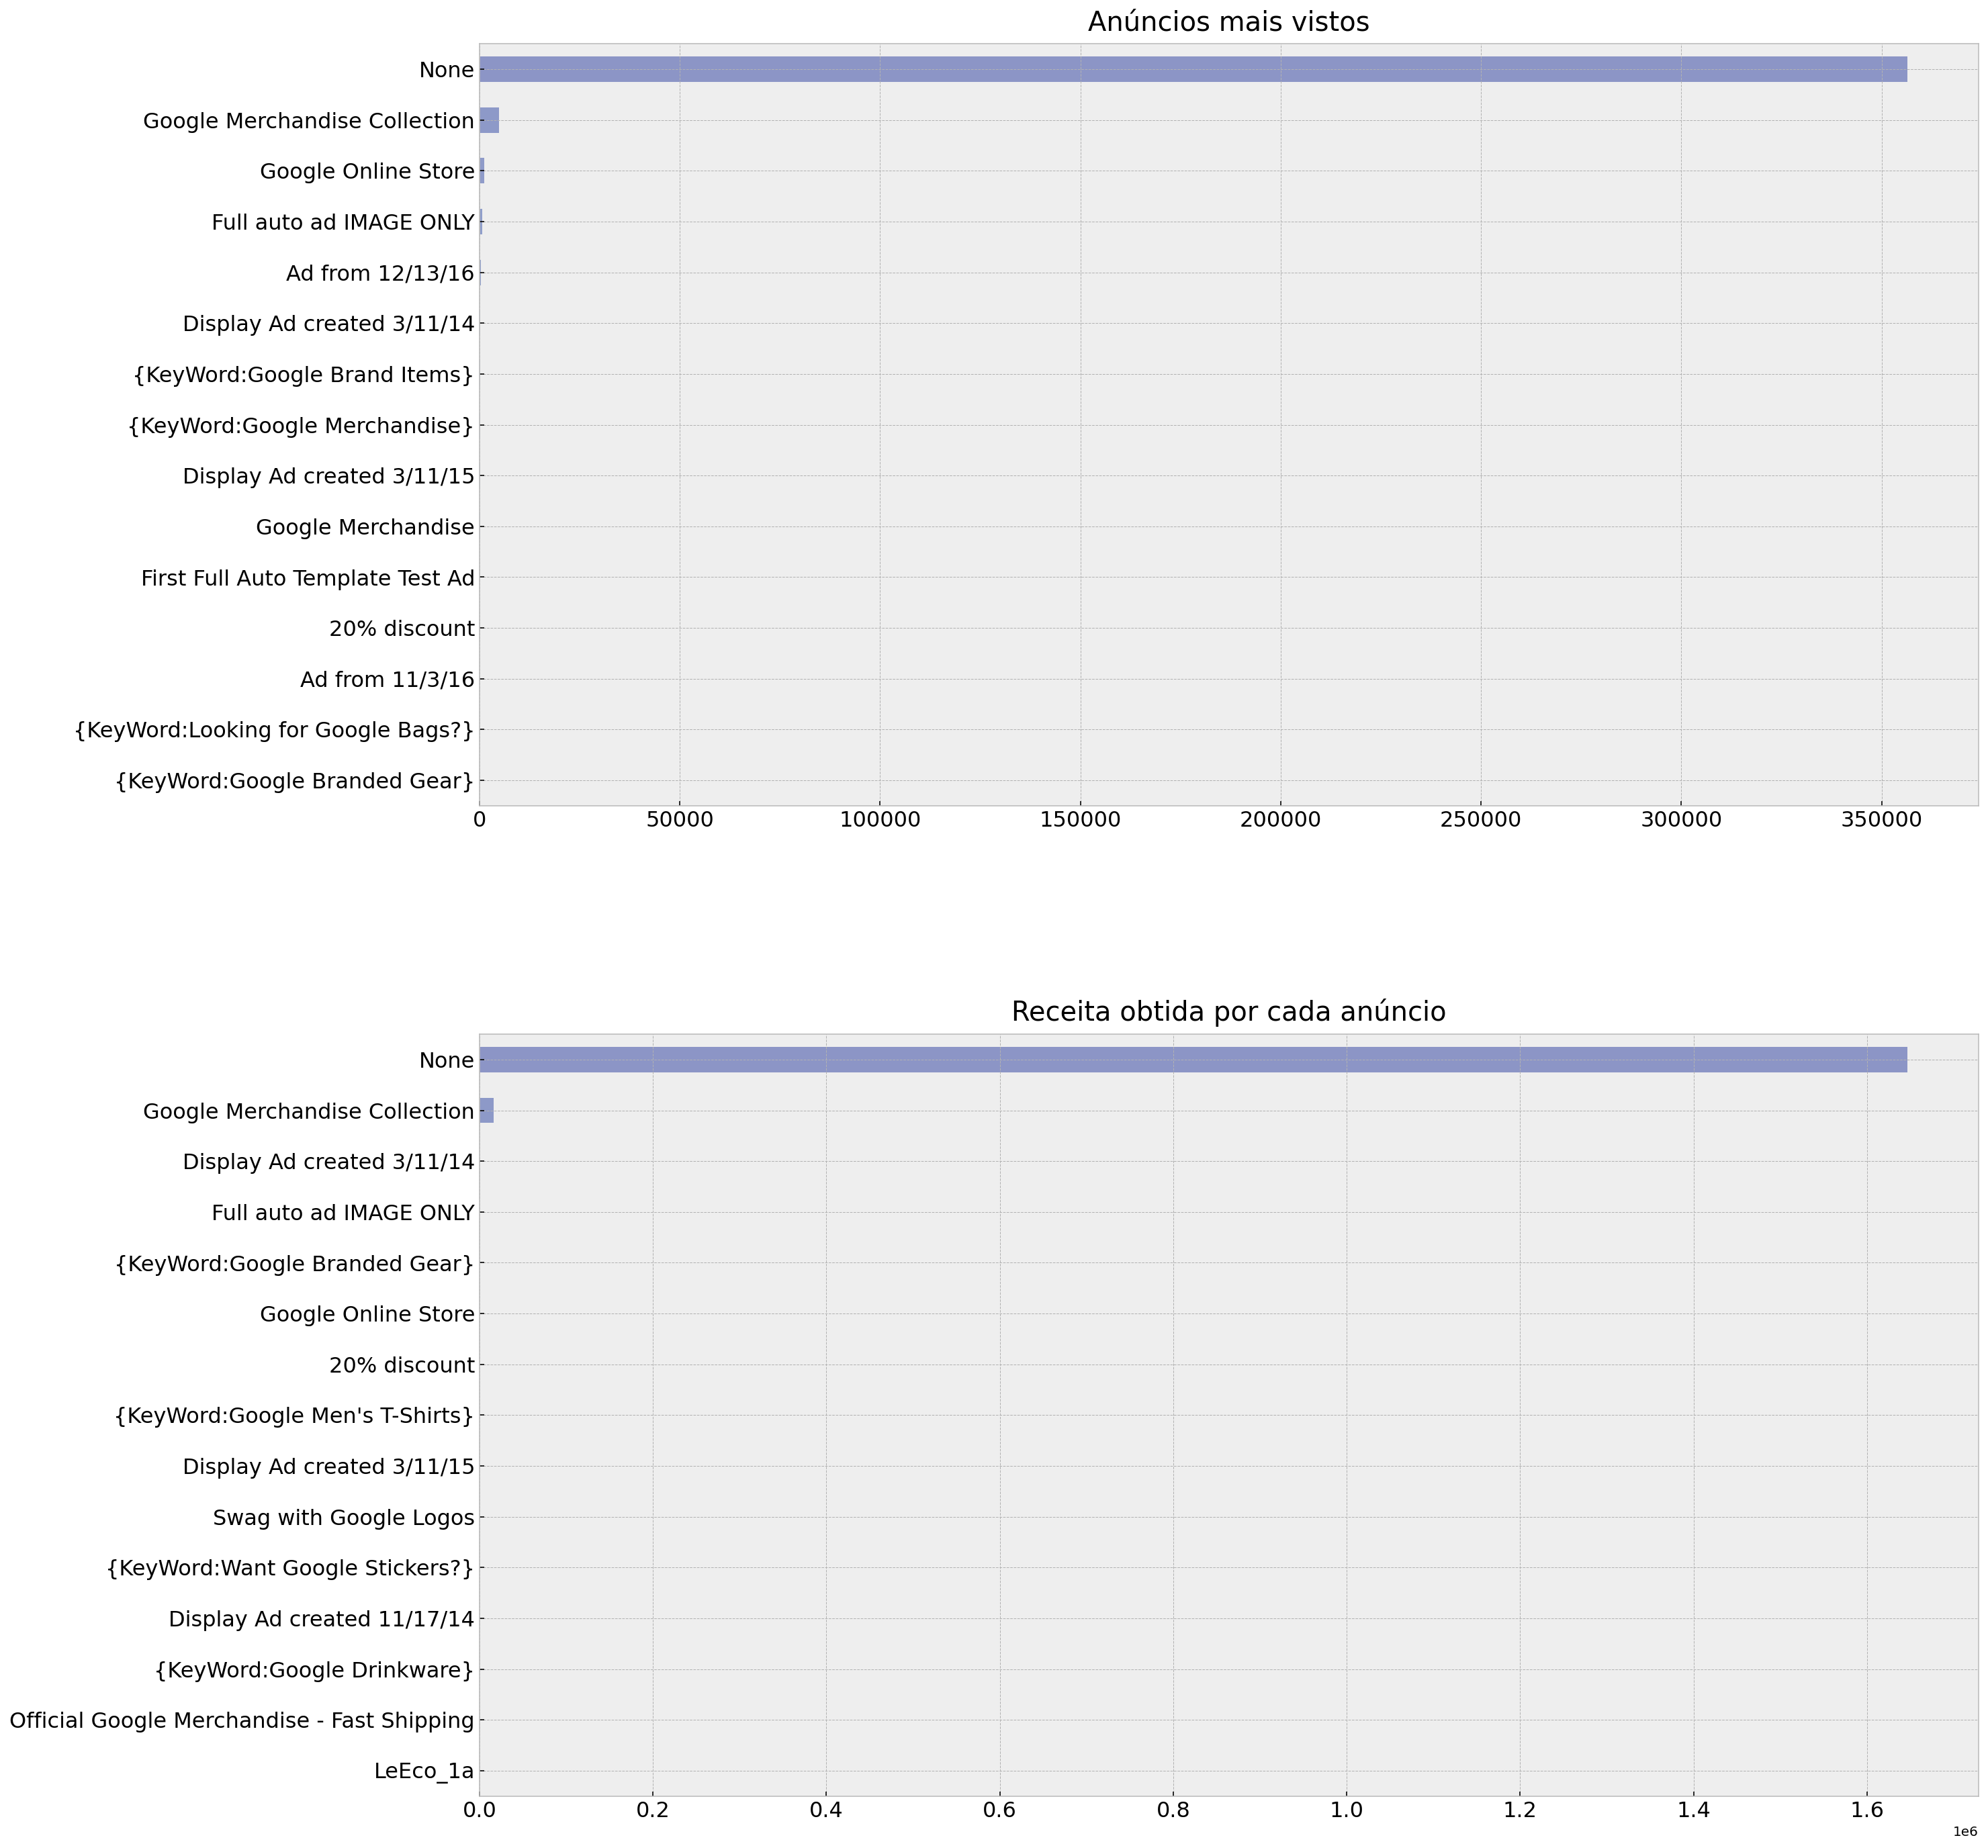

In [40]:
n = 15
cols, rows = 2, 1
df = df_ads
title = ['Anúncios mais vistos', 'Receita obtida por cada anúncio']
fig, ax = plt.subplots(cols, rows, figsize=(20, 24))

for i in range(cols):
    df.sort_values(by=[df.columns[i + 1]], ascending=True).tail(n).plot(kind='barh', ax=ax[i], fontsize=16, x=df.columns[0], y=df.columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0]))).set_title(title[i], fontdict=dict(fontsize=20), pad=10)
    ax[i].get_legend().remove()

plt.subplots_adjust(hspace=0.3)
plt.show()

__Sumário__
* A maior parte das pessoas visitaram a loja e realizaram suas compras sem assitirem os anúncios.

Obs: Isso não quer dizer que os anúncios sejam inúteis. Eles atraem novos usuários que, após a primeira visita, retornam ao site através de outros meios.

In [41]:
del query1, df_ads, n, cols, rows, df, title, fig, ax
gc.collect()

9397

### 8. Quais são as páginas mais vistas e qual o tempo médio que o usuário passa em cada uma?

In [42]:
query1 = """
         SELECT hits.page.pagePathLevel1 AS pagePath,
                SUM(totals.pageviews) AS pageViews,
                AVG(totals.timeOnSite) AS timeOnSite
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
              UNNEST(hits) AS hits
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY pagePath
         """

show_amount_of_data_scanned(query1)

Dados processados: 0.086 GB


In [43]:
df_page = client.query(query1).result().to_dataframe()

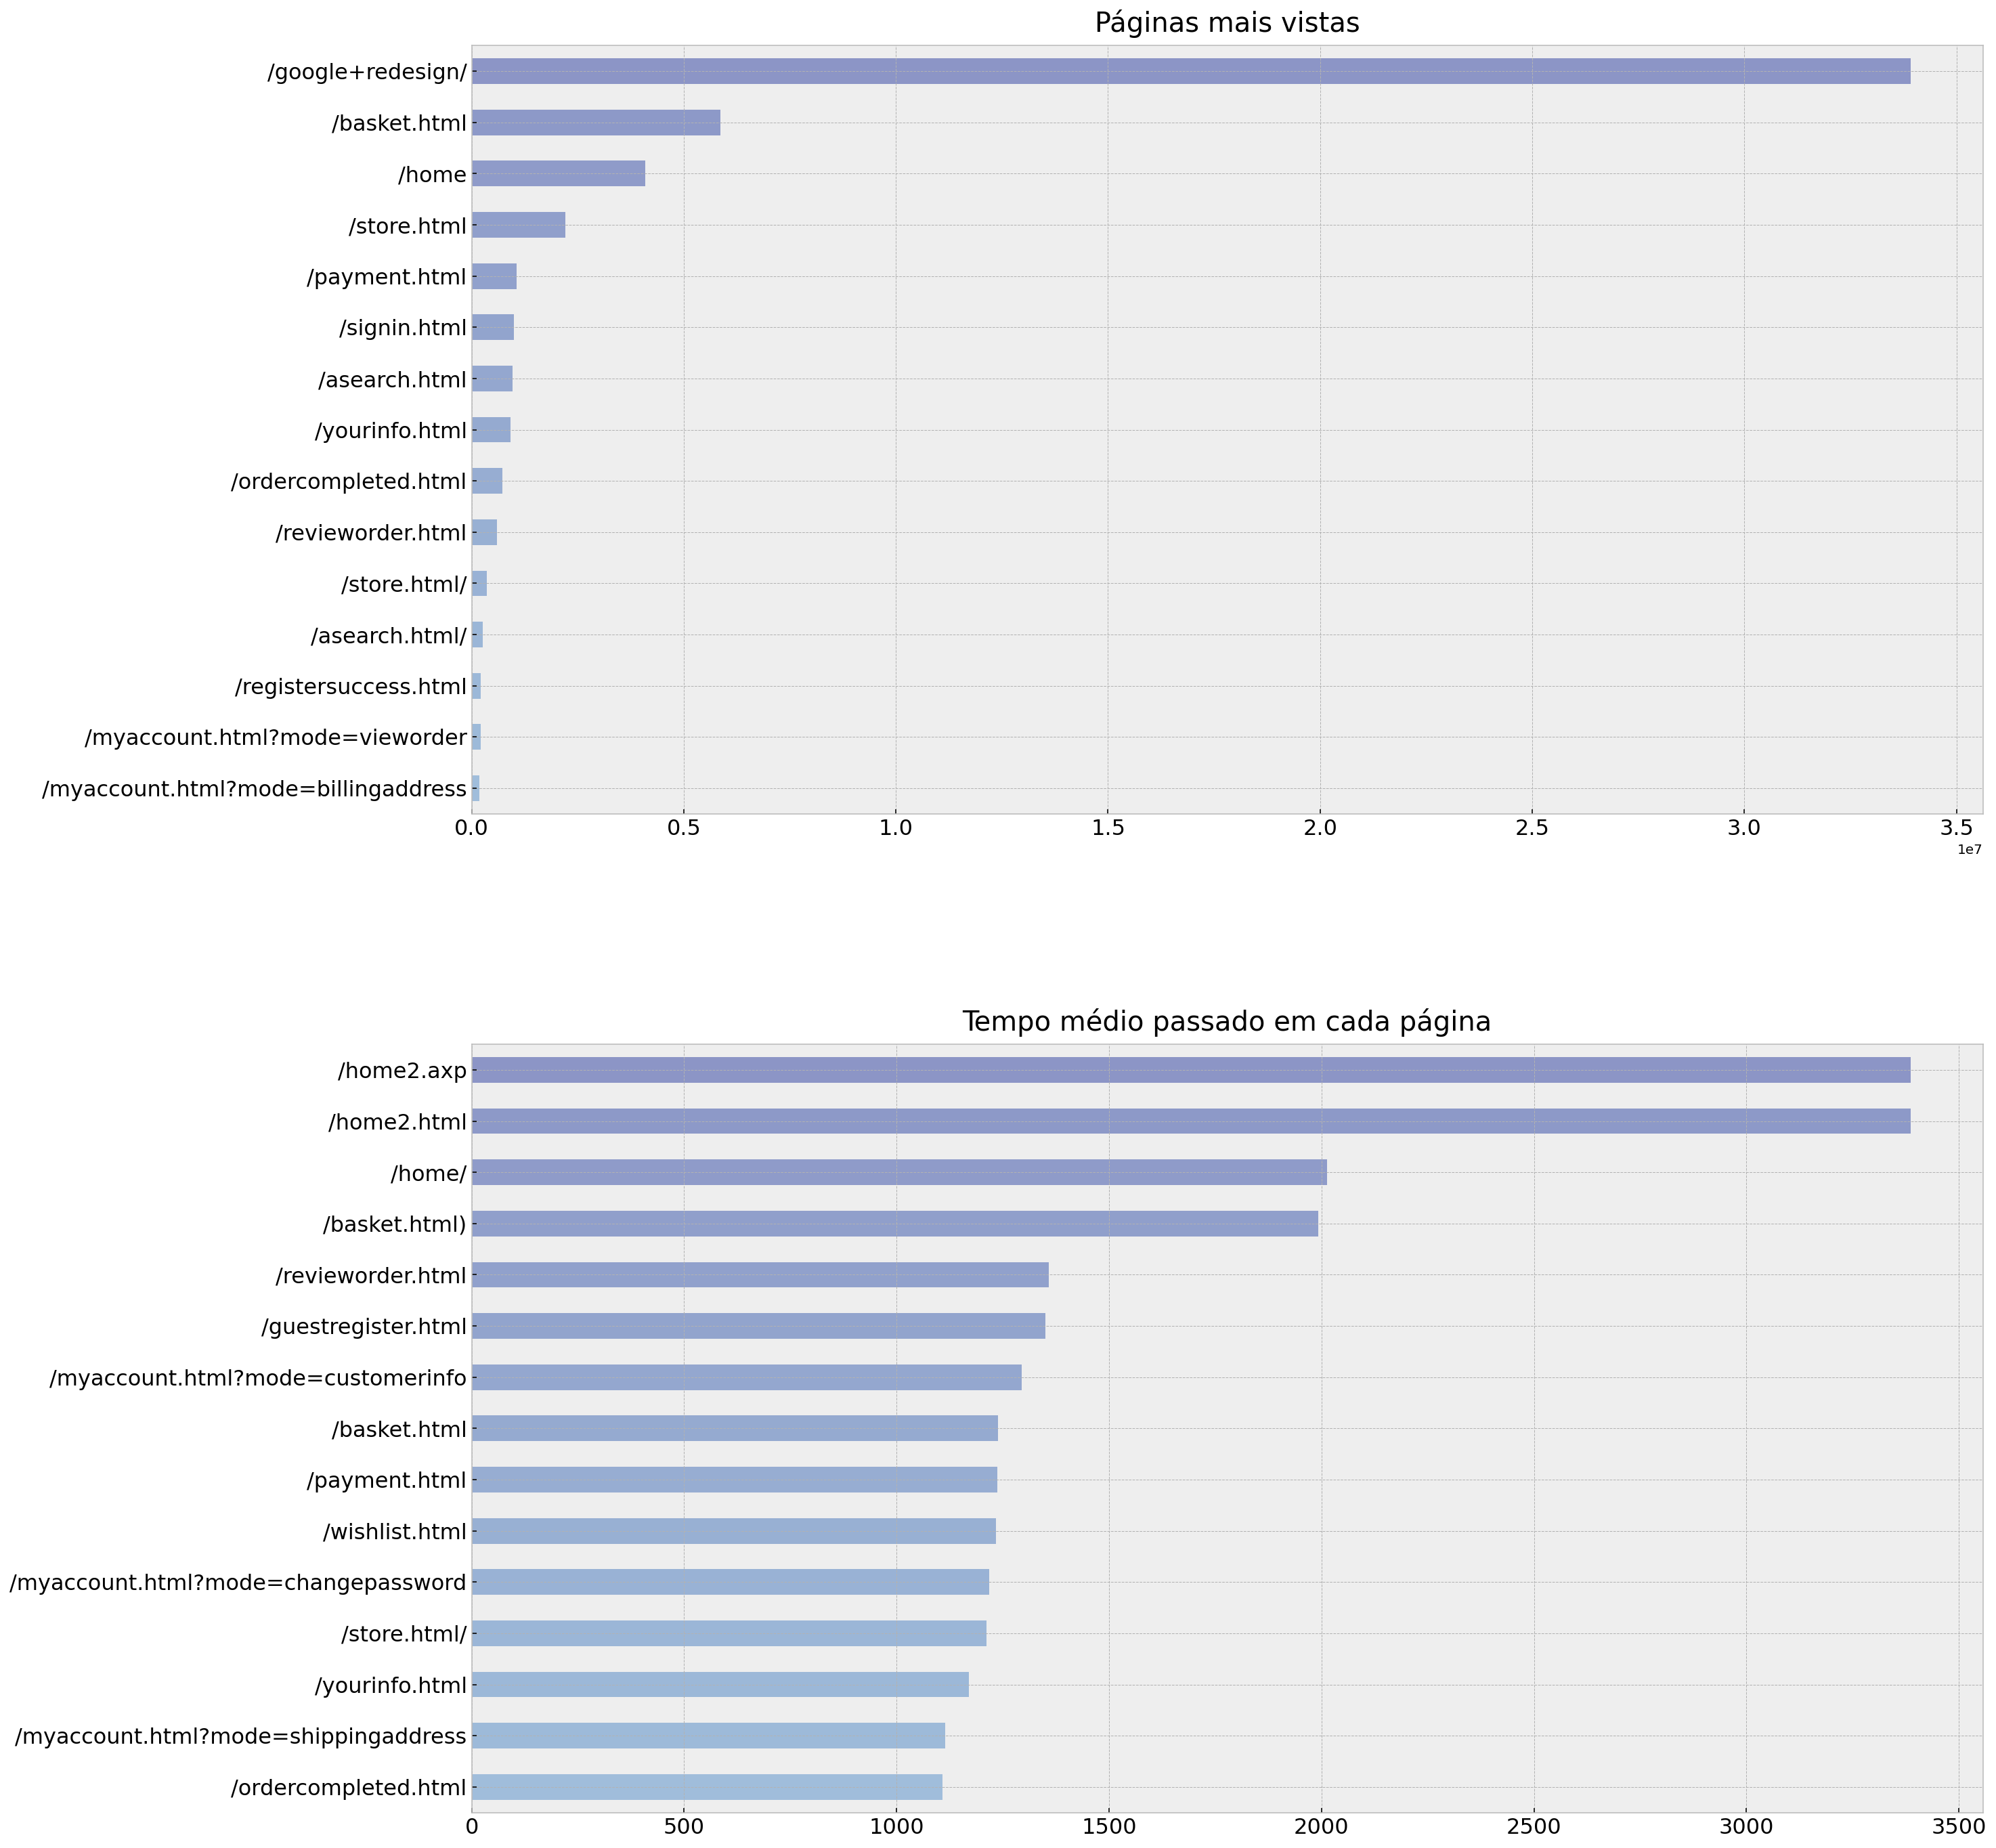

In [44]:
n = 15
cols, rows = 2, 1
df = df_page
title = ['Páginas mais vistas', 'Tempo médio passado em cada página']
fig, ax = plt.subplots(cols, rows, figsize=(20, 24))

for i in range(cols):
    df.sort_values(by=[df.columns[i + 1]], ascending=True).tail(n).plot(kind='barh', fontsize=16, ax=ax[i], x=df.columns[0], y=df.columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0]))).set_title(title[i], fontdict=dict(fontsize=20), pad=10)
    ax[i].get_legend().remove()

plt.subplots_adjust(hspace=0.3)
plt.show()

__Sumário__
* "/google+redesign" é responsável por 63,6% de todas as visualizações.
* Os usuários passam uma boa quantidade de tempo revisando os seus pedidos.

In [45]:
del query1, df_page, n, cols, rows, df, title, fig, ax
gc.collect()

9288

### 9. Quais são as categorias de produtos mais vendidos e qual o retorno que elas geram?

In [46]:
query1 = """
         SELECT product.v2ProductCategory AS product_category,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue,
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
               UNNEST(hits) AS hits,
               UNNEST(hits.product) AS product
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY product_category
         """

show_amount_of_data_scanned(query1)

Dados processados: 0.487 GB


In [47]:
df_products_category = client.query(query1).result().to_dataframe()

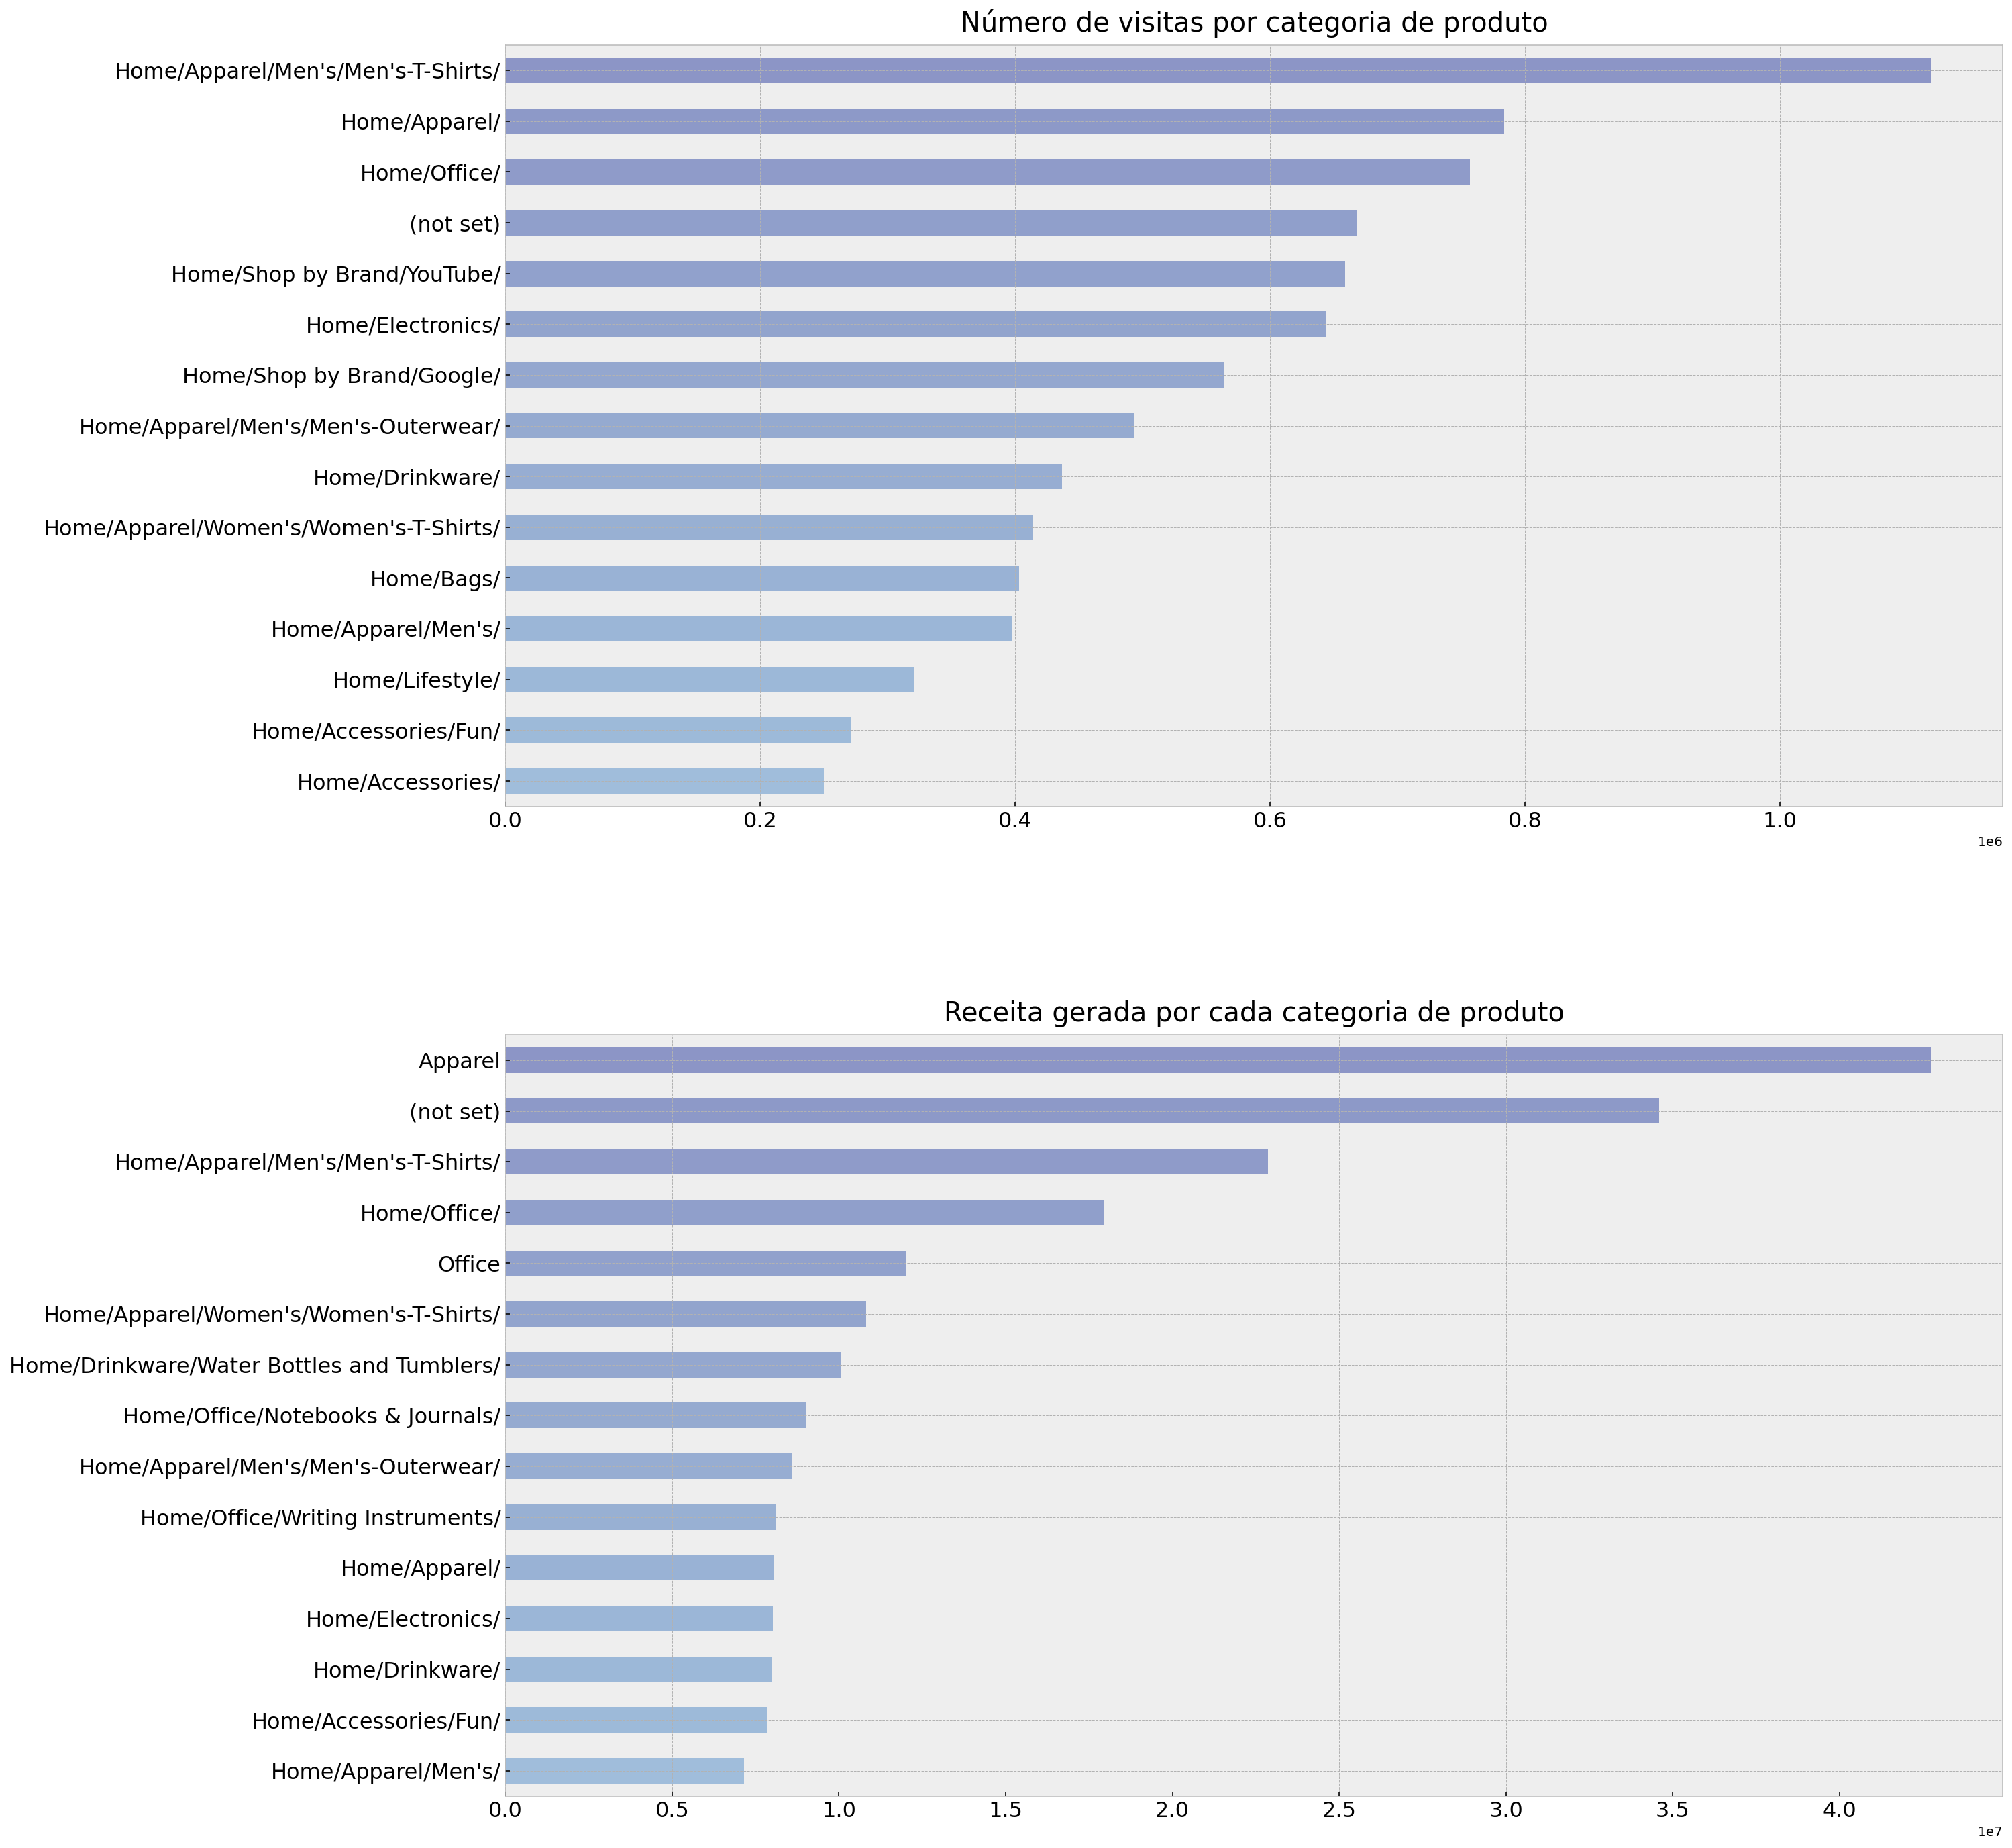

In [48]:
n = 15
cols, rows = 2, 1
df = df_products_category
title = ['{} categoria de produto'.format(name) for name in ('Número de visitas por', 'Receita gerada por cada')]
fig, ax = plt.subplots(cols, rows, figsize=(20, 24))

for i in range(cols):
    df.sort_values(by=[df.columns[i + 1]], ascending=True).tail(n).plot(kind='barh', fontsize=16, ax=ax[i], x=df.columns[0], y=df.columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0]))).set_title(title[i], fontdict=dict(fontsize=20), pad=10)
    ax[i].get_legend().remove()

plt.subplots_adjust(hspace=0.3)
plt.show()

__Sumário__
* Camisetas masculinas é uma categoria bem popular, assim como produtos voltados aos escritórios.

In [49]:
del query1, n, cols, rows, title, fig, ax
gc.collect()

9195

### 10. Quais as visitas e as receitas geradas por cada sexo?

Infelizmente esse tipo de dado não está presente. O que vamos fazer é contar o número de visitas e as receitas das categorias de produtos que contenham "Men" ou "Women".

In [50]:
df_category_sex = df_products_category[df_products_category.product_category.str.contains("(?i)men")]
df_category_men = df_category_sex[~df_products_category.product_category.str.contains("(?i)women")]
df_category_women = df_category_sex[df_products_category.product_category.str.contains("(?i)women")]

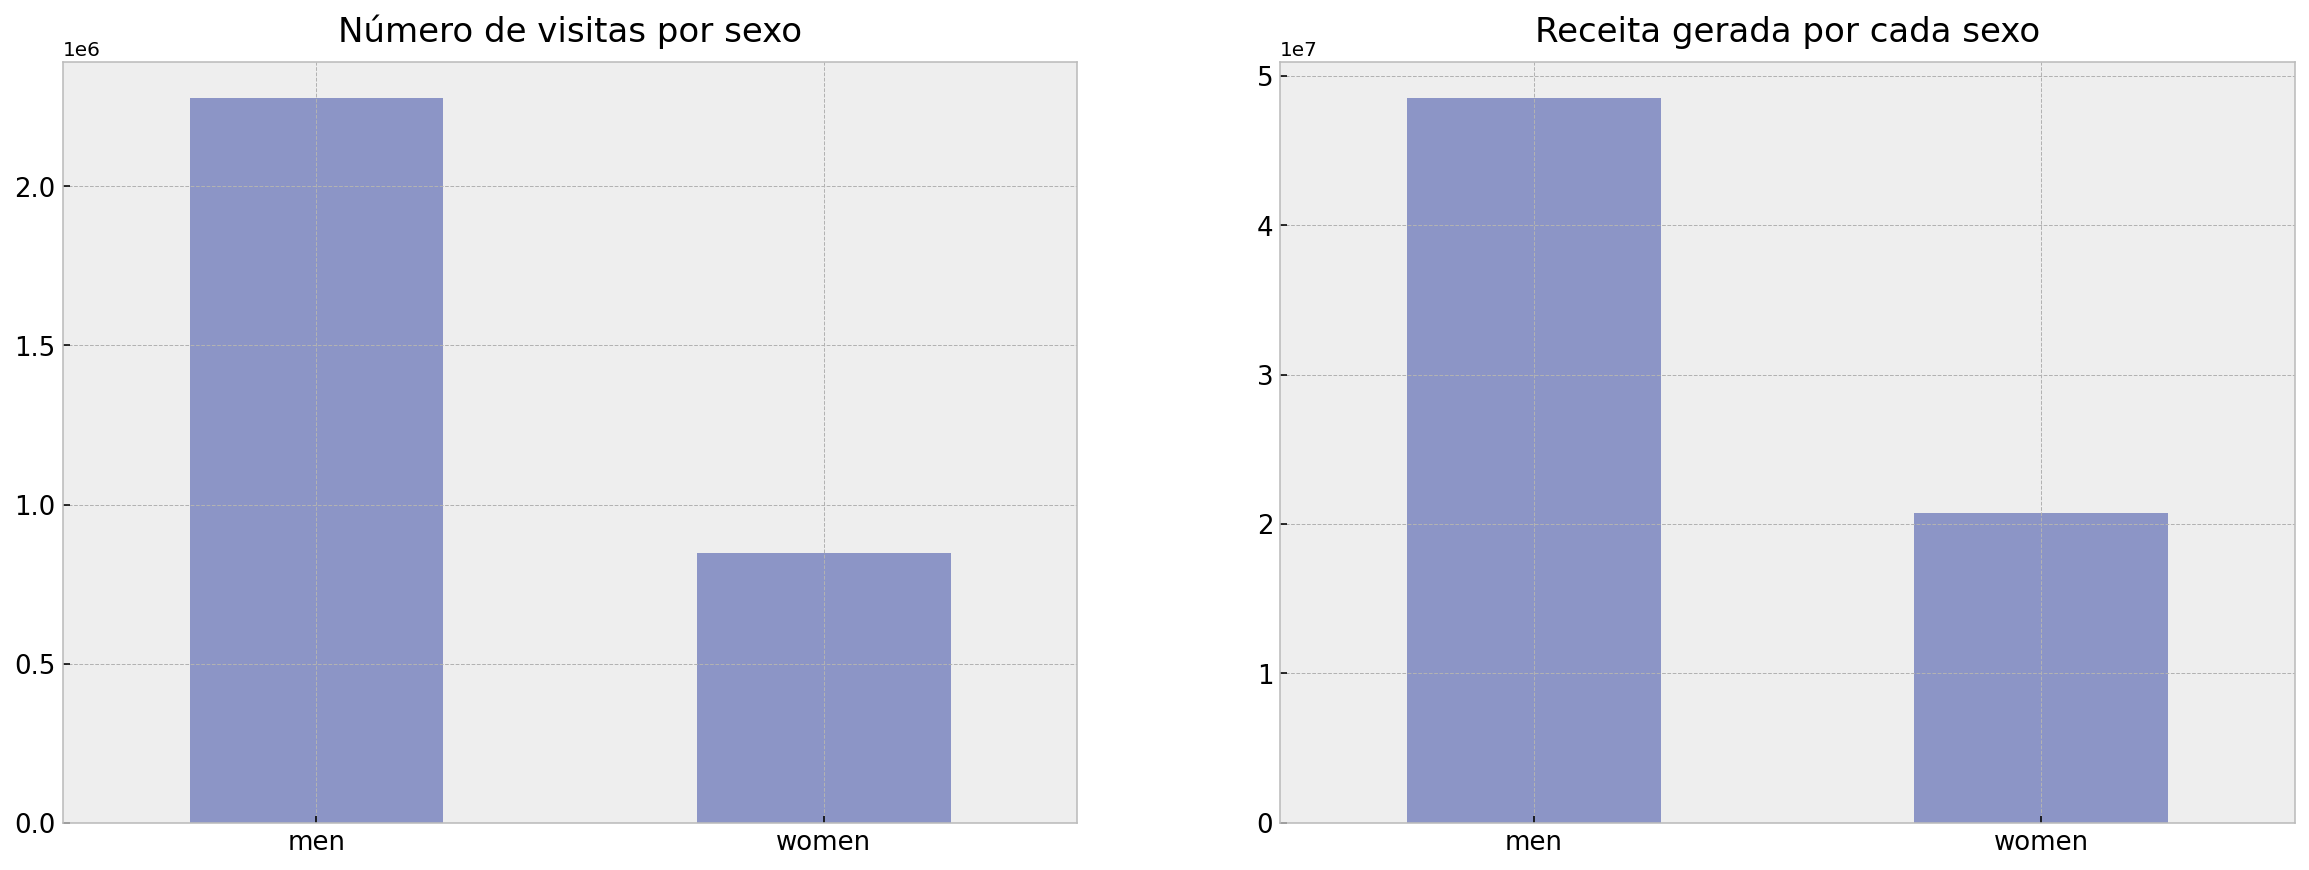

In [51]:
n = 2
cols, rows = 1, 2
df = (pd.concat([df_category_men[['visits']].sum(), df_category_women[['visits']].sum()], axis=1).rename(columns={0: 'men', 1: 'women'}).T,
      pd.concat([df_category_men[['revenue']].sum(), df_category_women[['revenue']].sum()], axis=1).rename(columns={0: 'men', 1: 'women'}).T)

title = ['{} sexo'.format(name) for name in ('Número de visitas por', 'Receita gerada por cada')]
fig, ax = plt.subplots(cols, rows, figsize=(20, 7))

for i in range(rows):
    df[i].sort_values(by=[df[i].columns[0]], ascending=False).plot(kind='bar', fontsize=13, ax=ax[i], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df[i].shape[0] > n else df[i].shape[0])[::-1])).set_title(title[i], fontdict=dict(fontsize=17), pad=10)
    ax[i].get_legend().remove()
    plt.setp(ax[i].get_xticklabels(), rotation=0)
        
plt.show()

__Sumário__
* O sexo masculino predomina no número visitas e na receita gerada pelas vendas.

In [52]:
del df_products_category, df_category_sex, df_category_men, df_category_women, n, cols, rows, df, title, fig, ax
gc.collect()

6278

### 11. Quais são os produtos mais vendidos e qual o retorno que eles geram?

In [53]:
query1 = """
         SELECT product.v2ProductName AS product_name,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue,
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
               UNNEST(hits) AS hits,
               UNNEST(hits.product) AS product
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY product_name
         """

show_amount_of_data_scanned(query1)

Dados processados: 0.648 GB


In [54]:
df_products = client.query(query1).result().to_dataframe()

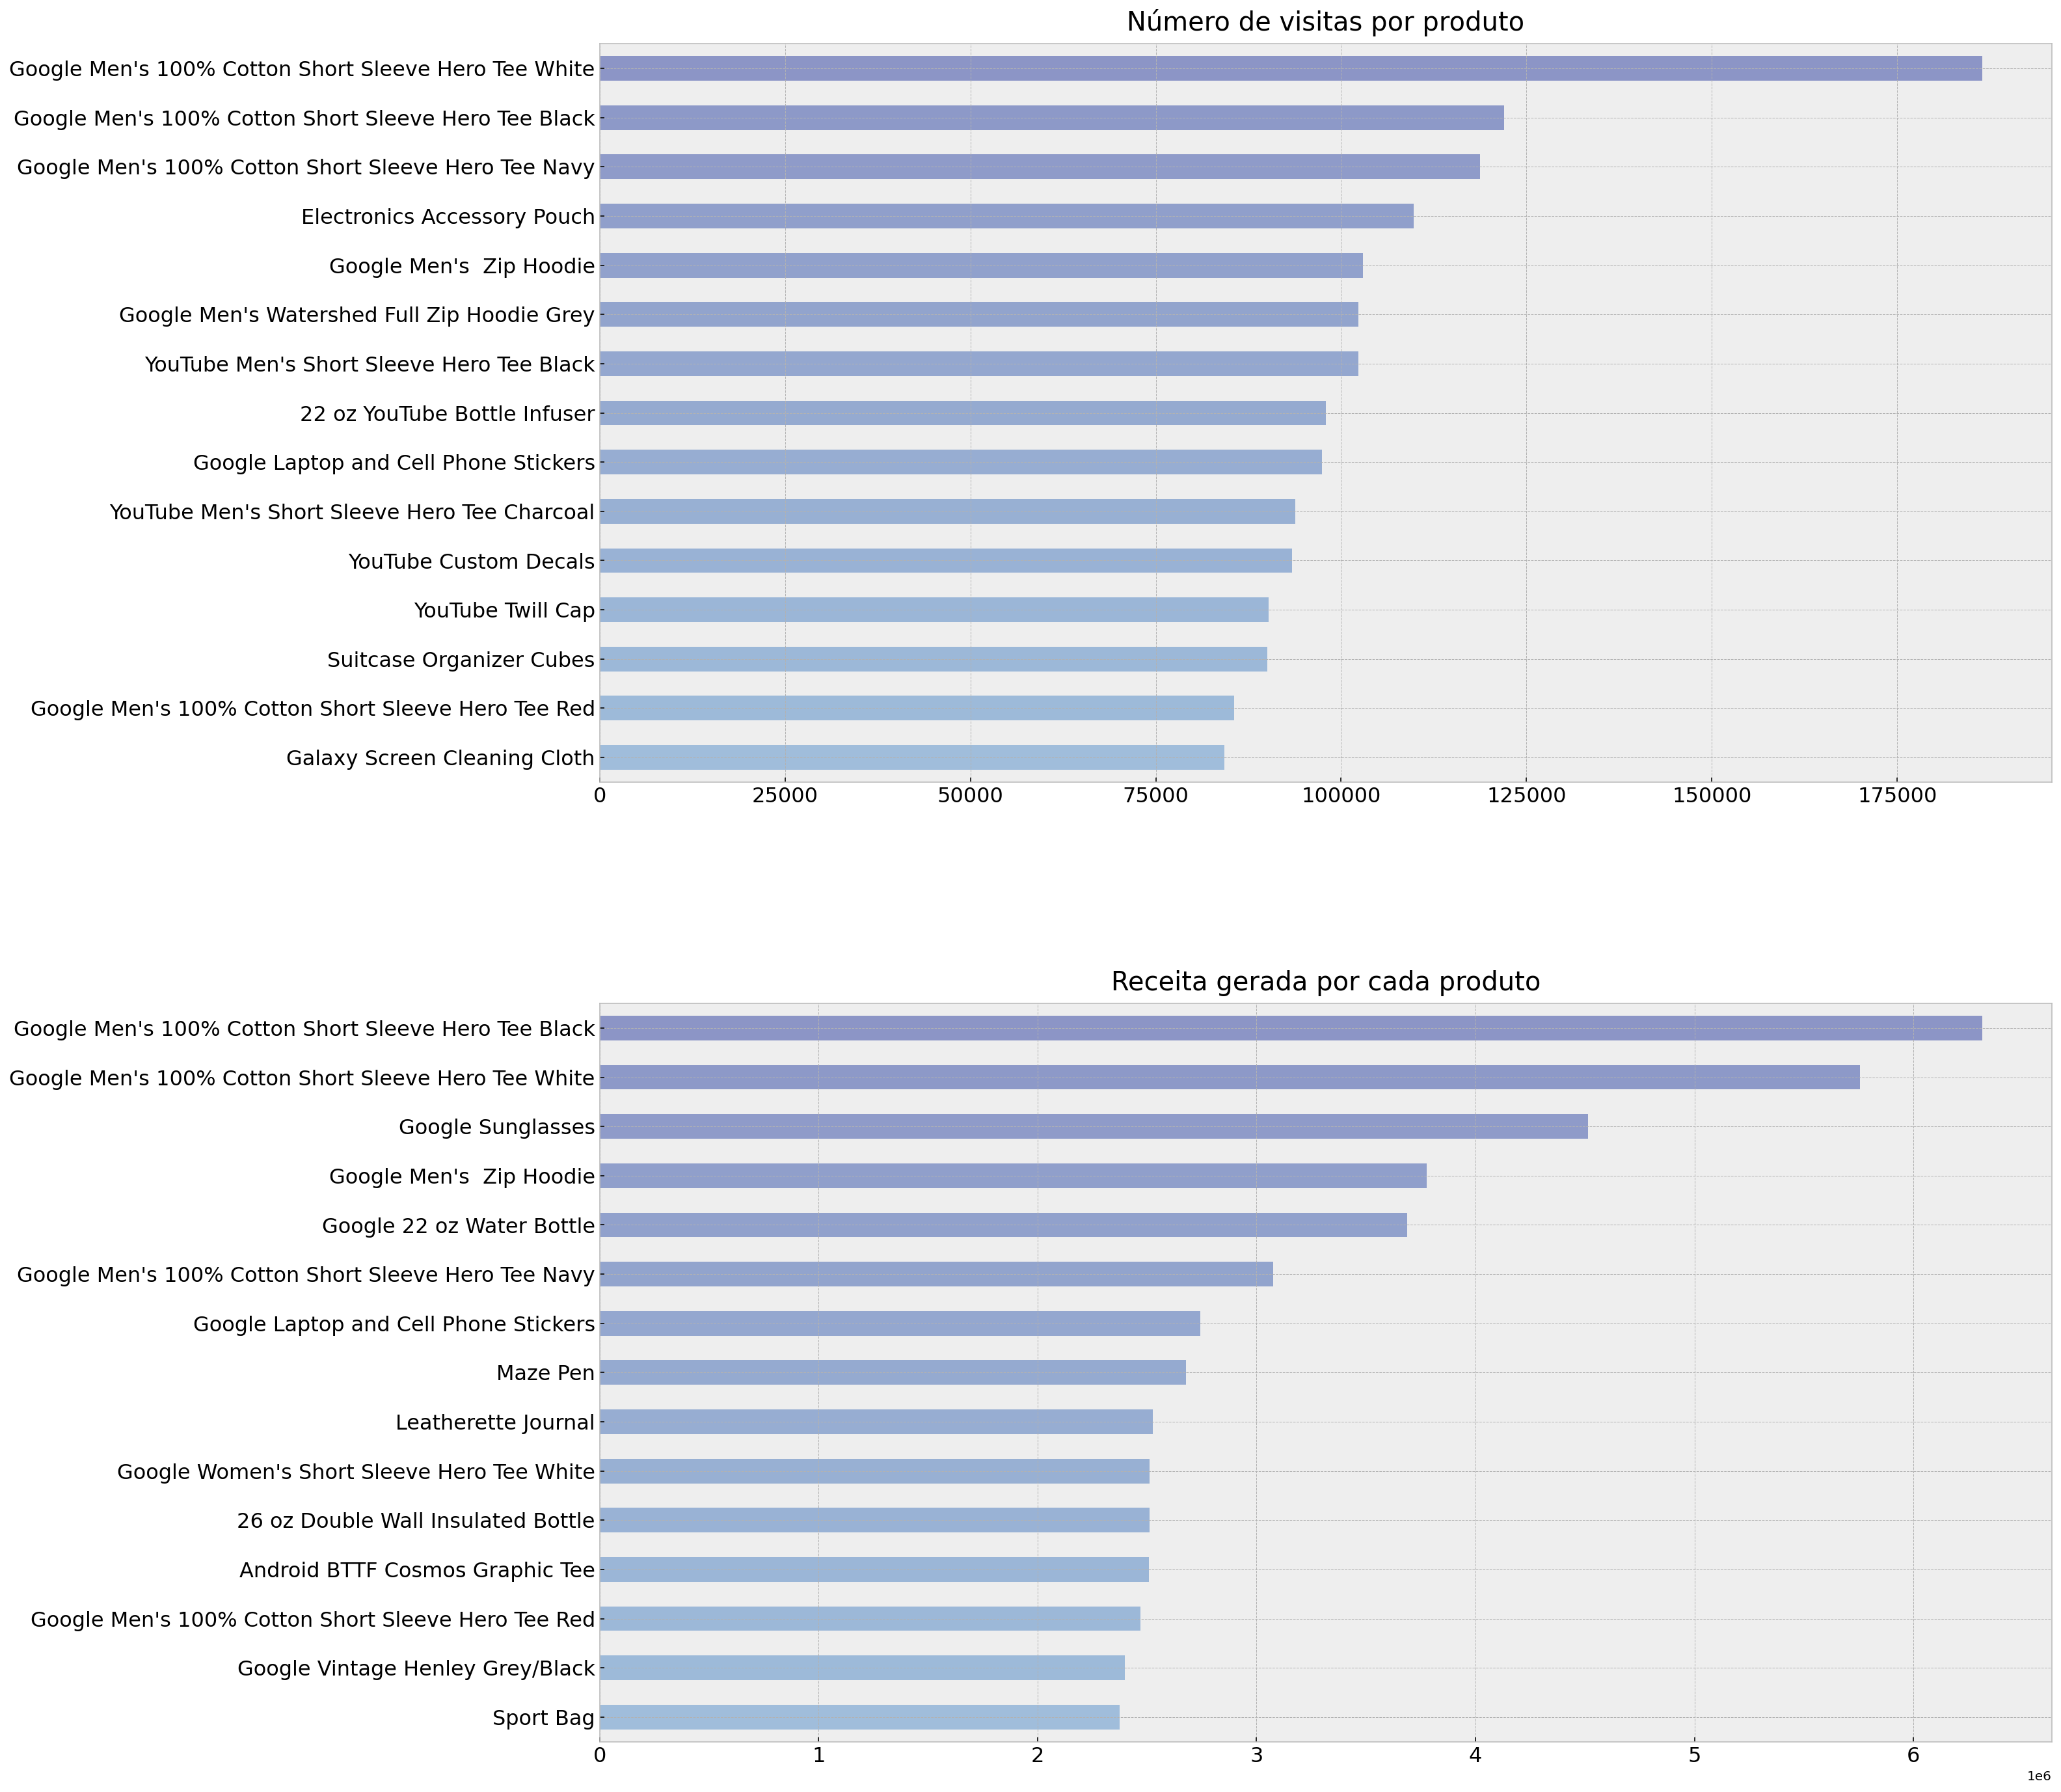

In [55]:
n = 15
cols, rows = 2, 1
df = df_products
title = ['{} produto'.format(name) for name in ('Número de visitas por', 'Receita gerada por cada')]
fig, ax = plt.subplots(cols, rows, figsize=(20, 24))

for i in range(cols):
    df.sort_values(by=[df.columns[i + 1]], ascending=True).tail(n).plot(kind='barh', fontsize=16, ax=ax[i], x=df.columns[0], y=df.columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0]))).set_title(title[i], fontdict=dict(fontsize=20), pad=10)
    ax[i].get_legend().remove()

plt.subplots_adjust(hspace=0.3)
plt.show()

__Sumário__
* As 5 primeiras posições mostradas no segundo gráfico são responsáveis por 74,4% de toda a receita gerada.

In [56]:
del query1, df_products, n, cols, rows, df, title, fig, ax
gc.collect()

9017

### 12. Qual o número de visitas e qual a renda gerada por mês e dia da semana?

In [57]:
query1 = '''
         SELECT FORMAT_DATE('%B', PARSE_DATE('%Y%m%d', date)) AS month,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY month
         '''

query2 = '''
         SELECT FORMAT_DATE('%A', PARSE_DATE('%Y%m%d', date)) AS day_of_week,
                SUM(totals.visits) AS visits,
                IFNULL(SUM(totals.totalTransactionRevenue)/1e6, 0) AS revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY day_of_week
         '''

show_amount_of_data_scanned(query1)
show_amount_of_data_scanned(query2)

Dados processados: 0.027 GB
Dados processados: 0.027 GB


In [58]:
df_month = client.query(query1).result().to_dataframe()
df_day = client.query(query2).result().to_dataframe()

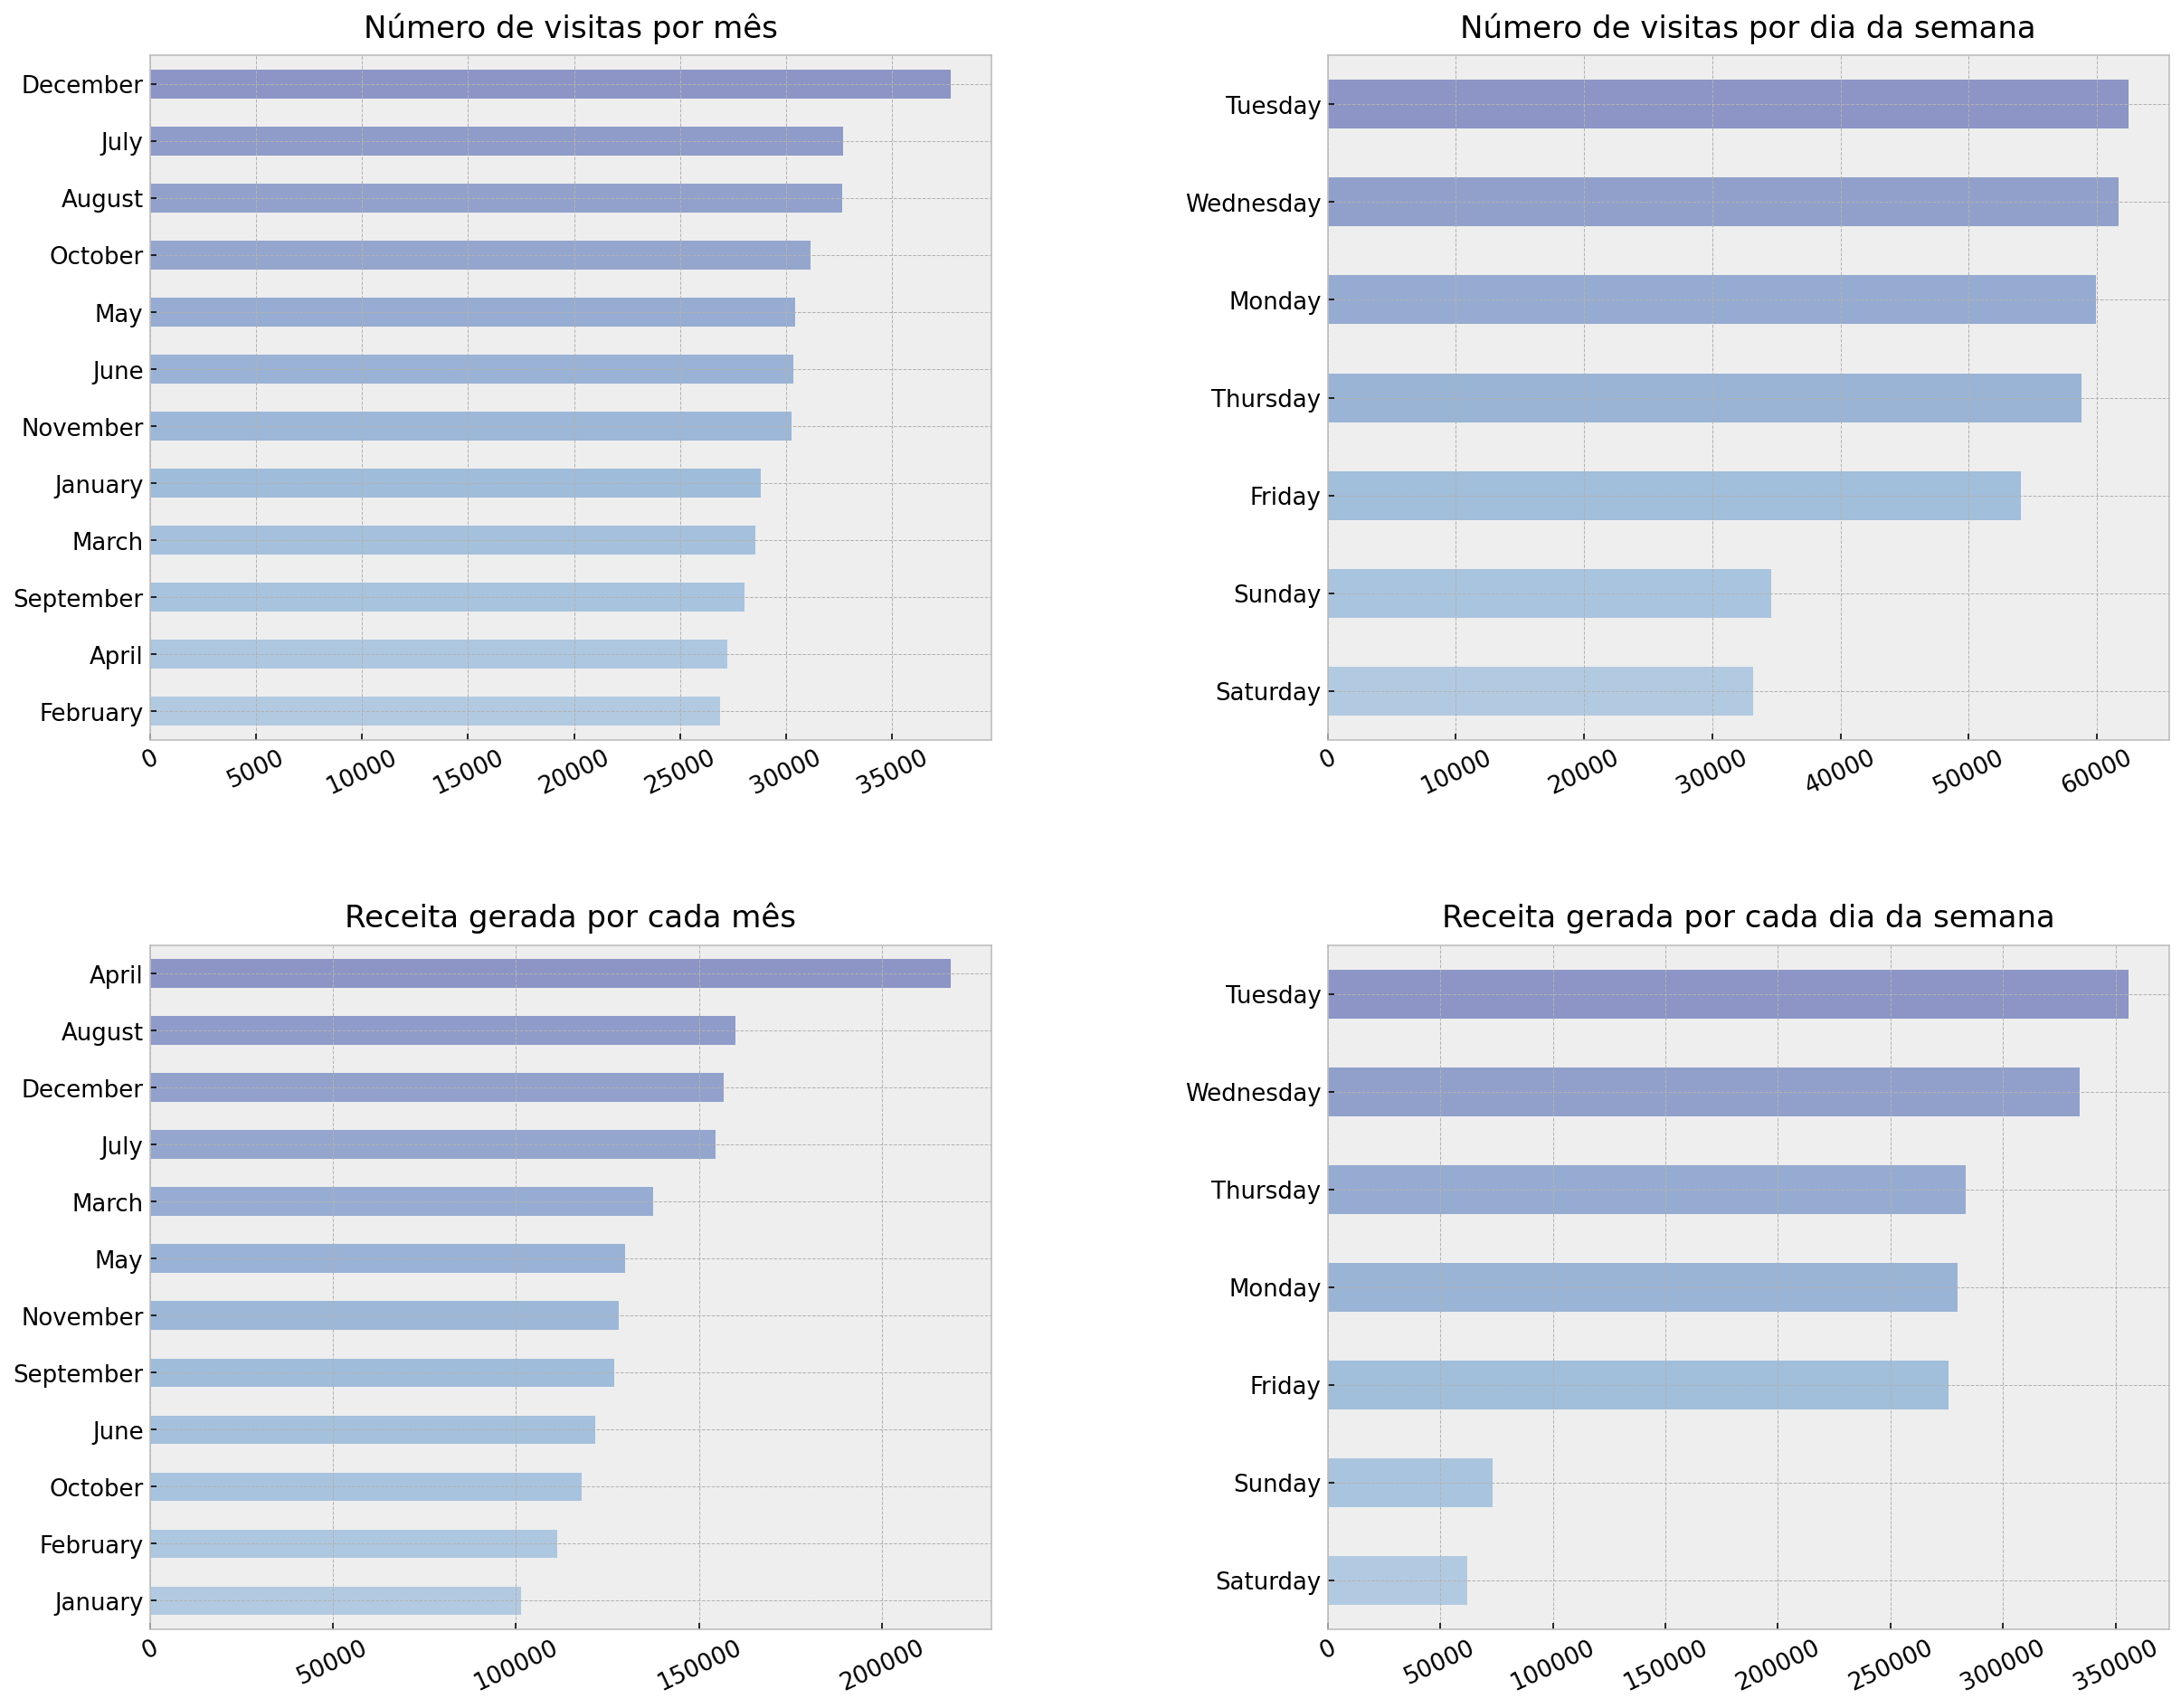

In [59]:
n = 12
cols, rows = 2, 2
df = (df_month, df_day)
title = ['{} {}'.format(name1, name2) for name1 in ('Número de visitas por', 'Receita gerada por cada') for name2 in ('mês', 'dia da semana')]
fig, ax = plt.subplots(cols, rows, figsize=(20, 16))

for i in range(cols):
    for j in range(rows):
        df[j].sort_values(by=[df[j].columns[i + 1]], ascending=True).tail(n).plot(kind='barh', fontsize=13, ax=ax[i][j], x=df[j].columns[0], y=df[j].columns[i + 1], xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(0.3, 0.5, n if df[j].shape[0] > n else df[j].shape[0]))).set_title(title[j + rows * i], fontdict=dict(fontsize=17), pad=10)
        ax[i][j].get_legend().remove()
        plt.setp(ax[i][j].get_xticklabels(), rotation=25)

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

__Sumário__
* Os usuários preferem realizar suas compras nos dias úteis.
* Embora dezembro possua uma grande quantidade de visitas, abril é o mês que gera a maior receita. 

In [60]:
del query1, df_month, df_day, n, cols, rows, df, title, fig, ax
gc.collect()

14993

<a id='time_series'></a>
<h2 style="color:DarkBlue" >Série temporal</h2> 

Vamos analisar o comportamento das visitas ao longo do ano.

In [61]:
query1 = """
         SELECT date,
                SUM(totals.visits) AS visits
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
         GROUP BY Date
         ORDER BY Date ASC
         """

show_amount_of_data_scanned(query1)

Dados processados: 0.027 GB


In [62]:
df_data = client.query(query1).result().to_dataframe()

In [63]:
df_data['date'] = pd.to_datetime(df_data['date'])
df_data = df_data.set_index('date')

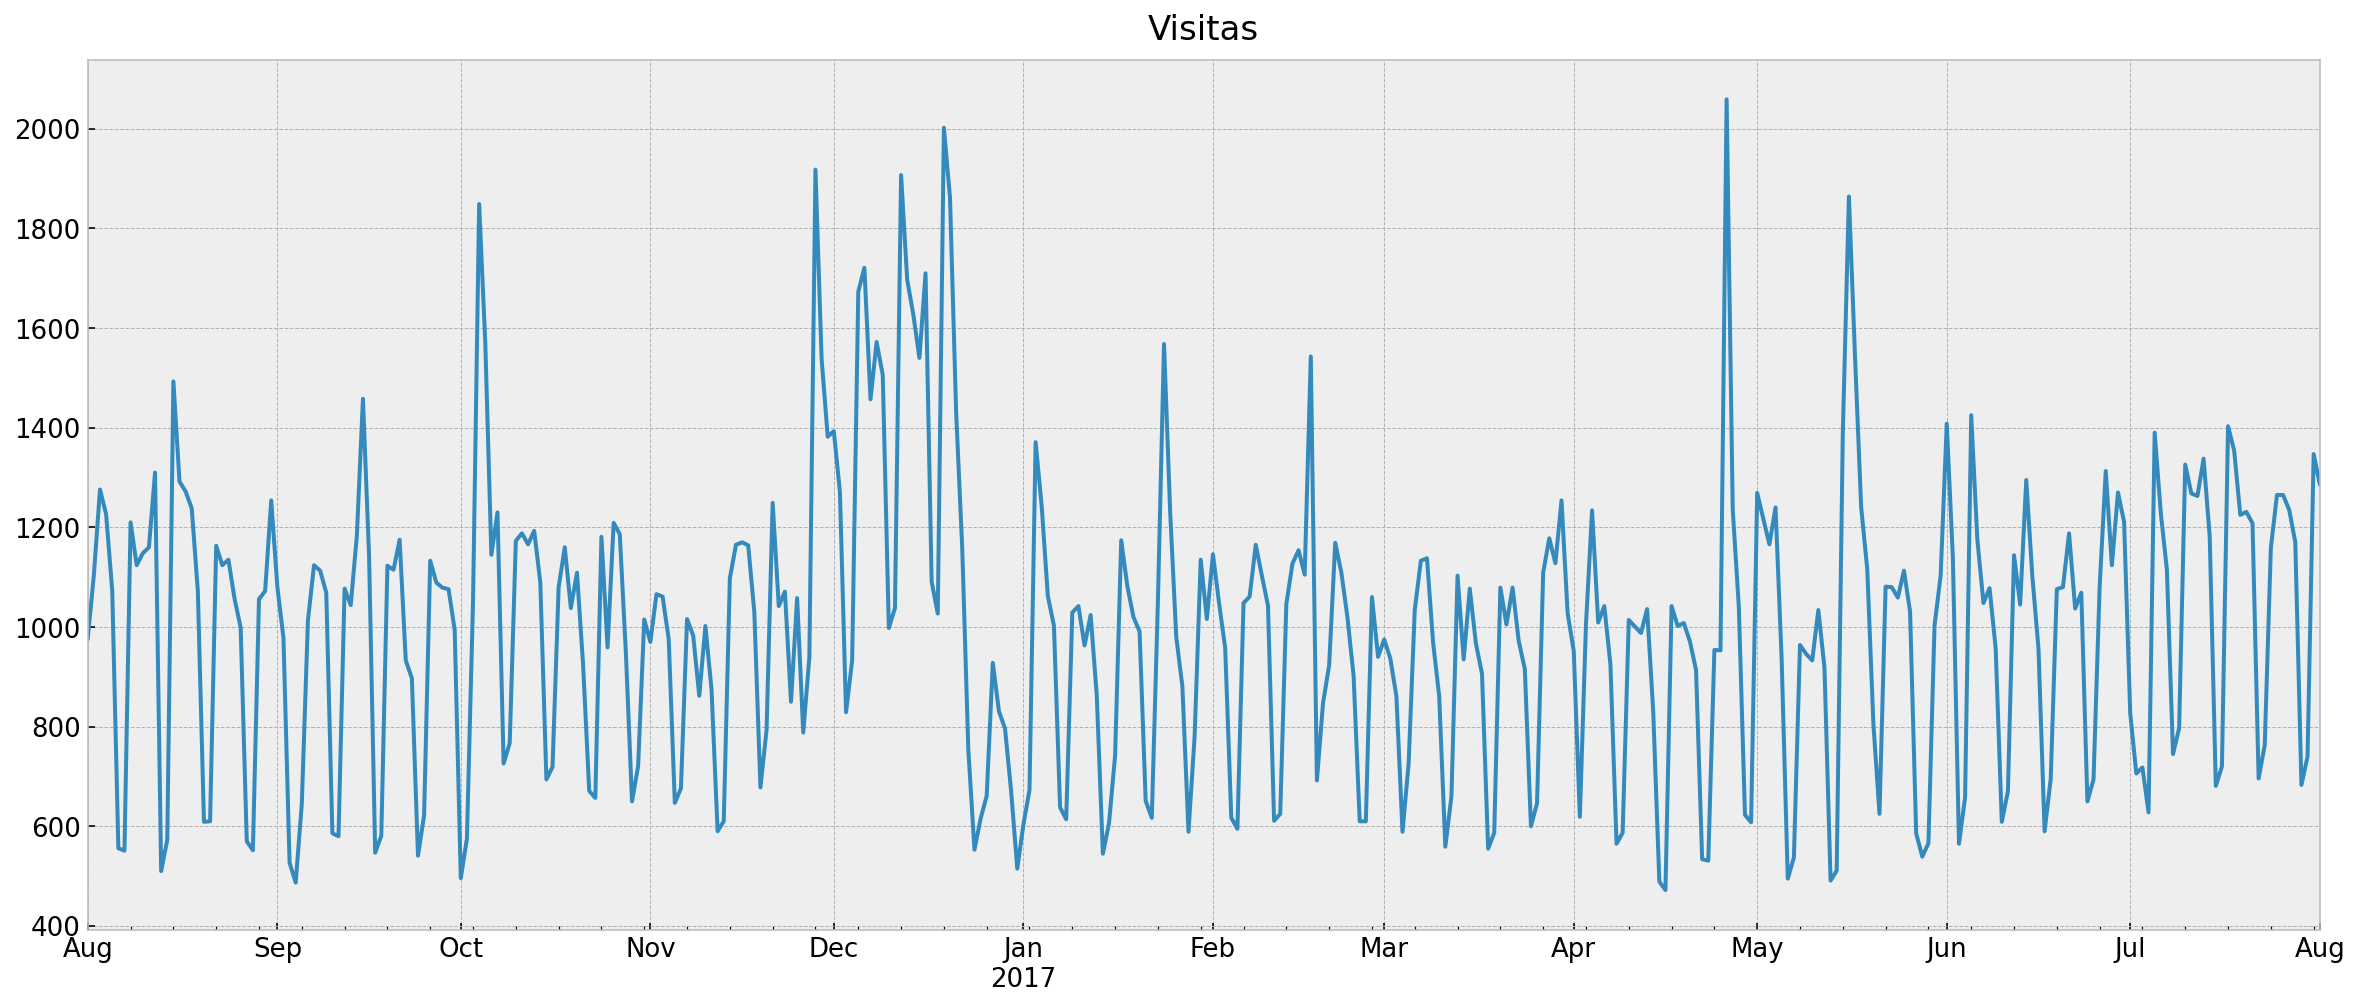

In [64]:
df_data['visits'].plot(figsize=(20, 8), fontsize=13, xlabel='').set_title('Visitas', fontdict=dict(fontsize=17), pad=10);

Como esta série temporal é não estacionária, iremos decompô-la e observar separadamente sua seasonalidade, tendência e resíduos.

In [65]:
decomposition = seasonal_decompose(df_data.iloc[:,0])

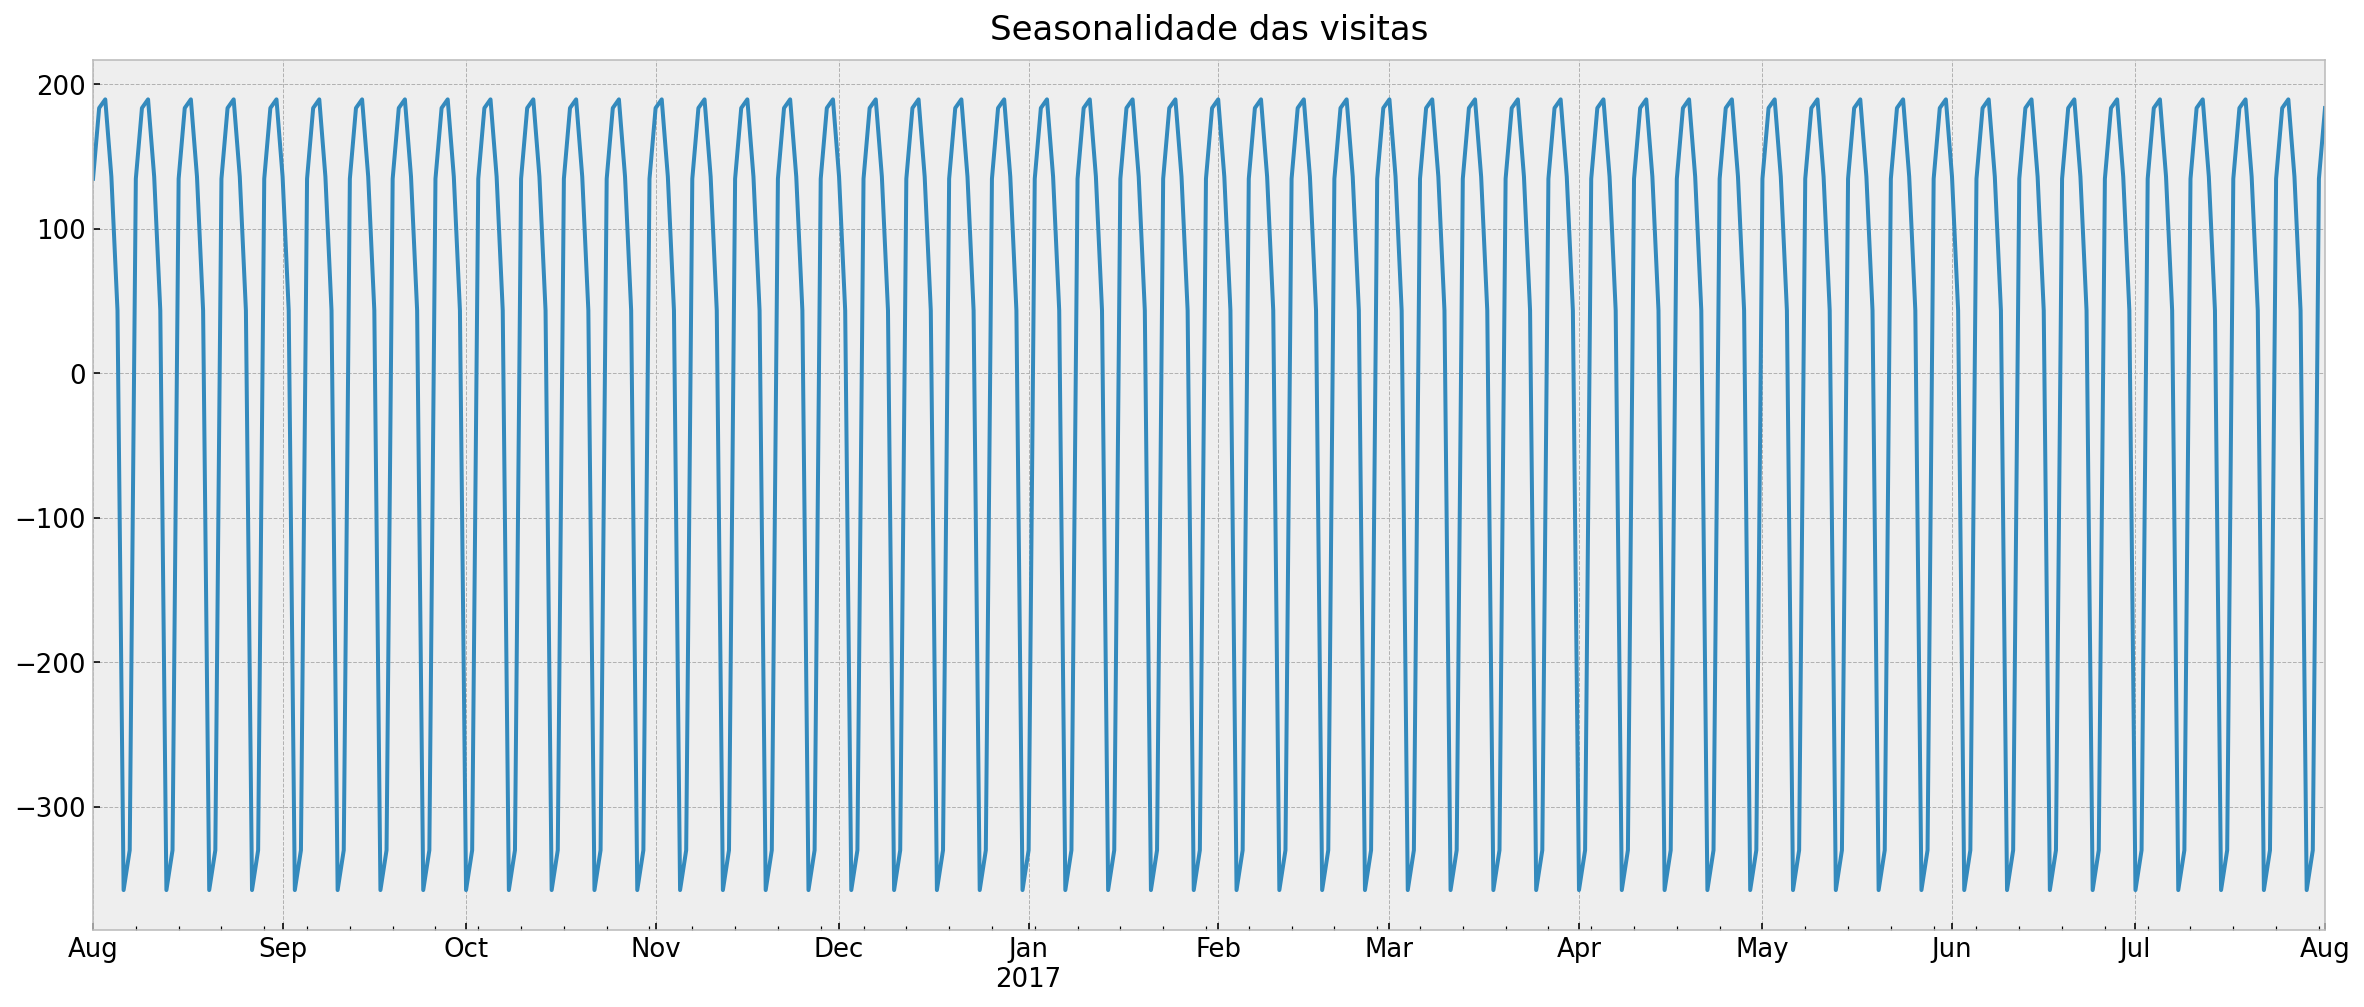

In [66]:
decomposition.seasonal.plot(figsize=(20, 8), fontsize=13, xlabel='').set_title('Seasonalidade das visitas', fontdict=dict(fontsize=17), pad=10);

Há 5 ondulações por mês. Vamos verificar a seasonalidade do mês de dezembro para entender o significado dessas ondulações.

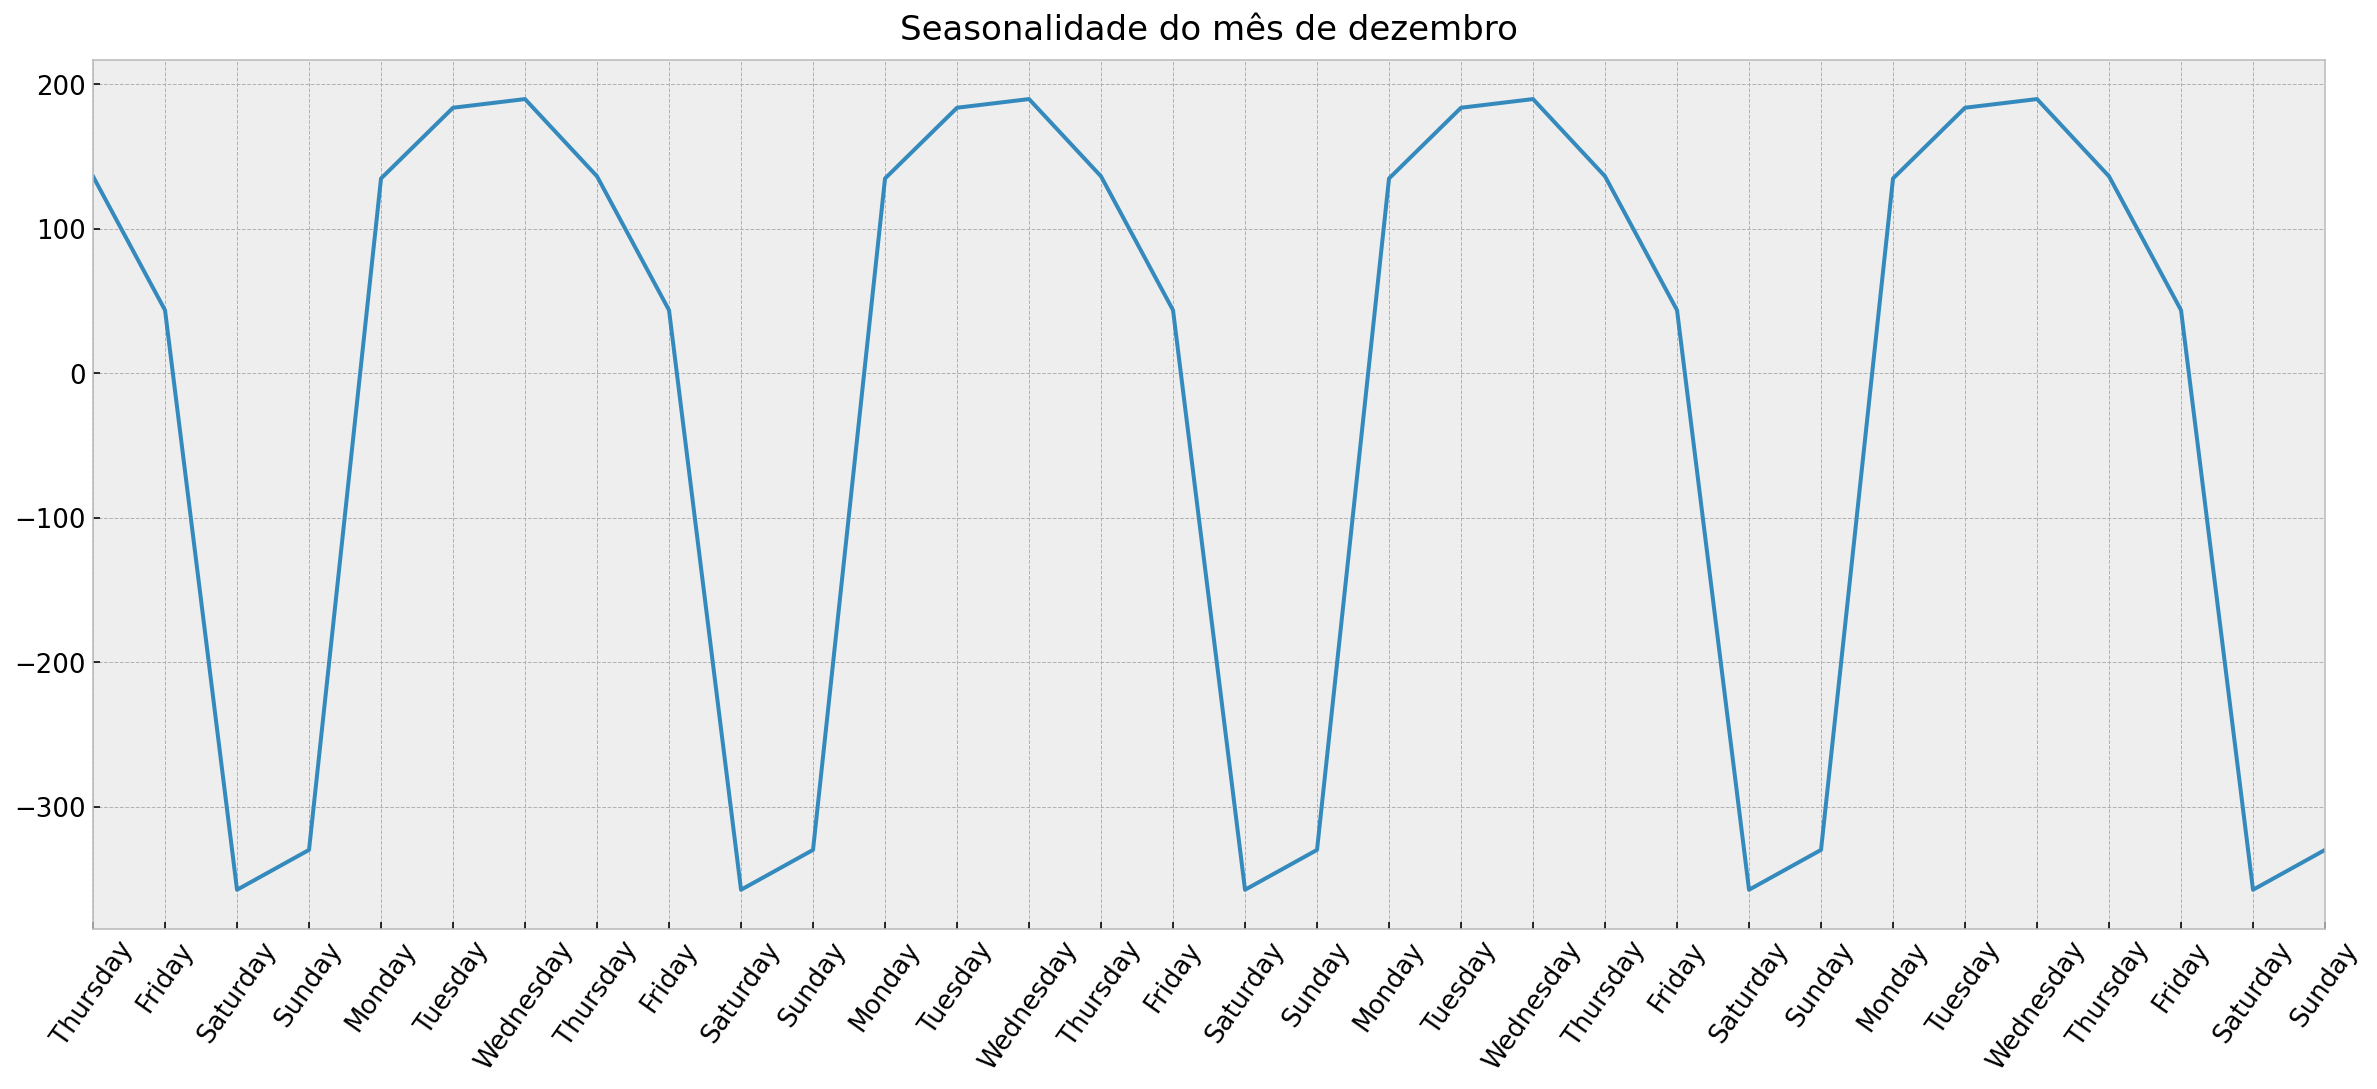

In [67]:
df = decomposition.seasonal.loc['2016-12-01':'2017-01-01']
xaxis = df.index.day_name().tolist()
title = 'Seasonalidade do mês de dezembro'

fig, ax = plt.subplots(figsize=(20, 8))
df.plot(kind='line', fontsize=13, ax=ax, xlabel='', ylabel='').set_title(title, fontdict=dict(fontsize=17), pad=10)
plt.subplots_adjust(hspace=0.3)
plt.xticks(df.index, xaxis, rotation=55)
plt.show()

As descidas representam o baixo número de visitantes nos finais de semanas. O pico de usuários é atigindo entre as terças e quartas-feiras. 

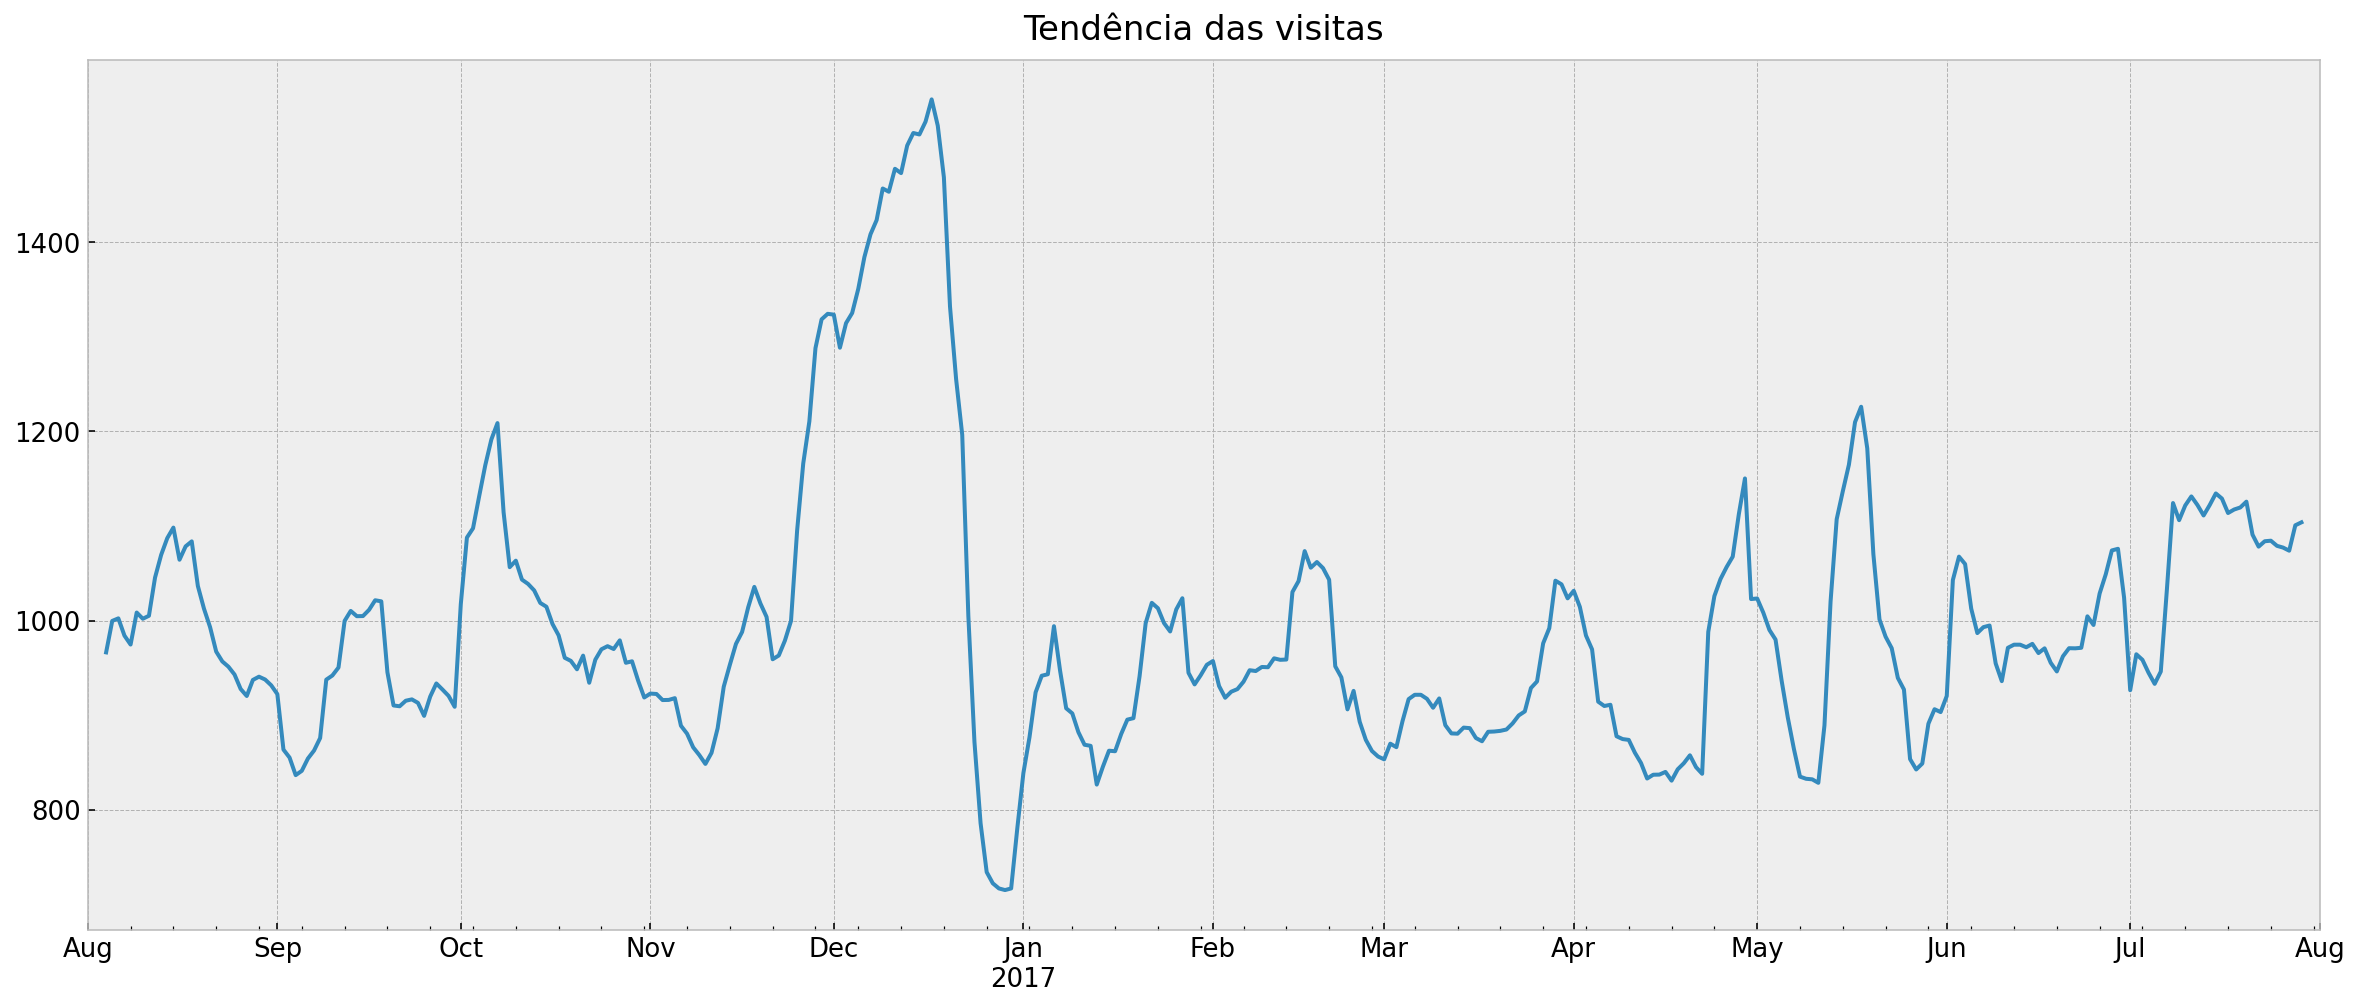

In [68]:
decomposition.trend.plot(figsize=(20, 8), fontsize=13, xlabel='').set_title('Tendência das visitas', fontdict=dict(fontsize=17), pad=10);

Aqui vemos que o número de visitas cresce bastante no mês de dezembro. Qual o dia deste mês que o pico é atingido?

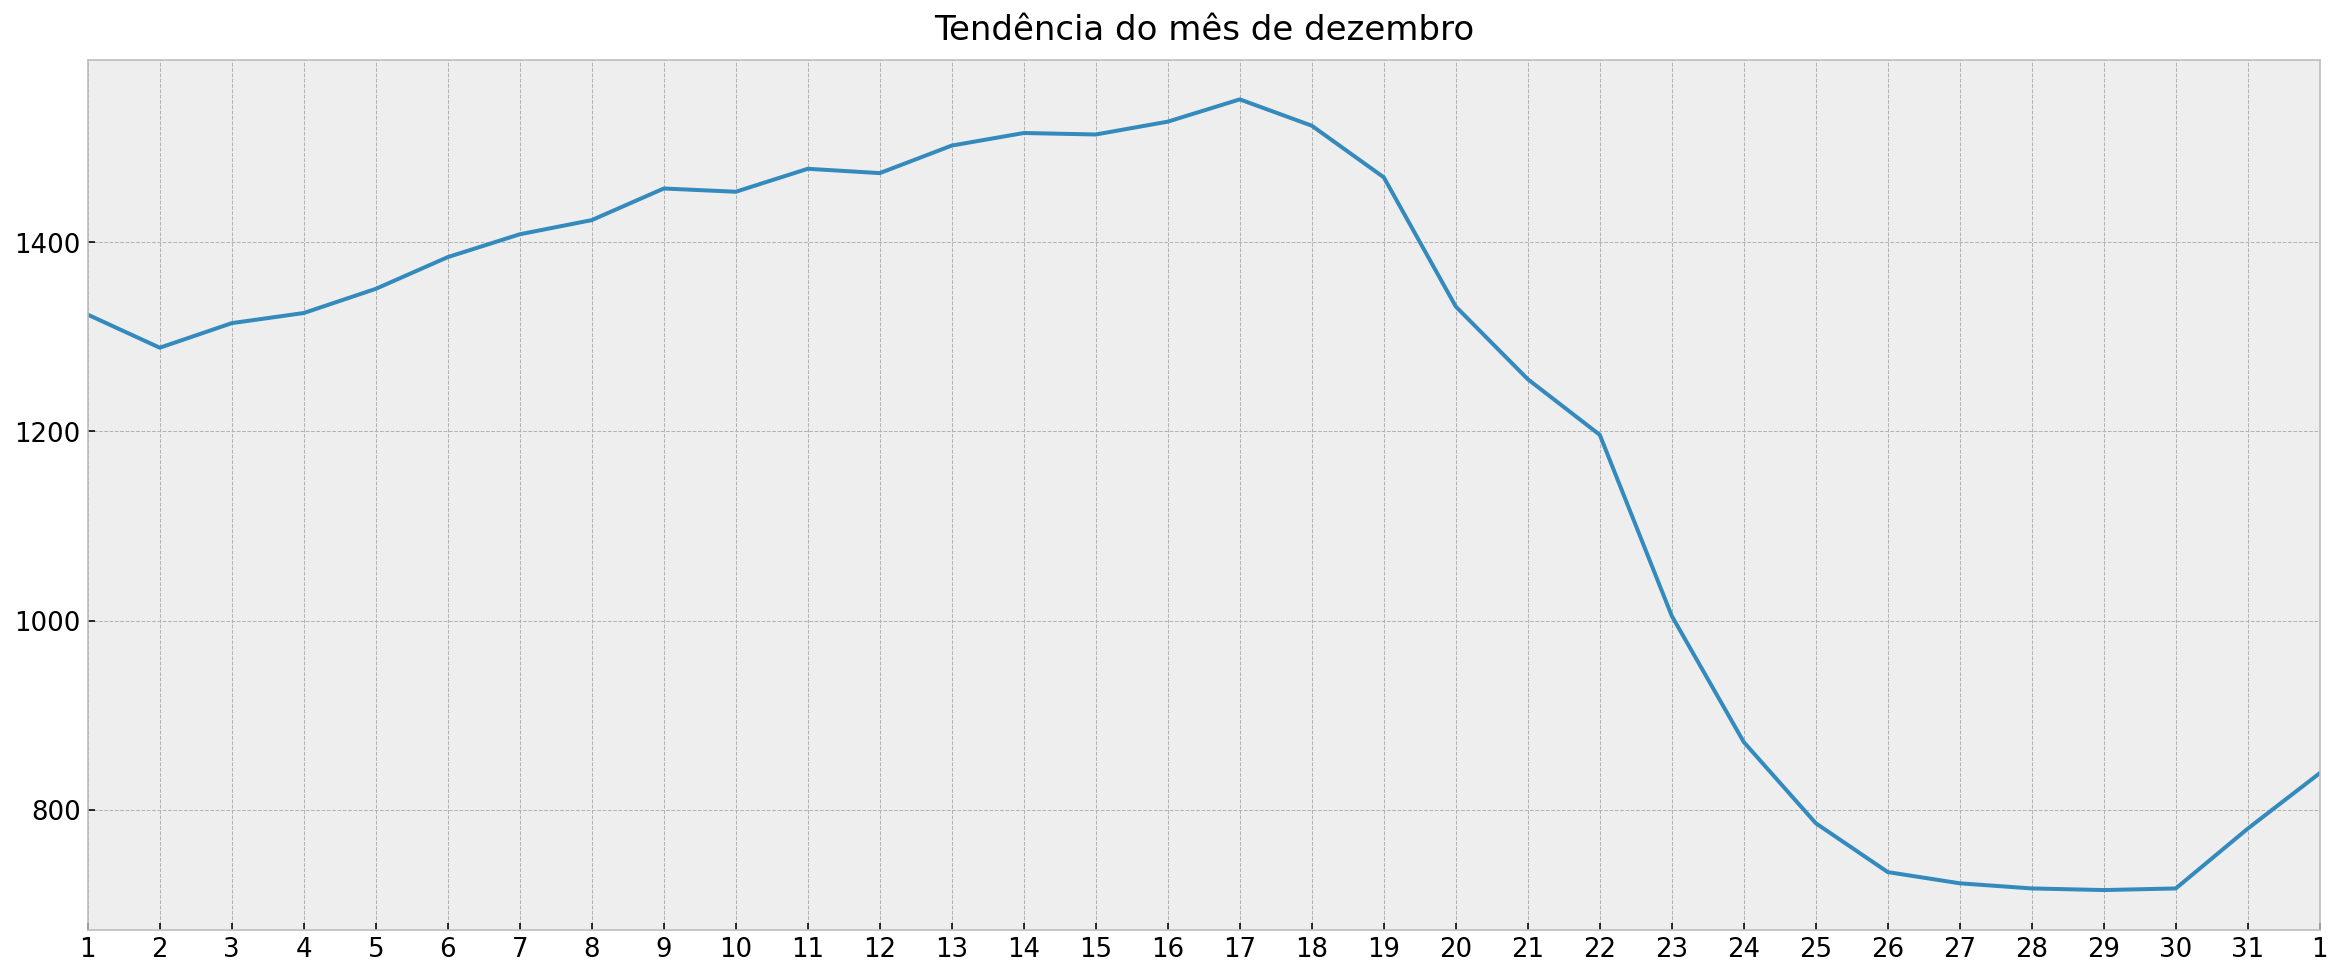

In [69]:
df = decomposition.trend.loc['2016-12-01':'2017-01-01']
xaxis = df.index.day.tolist()
title = 'Tendência do mês de dezembro'

fig, ax = plt.subplots(figsize=(20, 8))
df.plot(kind='line', fontsize=13, ax=ax, xlabel='', ylabel='').set_title(title, fontdict=dict(fontsize=17), pad=10)
plt.subplots_adjust(hspace=0.3)
plt.xticks(df.index, xaxis)
plt.show()

O número de visitantes atinge seu pico no dia 17, uma semana antes do Natal. A explicação disso é que as pessoas querem ter certeza que os seus pedidos cheguem para realizarem a confraternização nesta data.

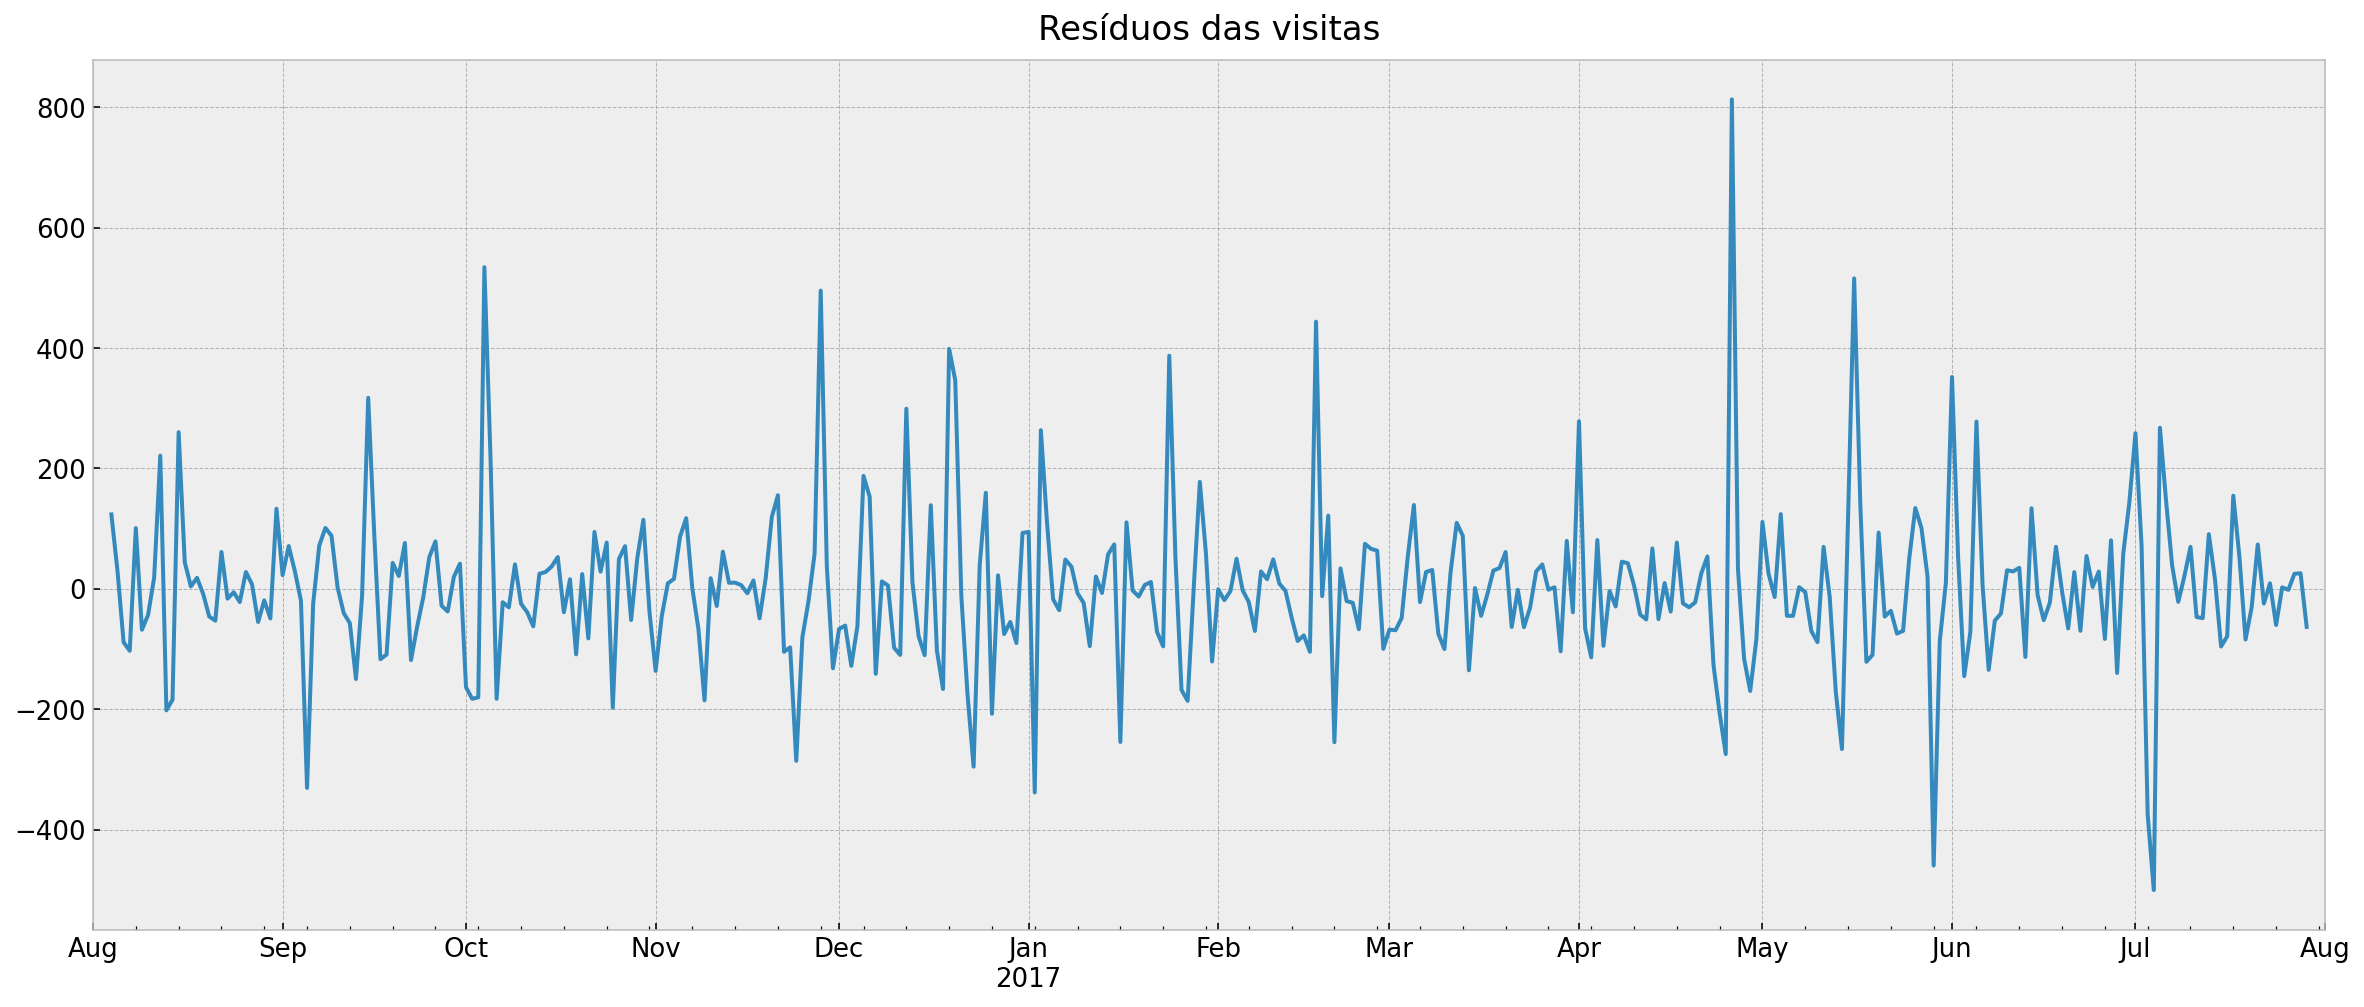

In [70]:
decomposition.resid.plot(figsize=(20, 8), fontsize=13, xlabel='').set_title('Resíduos das visitas', fontdict=dict(fontsize=17), pad=10);

E aqui temos os resíduos, que é o que restou da série temporal após retirar a seasonalidade e a tendência. Pela dificuldade de interpretar estes dados, vamos recompor a série temporal sem a presência dos resíduos para verificar o quanto de informação eles carregam.

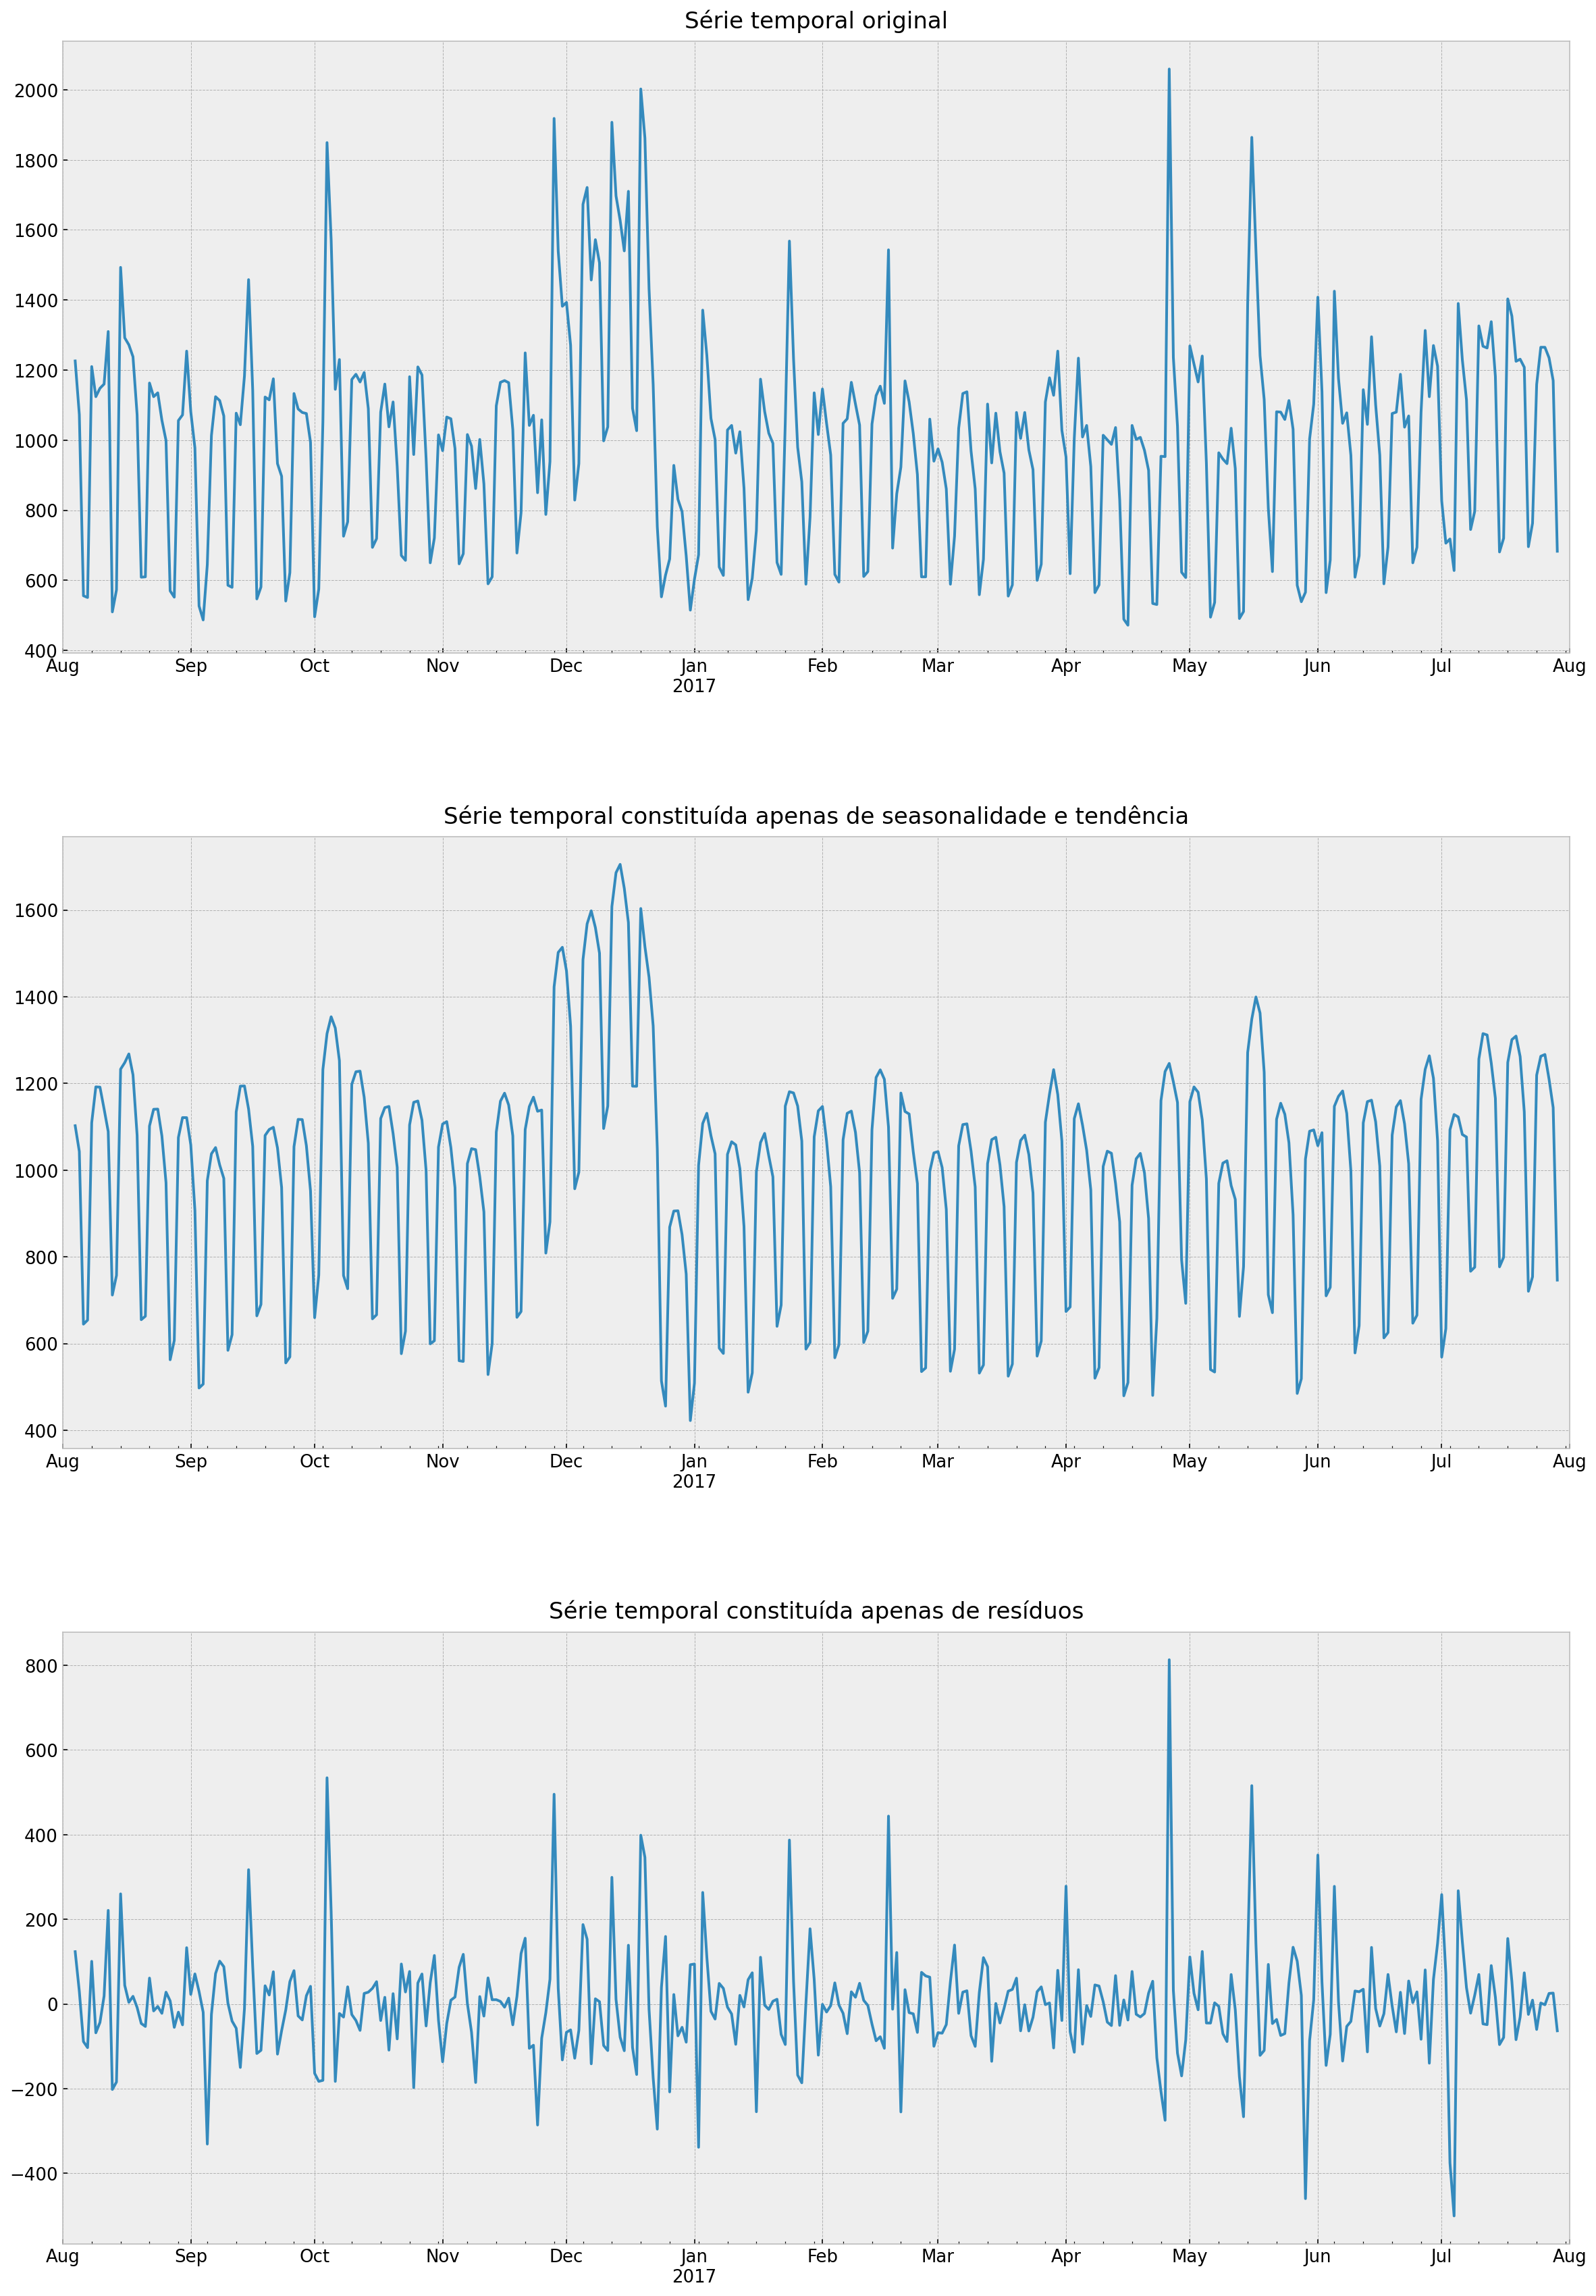

In [71]:
n = 15
cols, rows = 3, 1
df = ((decomposition.trend + decomposition.seasonal + decomposition.resid),
      (decomposition.trend + decomposition.seasonal),
       decomposition.resid)

title = ['Série temporal original',
         'Série temporal constituída apenas de seasonalidade e tendência',
         'Série temporal constituída apenas de resíduos']

fig, ax = plt.subplots(cols, rows, figsize=(20, 30))

for i in range(cols):
    df[i].plot(ax=ax[i], fontsize=13, xlabel='', ylabel='').set_title(title[i], fontdict=dict(fontsize=17), pad=10)

plt.subplots_adjust(hspace=0.3)
plt.show()

Se recompor-mos a série temporal sem a presença dos resíduos, perdemos os picos de visitas que ocorrem nos meses de abril e maio.

No gráfico abaixo, vemos que a retirada dos resíduos não acarreta em grandes perdas de dados no mês de dezembro.

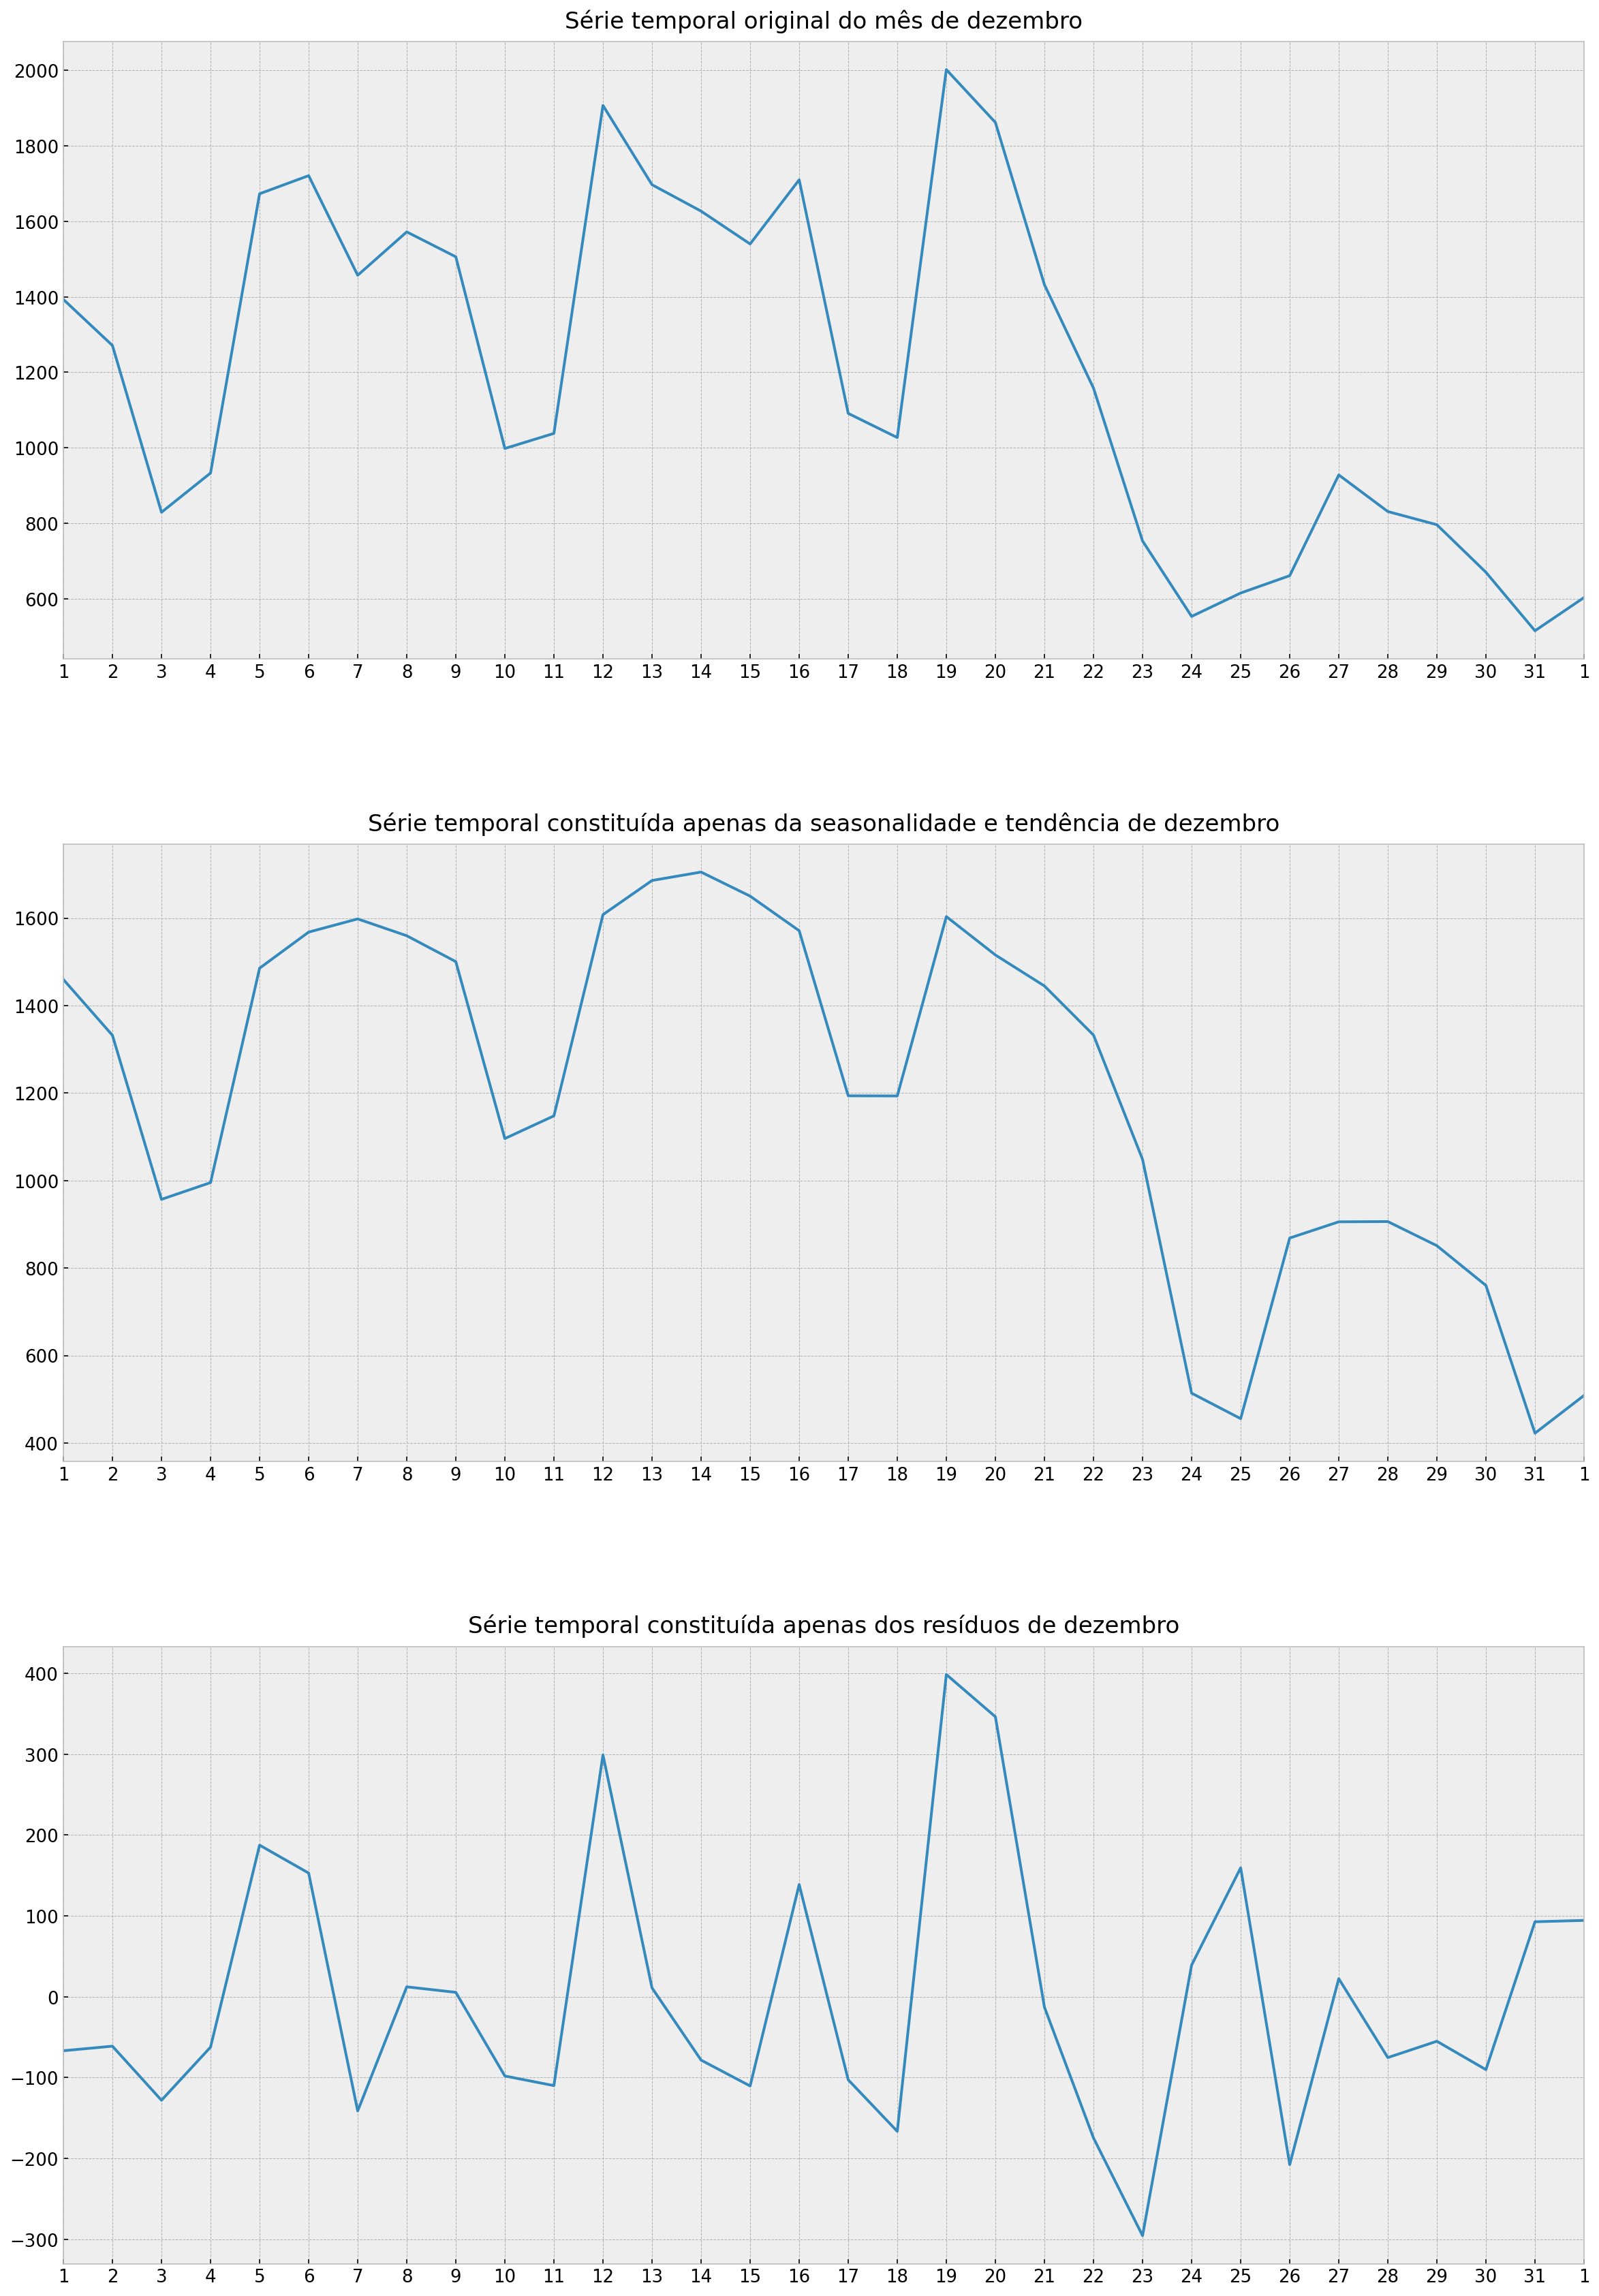

In [72]:
n = 15
cols, rows = 3, 1
df = ((decomposition.trend.loc['2016-12-01':'2017-01-01'] + decomposition.seasonal.loc['2016-12-01':'2017-01-01'] + decomposition.resid.loc['2016-12-01':'2017-01-01']),
      (decomposition.trend.loc['2016-12-01':'2017-01-01'] + decomposition.seasonal.loc['2016-12-01':'2017-01-01']),
       decomposition.resid.loc['2016-12-01':'2017-01-01'])

title = ['Série temporal original do mês de dezembro',
         'Série temporal constituída apenas da seasonalidade e tendência de dezembro',
         'Série temporal constituída apenas dos resíduos de dezembro']

xaxis = df[0].index.day.tolist()
fig, ax = plt.subplots(cols, rows, figsize=(20, 30))

for i in range(cols):
    df[i].plot(ax=ax[i], fontsize=13, xlabel='', ylabel='').set_title(title[i], fontdict=dict(fontsize=17), pad=10)
    plt.sca(ax[i])
    plt.xticks(df[i].index, xaxis)

plt.subplots_adjust(hspace=0.3)
plt.show()

In [73]:
del query1, df_data, decomposition, n, cols, rows, df, title, fig, ax, xaxis
gc.collect()

44332

<a id='rfm'></a>
<h2 style="color:DarkBlue" >Segmentação dos consumidores</h2> 

Vamos segmentar os usuários através da análise RFM, que permite agrupar clientes de acordo com a **R**ecência, **F**requência e Valor **M**onetário de suas compras.

In [74]:
query1 = '''
         SELECT fullVisitorId,
                product.productSKU AS product_sku,
                PARSE_DATE('%Y%m%d', date) AS order_date,
                product.productRevenue/1e6 AS product_revenue
         FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
               UNNEST(hits) AS hits,
               UNNEST(hits.product) AS product
         WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
               AND geoNetwork.country = 'United States'
               AND totals.totalTransactionRevenue IS NOT NULL
               AND productRevenue IS NOT NULL
         '''

show_amount_of_data_scanned(query1)

Dados processados: 0.317 GB


In [75]:
df_orders = client.query(query1).result().to_dataframe()

In [76]:
NOW = datetime.strptime('2017-08-01', '%Y-%m-%d').date()
rfmSegmentation = df_orders.groupby('fullVisitorId').agg({'order_date': lambda x: (NOW - x.max()), # Recency
                                                          'product_sku': lambda x: len(x),         # Frequency
                                                          'product_revenue': lambda x: x.sum()})   # Monetary Value

rfmSegmentation.rename(columns={'order_date': 'recência',
                                'product_sku': 'frequência',
                                'product_revenue': 'valor_monetário'}, inplace=True)

rfmSegmentation.index.name = 'consumidor'

In [77]:
rfmSegmentation['Pontuação_de_Recência'] = pd.qcut(rfmSegmentation['recência'], 5, labels=[5,4,3,2,1])
rfmSegmentation['Pontuação_de_Frequência'] = pd.qcut(rfmSegmentation['frequência'].rank(method='first'), 5, labels=[1,2,3,4,5,])
rfmSegmentation['Pontuação_Monetária'] = pd.qcut(rfmSegmentation['valor_monetário'], 5, labels=[1,2,3,4,5])

rfmSegmentation['PONTUAÇÃO_RFM'] = (rfmSegmentation['Pontuação_de_Recência'].astype(str) + rfmSegmentation['Pontuação_de_Frequência'].astype(str)) 

In [78]:
seg_map = {
    r'[1-2][1-2]': 'hibernando',
    r'[1-2][3-4]': 'em_risco',
    r'[1-2]5': 'não_posso_perdê-los',
    r'3[1-2]': 'prestes_a_hibernar',
    r'33': 'precisam_de_atenção',
    r'[3-4][4-5]': 'clientes_fiéis',
    r'41': 'promissores',
    r'51': 'novos_clientes',
    r'[4-5][2-3]': 'lealdade_potencial',
    r'5[4-5]': 'campeões'
}

rfmSegmentation['SEGMENTO'] = rfmSegmentation['PONTUAÇÃO_RFM'].replace(seg_map, regex=True)

In [79]:
rfmSegmentation[['SEGMENTO', 'recência', 'frequência', 'valor_monetário']].groupby('SEGMENTO').agg(["mean", "count", "max"])

recência                frequência  \
                                           mean count      max       mean   
SEGMENTO                                                                    
campeões             29 days 06:41:58.385650224   892  68 days   7.363229   
clientes_fiéis      144 days 00:53:58.472418670  1414 228 days   7.010608   
em_risco            290 days 13:59:41.298701300  1540 365 days   2.911039   
hibernando          291 days 03:12:47.213114756  1464 365 days   1.112705   
lealdade_potencial   68 days 09:56:23.567134269  1497 136 days   1.728123   
novos_clientes       32 days 17:30:55.900621118   322  68 days   1.000000   
não_posso_perdê-los 298 days 21:41:16.526458616   737 365 days   9.199457   
precisam_de_atenção 185 days 16:37:28.866498740   397 228 days   2.196474   
prestes_a_hibernar  183 days 14:03:33.017751480   845 228 days   1.130178   
promissores          99 days 17:12:43.636363636   396 136 days   1.000000   

                               valor_monetário                       
                    count  max            mean count            max  
SEGMENTO                                                             
campeões              892  145      467.200693   892  128446.519976  
clientes_fiéis       1414  104      304.959871  1414   11229.100000  
em_risco             1540    5      106.000383  1540    3177.500000  
hibernando           1464    2       67.618504  1464    7003.500000  
lealdade_potencial   1497    3       92.010127  1497    7056.150000  
novos_clientes        322    1       51.355435   322     705.800000  
não_posso_perdê-los   737   78      355.268397   737   16032.749991  
precisam_de_atenção   397    3       93.664937   397    2877.000000  
prestes_a_hibernar    845    2       62.078994   845    1688.790000  
promissores           396    1       54.884343   396    2694.400000

A informação sobre os tipos de segmentos se encontra abaixo:

|Consumidor    |Descrição                                                        |
|:------------|:---------------------------------------------------------------|
|Campeões  |Compraram recentemente. Compram com frequência e são os que mais gastam.  |
|Clientes fiéis   |Gastam um boa quantia e compram com frequência.                                 |
|Em risco        |Gastaram muito dinheiro e compraram com freqüência no passado.  |
|Hibernando    |Já se passou algum tempo desde a última vez que compraram. Pouco gastam e possuem baixo número de pedidos.  |
|Lealdade potencial     |São clientes recentes que compraram mais de uma vez e gastaram uma boa quantia.|
|Novos clientes         |Compraram recentemente, mas com pouca frequência.    |
|Não posso perdê-los      |Realizaram grandes compras e com frequência. Mas isso já faz tempo.     |
|Precisam de atenção          |Recência, frequência e valores monetários acima da média. |
|Prestes a “hibernar”        |Recência, frequência e valores monetários abaixo da média. |
|Promissores          |Compradores recentes. Mas não gastaram muito. |


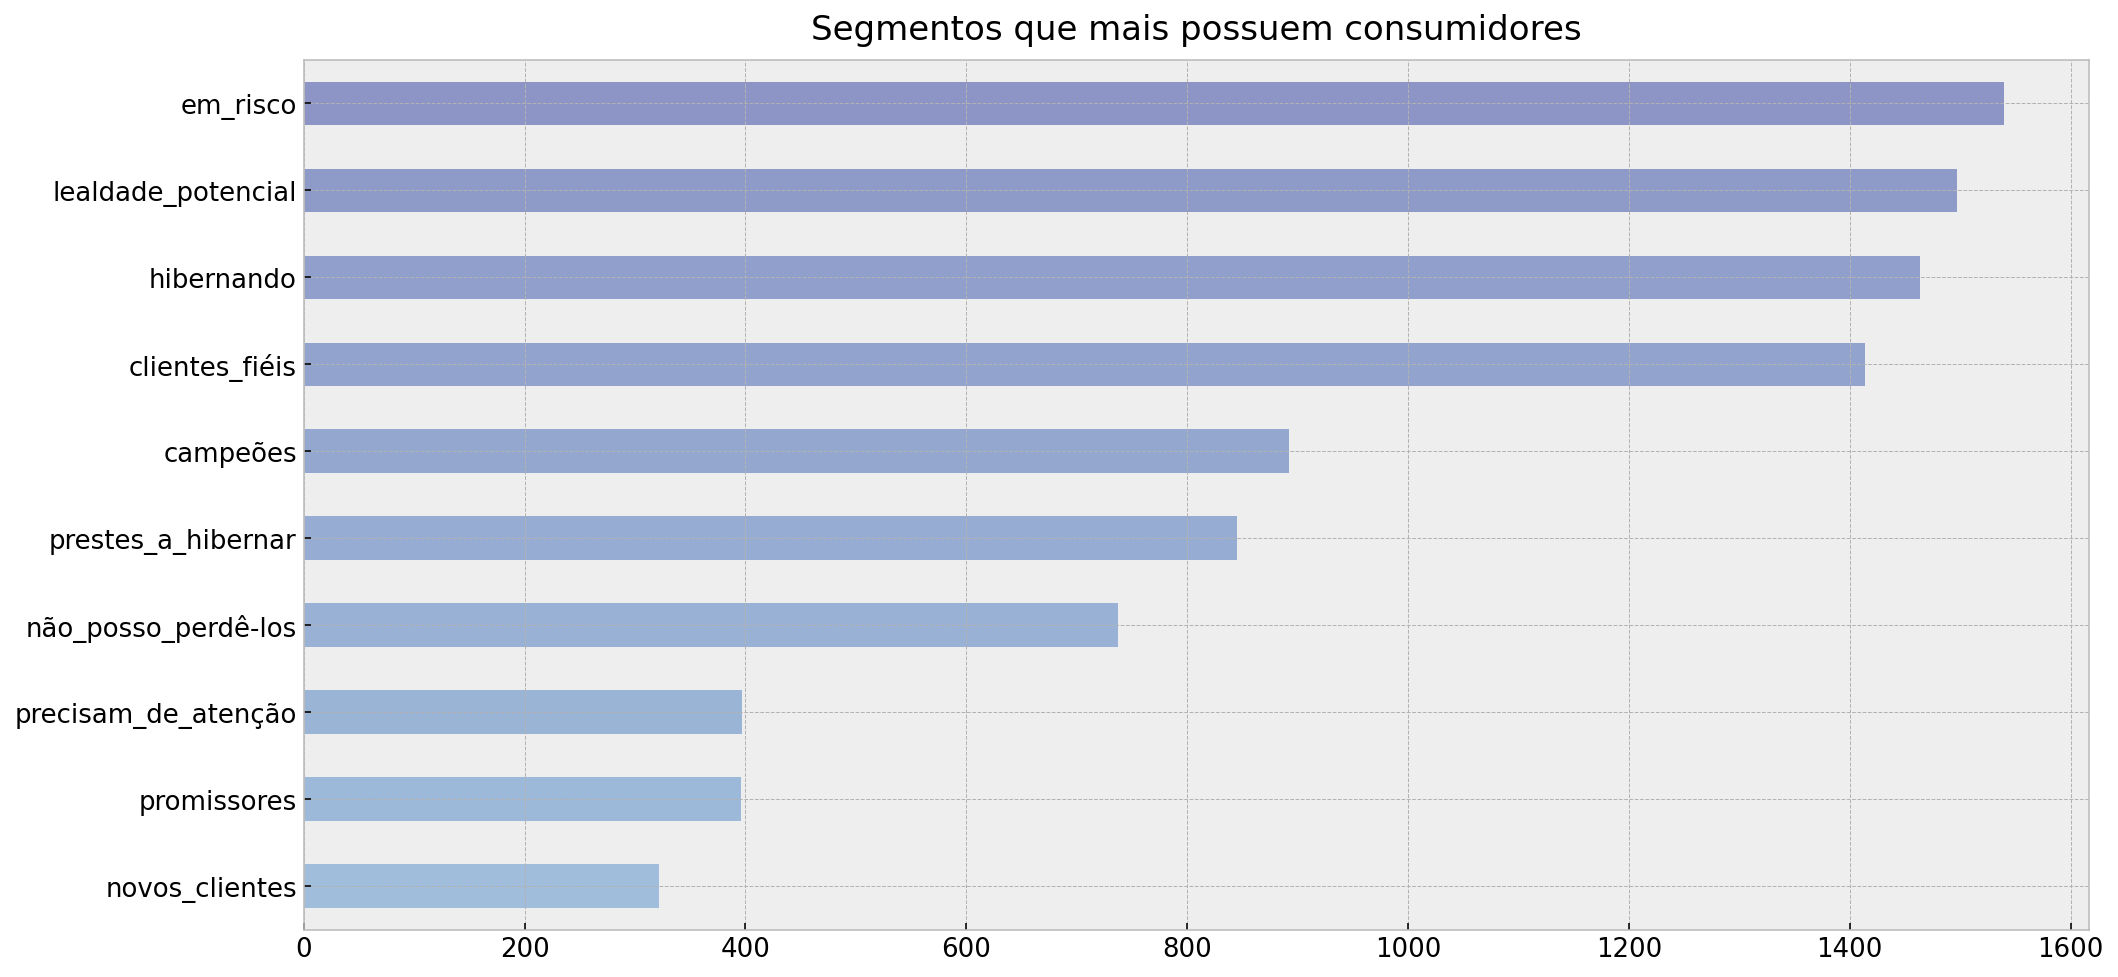

In [80]:
n = 15
df = rfmSegmentation['SEGMENTO'].value_counts()
title = 'Segmentos que mais possuem consumidores'
fig, ax = plt.subplots(figsize=(16, 8))

df.sort_values().tail(n).plot(kind='barh', fontsize=13, ax=ax, xlabel='', ylabel='', color=plt.cm.BuPu(np.linspace(thrs_min, thrs_max, n if df.shape[0] > n else df.shape[0]))).set_title(title, fontdict=dict(fontsize=17), pad=10)
plt.subplots_adjust(hspace=0.3)
plt.show()

Devido ao resultado da tabela e do gráfico, vamos focar em como melhorar as vendas de 4 tipos de segmentos:

### Em risco

In [81]:
data = rfmSegmentation[rfmSegmentation['SEGMENTO'] == 'em_risco'].describe()
data['recência'][1:] = data['recência'][1:].map(lambda x: '{} days'.format(x.days))
data.T

count        mean         std       min       25%       50%  \
recência           1540    290 days     43 days  229 days  246 days  291 days   
frequência       1540.0    2.911039    0.890646       2.0       2.0       3.0   
valor_monetário  1540.0  106.000383  195.293245      4.98    36.115     58.26   

                      75%       max  
recência         331 days  365 days  
frequência            4.0       5.0  
valor_monetário  103.9625    3177.5

Envie emails personalizados e ofereça boas ofertas para reconectá-los.

### Lealdade potencial

In [82]:
data = rfmSegmentation[rfmSegmentation['SEGMENTO'] == 'lealdade_potencial'].describe()
data['recência'][1:] = data['recência'][1:].map(lambda x: '{} days'.format(x.days))
data.T

count       mean         std     min      25%      50%  \
recência           1497    68 days     38 days  0 days  36 days  73 days   
frequência       1497.0   1.728123    0.619614     1.0      1.0      2.0   
valor_monetário  1497.0  92.010127  287.676296     2.5    25.28    38.39   

                     75%       max  
recência         98 days  136 days  
frequência           2.0       3.0  
valor_monetário    70.55   7056.15

Recomende outros produtos e ofereça programas de fidelidade.

### Hibernando

In [83]:
data = rfmSegmentation[rfmSegmentation['SEGMENTO'] == 'hibernando'].describe()
data['recência'][1:] = data['recência'][1:].map(lambda x: '{} days'.format(x.days))
data.T

count       mean         std       min       25%       50%  \
recência           1464   291 days     41 days  229 days  252 days  289 days   
frequência       1464.0   1.112705     0.31634       1.0       1.0       1.0   
valor_monetário  1464.0  67.618504  221.567966       3.2     21.99     31.19   

                      75%       max  
recência         328 days  365 days  
frequência            1.0       2.0  
valor_monetário     59.99    7003.5

Ofereça produtos relevantes e boas ofertas. Recrie o valor da marca.

### Não posso perdê-los

In [84]:
data = rfmSegmentation[rfmSegmentation['SEGMENTO'] == 'não_posso_perdê-los'].describe()
data['recência'][1:] = data['recência'][1:].map(lambda x: '{} days'.format(x.days))
data.T

count        mean         std       min       25%       50%  \
recência           737    298 days     42 days  229 days  258 days  303 days   
frequência       737.0    9.199457    6.446865       5.0       6.0       7.0   
valor_monetário  737.0  355.268397  837.319682     16.45     90.94    163.54   

                       75%           max  
recência          340 days      365 days  
frequência            10.0          78.0  
valor_monetário  331.35999  16032.749991

Reconquiste-os oferecendo ofertas especiais. Fale com eles. Faça-os sentirem importantes.

In [85]:
del query1, df_orders, NOW, rfmSegmentation, seg_map, n, df, title, fig, ax
gc.collect()

3959

<a id='conclusion'></a>
<h2 style="color:DarkBlue" >Conclusão</h2> 

* Vimos que a maioria das vendas são realizadas nos Estados Unidos.
* As visitas acessam preferencialmente a loja pelo computador com navegador Chrome.
* A taxa de rejeição é bem alta para usuários vindos do Youtube.
* Os usuários passam grande parte do tempo revisando os seus pedidos.
* Os finais de semanam apresentam as menores vendas.

<a id='my_notebooks'></a>
<h2 style="color:Darkblue" >Meus notebooks</h2> 

In [86]:
HTML(open('analytics_notebooks.html', 'r').read())

<a id='contact'></a>
<h2 style="color:Darkblue" >Contato</h2>

- **Email**: [rc3bastos@gmail.com](mailto:rc3bastos@gmail.com)
- **LinkedIn**: [linkedin.com/in/rc3bastos/](https://www.linkedin.com/in/rc3bastos/)